In [1]:
#!pip install tensorflow==1.13.1
#!pip install keras 2.2.4

In [2]:
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
#import pymatgen

from matplotlib import pyplot as plt

import tensorflow as tf
import keras
#from keras import backend as K
from tensorflow.keras import backend as K
from keras import initializers
from keras.layers import Dense, Input, Activation, Multiply
from keras.models import Sequential, Model, load_model
from keras.layers.merge import add, concatenate

#import deepchem as dc


/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/apps/share64/debian7/ana

In [3]:
act_dict = {0: 'linear', 1: 'multiply', 2: 'sqrt', 3: '4rt'}
np.random.seed(100000)
#np.random.seed(200000)
weight_dict = {0: 0, 1: 1, 2: np.random.uniform(0.0,0.1,1)[0]} #, 3: 0}
bias_dict = {0: 0, 1: 1, 2: np.random.uniform(0.0,0.001,1)[0]}
nact_terms = 5
nweight_terms = 20
nbias_terms = 5

print(bias_dict)

{0: 0, 1: 1, 2: 0.0005082481908477833}


In [4]:
df = pd.read_csv('CHNO_data.csv')
#df = pd.read_csv('ExpData_v2.csv')
#df = pd.read_excel('ExpData.xlsx')
print (df.shape)

(144, 21)


In [5]:
df = df.round({'N_arb': 6, 'M_arb': 3, 'Q_arb': 3, 'Density [g/cc]': 3, 'D (exp) [km/s]': 3})
#df['D_KJ [km/s]'] = np.around(1.01*np.sqrt(df['N_arb']*np.sqrt(df['M_arb'])*np.sqrt(df['Q_arb']))*(1+1.3*df['Density [g/cc]']),decimals=3)
df

Explosive       C       H       N       O  \
0        1,3,5-Triamino-2,4,6-trinitrobenzene   6.000   6.000   6.000   6.000   
1                       1,3,5-Trinitrobenzene   6.000   3.000   3.000   6.000   
2       2,4,6,2',4',6'-Hexanitrodiphenylamine  12.000   5.000   7.000  12.000   
3                        2,4,6-Trinitrocresol   7.000   5.000   3.000   7.000   
4                3-Nitro-1,2,4-triazole-5-one   2.000   2.000   4.000   3.000   
5                                         ABH  24.000   6.000  14.000  24.000   
6                            Ammonium Picrate   6.000   6.000   4.000   7.000   
7                                         BTF   6.000   0.000   6.000   6.000   
8                                         BTF   6.000   0.000   6.000   6.000   
9                                    Comp A-3   1.870   3.740   2.460   2.460   
10                  Comp B, Grade A (pressed)   4.635   5.800   4.709   5.867   
11                            Comp B-3 (cast)   4.579   5.605   4.816   6.000   
12                   Comp B-3 60/40 [RDX/TNT]   4.600   5.600   4.800   6.000   
13                                   Comp C-3   1.900   2.830   2.340   2.600   
14                                   Comp C-4   3.860   7.570   5.220   5.320   
15                                   Comp C-4   1.820   3.540   2.460   2.510   
16                         Cyanuric Triazide    3.000   0.000  12.000   0.000   
17                             Cyclotol 75/25   3.983   5.754   5.262   6.000   
18                   Cyclotol-50/50 [RDX/TNT]   5.000   5.500   4.500   6.000   
19                   Cyclotol-60/40 [RDX/TNT]   4.600   5.600   4.800   6.000   
20                   Cyclotol-65/35 [RDX/TNT]   4.400   5.650   4.950   6.000   
21                   Cyclotol-70/30 [RDX/TNT]   4.200   5.700   5.100   6.000   
22                   Cyclotol-75/25 [RDX/TNT]   3.983   5.754   5.262   6.000   
23                   Cyclotol-77/23 [RDX/TNT]   3.920   5.770   5.310   6.000   
24                   Cyclotol-78/22 [RDX/TNT]   3.880   5.780   5.340   6.000   
25           Cylcotrimethylene Trinitrosamine   3.000   6.000   6.000   3.000   
26                                       DATB   6.000   5.000   5.000   6.000   
27                                      DATB    6.000   5.000   5.000   6.000   
28                                      DATB    6.000   5.000   5.000   6.000   
29                                       DEGN   4.000   8.000   2.000   7.000   
..                                        ...     ...     ...     ...     ...   
114                                       RDX   3.000   6.000   6.000   6.000   
115                                       RDX   3.000   6.000   6.000   6.000   
116                                       RDX   3.000   6.000   6.000   6.000   
117                                       RDX   3.000   6.000   6.000   6.000   
118                                       RDX   3.000   6.000   6.000   6.000   
119                                       RDX   3.000   6.000   6.000   6.000   
120                                       RDX   3.000   6.000   6.000   6.000   
121                                     TACOT  12.000   4.000   8.000   8.000   
122                                      TATB   6.000   6.000   6.000   6.000   
123                                      TATB   6.000   6.000   6.000   6.000   
124  Tetramethylolcyclopentanone Tetranitrate   9.000  12.000   4.000  13.000   
125                                    Tetryl   7.000   5.000   5.000   8.000   
126                                    Tetryl   7.000   5.000   5.000   8.000   
127                                    Tetryl   7.000   5.000   5.000   8.000   
128                                    Tetryl   7.000   5.000   5.000   8.000   
129                                    Tetryl   7.000   5.000   5.000   8.000   
130                                    Tetryl   7.000   5.000   5.000   8.000   
131                                       TNT   7.000   5.000   3.0

In [6]:
inputs = np.array(df[['N_arb','M_arb','Q_arb','Density [g/cc]']])

outputs = np.array(df['D (exp) [km/s]'])
len(outputs)
#Train_inputs, Test_inputs, Train_outputs, Test_outputs = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

144

In [7]:

def sqrt_act(x):
    return np.abs(x)**(1/2)

def frt_act(x):
    return np.abs(x)**(1/4)



In [8]:
class CustomDense(keras.layers.Layer):
    def __init__(self, num_units, input_num, activation, name, trainable_weight, trainable_bias):
        super(CustomDense, self).__init__()
        self.num_units = num_units
        self.activation = Activation(activation)
        self.trainable_weight = trainable_weight
        self.trainable_bias = trainable_bias
        self.name = name
        name_w = 'w'+self.name[1:]
        name_b = 'b'+self.name[1:]
        self.weight = self.add_weight(shape=(input_num, self.num_units), name=name_w, trainable=self.trainable_weight, initializer="zeros")
        self.bias = self.add_weight(shape=(self.num_units,), name=name_b, trainable=self.trainable_bias, initializer="zeros")
        
    def call(self, input):
        y = tf.matmul(input, self.weight) + self.bias
        y = self.activation(y)
        return y


In [9]:
def create_node(input1, input2, input3, input4, name, trainable1, trainable2, trainable3, trainable4, act, bias):
    base = name
    n1 = base + "1"
    n2 = base + "2"
    n3 = base + "3"
    n4 = base + "4"
    an1 = CustomDense(1, 1, activation = 'linear', name=n1, trainable_weight=trainable1, trainable_bias = False) (input1)
    an2 = CustomDense(1, 1, activation = 'linear', name=n2, trainable_weight=trainable2, trainable_bias = False) (input2)
    an3 = CustomDense(1, 1, activation = 'linear', name=n3, trainable_weight=trainable3, trainable_bias = False) (input3)
    an4 = CustomDense(1, 1, activation = 'linear', name=n4, trainable_weight=trainable4, trainable_bias=bias) (input4)
    if (act != "multiply"):
        an = add([an1, an2, an3, an4])
        if (act == "4rt"):
            an = Activation(frt_act) (an)
        elif (act == "sqrt"):
            an = Activation(sqrt_act) (an)
        else:
            an = Activation(act) (an)
        
    
    else:
        an = Multiply()([an1, an2, an3, an4])
        
    return an

In [10]:
def create_model(x):
    #initializer = keras.initializers.RandomUniform(minval=-0.001, maxval=0.001, seed=0)
    bias_initial = keras.initializers.Zeros()

    trainable_list = []
    for i in range(nweight_terms):
        if (x[i+nact_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)
    
    for i in range(nbias_terms):
        if (x[i+nact_terms+nweight_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)

    input1 = Input(shape=(1,))
    input2 = Input(shape=(1,))
    input3 = Input(shape=(1,))
    input4 = Input(shape=(1,))

    a1 = create_node(input1, input2, input3, input4, "a1", trainable_list[0], trainable_list[1], trainable_list[2], trainable_list[3], act_dict[x[0]], trainable_list[20])
    a2 = create_node(input1, input2, input3, input4, "a2", trainable_list[4], trainable_list[5], trainable_list[6], trainable_list[7], act_dict[x[1]], trainable_list[21])
    a3 = create_node(input1, input2, input3, input4, "a3", trainable_list[8], trainable_list[9], trainable_list[10], trainable_list[11], act_dict[x[2]], trainable_list[22])
    a4 = create_node(input1, input2, input3, input4, "a4", trainable_list[12], trainable_list[13], trainable_list[14], trainable_list[15], act_dict[x[3]], trainable_list[23])

    output = create_node(a1, a2, a3, a4, "output", trainable_list[16], trainable_list[17], trainable_list[18], trainable_list[19], act_dict[x[4]], trainable_list[24])
   

    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
    model.compile(loss='mse', optimizer=optimizer)
    model.layers.sort(key = lambda x: x.name, reverse=False)
    
    layer_list = []
    for i in range(len(model.layers)):
        name = model.layers[i].name
        if ( ("activation" in name) or ("input" in name) or ("add" in name) or ("multiply" in name) ):
            continue
        else:
            layer_list.append(i)
    
    for i in range(len(layer_list)):
                
        #if (model.layers[layer_list[i]].get_weights()[0].shape==(1,1)):
         #   model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ),  np.array( [ bias_dict[x[nact_terms+nweight_terms+i]] ] ) ] )
        #else:
         #   model.layers[layer_list[i]].set_weights( [ np.array( [ bias_dict[x[nact_terms+nweight_terms+i]] ] ),  np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
        
        name = model.layers[layer_list[i]].name
        if (("a14" in name) or ("a24" in name) or ("a34" in name) or ("a44" in name) or ("output4" in name)):
        
            if (model.layers[layer_list[i]].get_weights()[0].shape==(1,1)):
                model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ),  np.array( [ bias_dict[x[nact_terms+nweight_terms+int((i+1)/5)]] ] ) ] )
            else:
                model.layers[layer_list[i]].set_weights( [ np.array( [ bias_dict[x[nact_terms+nweight_terms+int((i+1)/5)]] ] ),  np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
            
        else:
            model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ), np.array( [0.] ) ] )

    #model.summary()

    return model, trainable_list

In [11]:
losses = []
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + ' Loss: ' + str(logs.get('loss')) + '                     \n')
        losses.append(logs.get('loss'))
        
class ValidLossNaN(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if np.isnan(logs.get('loss')):
            self.model.stop_training=True


def train(model, train_inputs, train_outputs, verbose=False):
    mae_es= keras.callbacks.EarlyStopping(monitor='val_loss', patience=500,
                                          min_delta=1e-5, verbose=1, mode='auto', restore_best_weights=True)
    
    terminate = keras.callbacks.TerminateOnNaN()


    EPOCHS = 10000 # Number of EPOCHS
    history = model.fit([train_inputs[:,0], train_inputs[:,1], train_inputs[:,2], train_inputs[:,3]], train_outputs, epochs=EPOCHS,
                        shuffle=False, batch_size=len(train_inputs), verbose = True, callbacks=[terminate, mae_es, ValidLossNaN()],
                        validation_split=0.2)

    if verbose:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Sq Error')
        plt.plot(history.epoch, np.array(history.history['loss']),label='Training loss')
        plt.legend()
        plt.show()
    return history

In [12]:
def cv_error(individual, inputs, outputs):
    kf = KFold(n_splits=10, shuffle=True, random_state = 42)
    kf.get_n_splits(inputs)

    
    
    
    cv_mse_list = []
    train_preds_list = []
    test_preds_list = []
    train_outputs_list = []
    test_outputs_list = []
    

    for train_index, test_index in kf.split(inputs):
        #print(train_index, test_index)
        new_model, trainable = create_model(individual)
        
        train_inputs, test_inputs = inputs[train_index], inputs[test_index]
        train_outputs, test_outputs = outputs[train_index], outputs[test_index]
        
        if (any(trainable) == True):
    
            train(new_model, train_inputs, train_outputs, verbose=False)

            wt_bs = new_model.get_weights()
            weight_list = []
            bias_list = []

            for weight in wt_bs:
                if (weight.shape == (1,1)):
                    weight_list.append(weight[0])
                else:
                    bias_list.append(weight[0])
                

                #handle nan weights
            if (np.isnan(weight_list).any()):
                cv_mse = 1e50
            elif (np.isnan(np.array(bias_list)).any()):
                cv_mse = 1e50
            else:
                cv_mse = new_model.evaluate([test_inputs[:,0],test_inputs[:,1],test_inputs[:,2],test_inputs[:,3]], test_outputs)
                test_preds = np.around(new_model.predict([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3]]),decimals=3)
                train_preds = np.around(new_model.predict([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3]]),decimals=3)
                

                if (np.isnan(cv_mse)):
                    cv_mse = 1e50
                else:
                    cv_mse = np.around(cv_mse,decimals=6)

            cv_mse_list.append(cv_mse)
            train_preds_list.append(train_preds)
            test_preds_list.append(test_preds)
            train_outputs_list.append(train_outputs)
            test_outputs_list.append(test_outputs)
        
        else:
            wt_bs = new_model.get_weights()
            weight_list = []
            bias_list = []

            for weight in wt_bs:
                if (weight.shape == (1,1)):
                    weight_list.append(weight[0])
                else:
                    bias_list.append(weight[0])

            if (np.isnan(np.array(weight_list)).any()):
                cv_mse=1e50
            elif (np.isnan(np.array(bias_list)).any()):
                cv_mse = 1e50

            else:
                cv_mse = new_model.evaluate([test_inputs[:,0],test_inputs[:,1],test_inputs[:,2],test_inputs[:,3]], test_outputs)

                if (np.isnan(cv_mse)):
                    cv_mse = 1e50
                else:
                    cv_mse = np.around(cv_mse,decimals=6)

            cv_mse_list.append(cv_mse)
        
        
        
    print(cv_mse_list)
    return np.mean(cv_mse_list), train_preds_list, test_preds_list, train_outputs_list, test_outputs_list

In [13]:
def f3(w):
    return w

In [14]:
#individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0]  # kj
#individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0]

#individual = [2, 3, 3, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0]   # kj ish
#individual = [2, 3, 3, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
             



#### pop 800 ####
#individual = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0]   # p.1
#individual = [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0]   #p.0075
              #0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0
individual = [0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0]   #p.0025
#individual = [0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0]   # p.001

In [15]:
mse_term, train_preds_list, test_preds_list, train_outputs_list, test_outputs_list = cv_error(individual, inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 103 samples, validate on 26 samples
Epoch 1/10000
103/103 [==============================] - 1s 5ms/step - loss: 2225.5803 - val_loss: 556.7355
Epoch 2/10000
103/103 [==============================] - 0s 24us/step - loss: 797.4269 - val_loss: 66.2512
Epoch 3/10000
103/103 [==============================] - 0s 24us/step - loss: 103.1092 - val_loss: 31.2391
Epoch 4/10000
103/103 [==============================] - 0s 24us/step - loss: 36.3952 - val_loss: 245.6101
Epoch 5/10000
103/103 [==============================] - 0s 24us/step - loss: 316.7414 - val_loss: 447.6492
Epoch 6/10000
103/103 [==============================] - 0s 23us/step - loss: 586.4990 - val_loss: 498.2129
Epoch 7/10000
103/103 [==============================] - 0s 24us/step - loss: 654.2991 - val_loss: 408.4218
Epoch 8/10000
103/103 [==============================] - 0s 24us/step - loss: 533.

Epoch 72/10000
103/103 [==============================] - 0s 27us/step - loss: 2.4531 - val_loss: 1.9598
Epoch 73/10000
103/103 [==============================] - 0s 24us/step - loss: 2.2030 - val_loss: 1.4630
Epoch 74/10000
103/103 [==============================] - 0s 27us/step - loss: 1.8489 - val_loss: 1.0058
Epoch 75/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6279 - val_loss: 0.7277
Epoch 76/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6469 - val_loss: 0.6290
Epoch 77/10000
103/103 [==============================] - 0s 26us/step - loss: 1.8294 - val_loss: 0.6210
Epoch 78/10000
103/103 [==============================] - 0s 25us/step - loss: 1.9992 - val_loss: 0.6223
Epoch 79/10000
103/103 [==============================] - 0s 26us/step - loss: 2.0213 - val_loss: 0.6217
Epoch 80/10000
103/103 [==============================] - 0s 26us/step - loss: 1.8905 - val_loss: 0.6684
Epoch 81/10000
103/103 [==============================]

Epoch 150/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6067 - val_loss: 0.8651
Epoch 151/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6067 - val_loss: 0.8592
Epoch 152/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6068 - val_loss: 0.8564
Epoch 153/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6068 - val_loss: 0.8571
Epoch 154/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6068 - val_loss: 0.8608
Epoch 155/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6067 - val_loss: 0.8662
Epoch 156/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6066 - val_loss: 0.8717
Epoch 157/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6066 - val_loss: 0.8756
Epoch 158/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6066 - val_loss: 0.8770
Epoch 159/10000
103/103 [=====================

Epoch 228/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6031 - val_loss: 0.8659
Epoch 229/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6030 - val_loss: 0.8659
Epoch 230/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6029 - val_loss: 0.8660
Epoch 231/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6028 - val_loss: 0.8660
Epoch 232/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6027 - val_loss: 0.8660
Epoch 233/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6026 - val_loss: 0.8660
Epoch 234/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6024 - val_loss: 0.8659
Epoch 235/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6023 - val_loss: 0.8658
Epoch 236/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6022 - val_loss: 0.8656
Epoch 237/10000
103/103 [=====================

Epoch 306/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5738 - val_loss: 0.8499
Epoch 307/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5729 - val_loss: 0.8494
Epoch 308/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5719 - val_loss: 0.8489
Epoch 309/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5709 - val_loss: 0.8483
Epoch 310/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5698 - val_loss: 0.8478
Epoch 311/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5688 - val_loss: 0.8472
Epoch 312/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5677 - val_loss: 0.8466
Epoch 313/10000
103/103 [==============================] - 0s 28us/step - loss: 1.5665 - val_loss: 0.8459
Epoch 314/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5654 - val_loss: 0.8453
Epoch 315/10000
103/103 [=====================

Epoch 384/10000
103/103 [==============================] - 0s 25us/step - loss: 1.3177 - val_loss: 0.7128
Epoch 385/10000
103/103 [==============================] - 0s 26us/step - loss: 1.3102 - val_loss: 0.7089
Epoch 386/10000
103/103 [==============================] - 0s 27us/step - loss: 1.3026 - val_loss: 0.7050
Epoch 387/10000
103/103 [==============================] - 0s 26us/step - loss: 1.2949 - val_loss: 0.7010
Epoch 388/10000
103/103 [==============================] - 0s 27us/step - loss: 1.2870 - val_loss: 0.6970
Epoch 389/10000
103/103 [==============================] - 0s 27us/step - loss: 1.2790 - val_loss: 0.6929
Epoch 390/10000
103/103 [==============================] - 0s 25us/step - loss: 1.2708 - val_loss: 0.6887
Epoch 391/10000
103/103 [==============================] - 0s 26us/step - loss: 1.2625 - val_loss: 0.6844
Epoch 392/10000
103/103 [==============================] - 0s 27us/step - loss: 1.2540 - val_loss: 0.6801
Epoch 393/10000
103/103 [=====================

Epoch 462/10000
103/103 [==============================] - 0s 25us/step - loss: 0.5047 - val_loss: 0.3682
Epoch 463/10000
103/103 [==============================] - 0s 24us/step - loss: 0.4968 - val_loss: 0.3664
Epoch 464/10000
103/103 [==============================] - 0s 24us/step - loss: 0.4891 - val_loss: 0.3646
Epoch 465/10000
103/103 [==============================] - 0s 25us/step - loss: 0.4815 - val_loss: 0.3630
Epoch 466/10000
103/103 [==============================] - 0s 24us/step - loss: 0.4742 - val_loss: 0.3615
Epoch 467/10000
103/103 [==============================] - 0s 25us/step - loss: 0.4671 - val_loss: 0.3602
Epoch 468/10000
103/103 [==============================] - 0s 25us/step - loss: 0.4602 - val_loss: 0.3589
Epoch 469/10000
103/103 [==============================] - 0s 24us/step - loss: 0.4535 - val_loss: 0.3578
Epoch 470/10000
103/103 [==============================] - 0s 24us/step - loss: 0.4470 - val_loss: 0.3567
Epoch 471/10000
103/103 [=====================

Epoch 540/10000
103/103 [==============================] - 0s 24us/step - loss: 0.3060 - val_loss: 0.3840
Epoch 541/10000
103/103 [==============================] - 0s 23us/step - loss: 0.3058 - val_loss: 0.3842
Epoch 542/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3056 - val_loss: 0.3844
Epoch 543/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3054 - val_loss: 0.3846
Epoch 544/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3053 - val_loss: 0.3847
Epoch 545/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3051 - val_loss: 0.3848
Epoch 546/10000
103/103 [==============================] - 0s 24us/step - loss: 0.3049 - val_loss: 0.3850
Epoch 547/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3047 - val_loss: 0.3851
Epoch 548/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3046 - val_loss: 0.3851
Epoch 549/10000
103/103 [=====================

Epoch 618/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2949 - val_loss: 0.3735
Epoch 619/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2947 - val_loss: 0.3732
Epoch 620/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2946 - val_loss: 0.3730
Epoch 621/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2945 - val_loss: 0.3727
Epoch 622/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2944 - val_loss: 0.3725
Epoch 623/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2942 - val_loss: 0.3723
Epoch 624/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2941 - val_loss: 0.3720
Epoch 625/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2940 - val_loss: 0.3718
Epoch 626/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2938 - val_loss: 0.3715
Epoch 627/10000
103/103 [=====================

Epoch 696/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2847 - val_loss: 0.3544
Epoch 697/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2845 - val_loss: 0.3541
Epoch 698/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2844 - val_loss: 0.3539
Epoch 699/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2843 - val_loss: 0.3536
Epoch 700/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2842 - val_loss: 0.3534
Epoch 701/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2840 - val_loss: 0.3532
Epoch 702/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2839 - val_loss: 0.3529
Epoch 703/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2838 - val_loss: 0.3527
Epoch 704/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2836 - val_loss: 0.3524
Epoch 705/10000
103/103 [=====================

Epoch 774/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2745 - val_loss: 0.3354
Epoch 775/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2744 - val_loss: 0.3351
Epoch 776/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2743 - val_loss: 0.3349
Epoch 777/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2742 - val_loss: 0.3346
Epoch 778/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2740 - val_loss: 0.3344
Epoch 779/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2739 - val_loss: 0.3342
Epoch 780/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2738 - val_loss: 0.3339
Epoch 781/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2736 - val_loss: 0.3337
Epoch 782/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2735 - val_loss: 0.3334
Epoch 783/10000
103/103 [=====================

Epoch 852/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2643 - val_loss: 0.3161
Epoch 853/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2642 - val_loss: 0.3159
Epoch 854/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2641 - val_loss: 0.3156
Epoch 855/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2639 - val_loss: 0.3154
Epoch 856/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2638 - val_loss: 0.3151
Epoch 857/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2637 - val_loss: 0.3149
Epoch 858/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2635 - val_loss: 0.3146
Epoch 859/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2634 - val_loss: 0.3144
Epoch 860/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2633 - val_loss: 0.3141
Epoch 861/10000
103/103 [=====================

Epoch 930/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2539 - val_loss: 0.2963
Epoch 931/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2538 - val_loss: 0.2961
Epoch 932/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2536 - val_loss: 0.2958
Epoch 933/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2535 - val_loss: 0.2956
Epoch 934/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2534 - val_loss: 0.2953
Epoch 935/10000
103/103 [==============================] - 0s 23us/step - loss: 0.2532 - val_loss: 0.2950
Epoch 936/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2531 - val_loss: 0.2948
Epoch 937/10000
103/103 [==============================] - 0s 23us/step - loss: 0.2530 - val_loss: 0.2945
Epoch 938/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2528 - val_loss: 0.2943
Epoch 939/10000
103/103 [=====================

Epoch 1008/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2432 - val_loss: 0.2759
Epoch 1009/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2431 - val_loss: 0.2756
Epoch 1010/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2429 - val_loss: 0.2753
Epoch 1011/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2428 - val_loss: 0.2751
Epoch 1012/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2426 - val_loss: 0.2748
Epoch 1013/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2425 - val_loss: 0.2745
Epoch 1014/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2424 - val_loss: 0.2743
Epoch 1015/10000
103/103 [==============================] - 0s 23us/step - loss: 0.2422 - val_loss: 0.2740
Epoch 1016/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2421 - val_loss: 0.2737
Epoch 1017/10000
103/103 [===========

Epoch 1085/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2323 - val_loss: 0.2549
Epoch 1086/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2321 - val_loss: 0.2546
Epoch 1087/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2320 - val_loss: 0.2543
Epoch 1088/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2318 - val_loss: 0.2541
Epoch 1089/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2317 - val_loss: 0.2538
Epoch 1090/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2316 - val_loss: 0.2535
Epoch 1091/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2314 - val_loss: 0.2532
Epoch 1092/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2313 - val_loss: 0.2529
Epoch 1093/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2311 - val_loss: 0.2527
Epoch 1094/10000
103/103 [===========

Epoch 1162/10000
103/103 [==============================] - 0s 23us/step - loss: 0.2210 - val_loss: 0.2332
Epoch 1163/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2209 - val_loss: 0.2329
Epoch 1164/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2207 - val_loss: 0.2326
Epoch 1165/10000
103/103 [==============================] - 0s 23us/step - loss: 0.2206 - val_loss: 0.2324
Epoch 1166/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2204 - val_loss: 0.2321
Epoch 1167/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2203 - val_loss: 0.2318
Epoch 1168/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2201 - val_loss: 0.2315
Epoch 1169/10000
103/103 [==============================] - 0s 23us/step - loss: 0.2200 - val_loss: 0.2312
Epoch 1170/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2199 - val_loss: 0.2309
Epoch 1171/10000
103/103 [===========

Epoch 1239/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2096 - val_loss: 0.2110
Epoch 1240/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2094 - val_loss: 0.2107
Epoch 1241/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2093 - val_loss: 0.2104
Epoch 1242/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2091 - val_loss: 0.2102
Epoch 1243/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2090 - val_loss: 0.2099
Epoch 1244/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2088 - val_loss: 0.2096
Epoch 1245/10000
103/103 [==============================] - 0s 23us/step - loss: 0.2087 - val_loss: 0.2093
Epoch 1246/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2085 - val_loss: 0.2090
Epoch 1247/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2084 - val_loss: 0.2087
Epoch 1248/10000
103/103 [===========

Epoch 1316/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1981 - val_loss: 0.1887
Epoch 1317/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1979 - val_loss: 0.1884
Epoch 1318/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1978 - val_loss: 0.1882
Epoch 1319/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1976 - val_loss: 0.1879
Epoch 1320/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1975 - val_loss: 0.1876
Epoch 1321/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1973 - val_loss: 0.1873
Epoch 1322/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1972 - val_loss: 0.1870
Epoch 1323/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1970 - val_loss: 0.1867
Epoch 1324/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1969 - val_loss: 0.1864
Epoch 1325/10000
103/103 [===========

Epoch 1393/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1868 - val_loss: 0.1669
Epoch 1394/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1866 - val_loss: 0.1666
Epoch 1395/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1865 - val_loss: 0.1664
Epoch 1396/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1864 - val_loss: 0.1661
Epoch 1397/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1862 - val_loss: 0.1658
Epoch 1398/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1861 - val_loss: 0.1655
Epoch 1399/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1859 - val_loss: 0.1652
Epoch 1400/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1858 - val_loss: 0.1650
Epoch 1401/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1856 - val_loss: 0.1647
Epoch 1402/10000
103/103 [===========

Epoch 1470/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1761 - val_loss: 0.1463
Epoch 1471/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1760 - val_loss: 0.1460
Epoch 1472/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1758 - val_loss: 0.1457
Epoch 1473/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1757 - val_loss: 0.1455
Epoch 1474/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1756 - val_loss: 0.1452
Epoch 1475/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1754 - val_loss: 0.1450
Epoch 1476/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1753 - val_loss: 0.1447
Epoch 1477/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1752 - val_loss: 0.1445
Epoch 1478/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1750 - val_loss: 0.1442
Epoch 1479/10000
103/103 [===========

Epoch 1547/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1664 - val_loss: 0.1275
Epoch 1548/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1662 - val_loss: 0.1273
Epoch 1549/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1661 - val_loss: 0.1271
Epoch 1550/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1660 - val_loss: 0.1268
Epoch 1551/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1659 - val_loss: 0.1266
Epoch 1552/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1658 - val_loss: 0.1264
Epoch 1553/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1656 - val_loss: 0.1262
Epoch 1554/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1655 - val_loss: 0.1259
Epoch 1555/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1654 - val_loss: 0.1257
Epoch 1556/10000
103/103 [===========

Epoch 1624/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1579 - val_loss: 0.1113
Epoch 1625/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1578 - val_loss: 0.1111
Epoch 1626/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1577 - val_loss: 0.1109
Epoch 1627/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1576 - val_loss: 0.1107
Epoch 1628/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1575 - val_loss: 0.1105
Epoch 1629/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1574 - val_loss: 0.1103
Epoch 1630/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1573 - val_loss: 0.1101
Epoch 1631/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1572 - val_loss: 0.1100
Epoch 1632/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1571 - val_loss: 0.1098
Epoch 1633/10000
103/103 [===========

Epoch 1701/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1509 - val_loss: 0.0980
Epoch 1702/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1508 - val_loss: 0.0978
Epoch 1703/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1507 - val_loss: 0.0977
Epoch 1704/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1506 - val_loss: 0.0975
Epoch 1705/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1505 - val_loss: 0.0974
Epoch 1706/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1505 - val_loss: 0.0972
Epoch 1707/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1504 - val_loss: 0.0971
Epoch 1708/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1503 - val_loss: 0.0969
Epoch 1709/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1502 - val_loss: 0.0968
Epoch 1710/10000
103/103 [===========

Epoch 1778/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1454 - val_loss: 0.0876
Epoch 1779/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1453 - val_loss: 0.0875
Epoch 1780/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1452 - val_loss: 0.0874
Epoch 1781/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1452 - val_loss: 0.0873
Epoch 1782/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1451 - val_loss: 0.0872
Epoch 1783/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1451 - val_loss: 0.0871
Epoch 1784/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1450 - val_loss: 0.0870
Epoch 1785/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1449 - val_loss: 0.0868
Epoch 1786/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1449 - val_loss: 0.0867
Epoch 1787/10000
103/103 [===========

Epoch 1855/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1413 - val_loss: 0.0801
Epoch 1856/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1412 - val_loss: 0.0800
Epoch 1857/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1412 - val_loss: 0.0799
Epoch 1858/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1412 - val_loss: 0.0799
Epoch 1859/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1411 - val_loss: 0.0798
Epoch 1860/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1411 - val_loss: 0.0797
Epoch 1861/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1410 - val_loss: 0.0796
Epoch 1862/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1410 - val_loss: 0.0795
Epoch 1863/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1409 - val_loss: 0.0795
Epoch 1864/10000
103/103 [===========

Epoch 1932/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1384 - val_loss: 0.0749
Epoch 1933/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1384 - val_loss: 0.0749
Epoch 1934/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1384 - val_loss: 0.0748
Epoch 1935/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1384 - val_loss: 0.0748
Epoch 1936/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1383 - val_loss: 0.0747
Epoch 1937/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1383 - val_loss: 0.0747
Epoch 1938/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1383 - val_loss: 0.0746
Epoch 1939/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1382 - val_loss: 0.0746
Epoch 1940/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1382 - val_loss: 0.0745
Epoch 1941/10000
103/103 [===========

Epoch 2009/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1366 - val_loss: 0.0716
Epoch 2010/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1366 - val_loss: 0.0716
Epoch 2011/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1365 - val_loss: 0.0715
Epoch 2012/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1365 - val_loss: 0.0715
Epoch 2013/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1365 - val_loss: 0.0715
Epoch 2014/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1365 - val_loss: 0.0714
Epoch 2015/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1365 - val_loss: 0.0714
Epoch 2016/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1364 - val_loss: 0.0714
Epoch 2017/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1364 - val_loss: 0.0713
Epoch 2018/10000
103/103 [===========

Epoch 2086/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1354 - val_loss: 0.0696
Epoch 2087/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1354 - val_loss: 0.0696
Epoch 2088/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1354 - val_loss: 0.0696
Epoch 2089/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1354 - val_loss: 0.0695
Epoch 2090/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1354 - val_loss: 0.0695
Epoch 2091/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1354 - val_loss: 0.0695
Epoch 2092/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1353 - val_loss: 0.0695
Epoch 2093/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1353 - val_loss: 0.0695
Epoch 2094/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1353 - val_loss: 0.0695
Epoch 2095/10000
103/103 [===========

Epoch 2163/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1347 - val_loss: 0.0685
Epoch 2164/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1347 - val_loss: 0.0685
Epoch 2165/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1347 - val_loss: 0.0685
Epoch 2166/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1347 - val_loss: 0.0685
Epoch 2167/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1347 - val_loss: 0.0684
Epoch 2168/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1347 - val_loss: 0.0684
Epoch 2169/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1347 - val_loss: 0.0684
Epoch 2170/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1347 - val_loss: 0.0684
Epoch 2171/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1347 - val_loss: 0.0684
Epoch 2172/10000
103/103 [===========

Epoch 2240/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2241/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2242/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2243/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2244/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2245/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2246/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2247/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2248/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1343 - val_loss: 0.0679
Epoch 2249/10000
103/103 [===========

Epoch 2317/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2318/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2319/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2320/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2321/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2322/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2323/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2324/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2325/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1341 - val_loss: 0.0676
Epoch 2326/10000
103/103 [===========

Epoch 2394/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2395/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2396/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2397/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2398/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2399/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2400/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2401/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2402/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2403/10000
103/103 [===========

Epoch 2471/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2472/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2473/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2474/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2475/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2476/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2477/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2478/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2479/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2480/10000
103/103 [===========

Epoch 2548/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2549/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2550/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2551/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2552/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2553/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2554/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2555/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2556/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2557/10000
103/103 [===========

Epoch 2625/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2626/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2627/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2628/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2629/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2630/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2631/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2632/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2633/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2634/10000
103/103 [===========

Epoch 2702/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2703/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2704/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2705/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2706/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2707/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2708/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2709/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2710/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 2711/10000
103/103 [===========

Epoch 2779/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2780/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2781/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2782/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2783/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2784/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2785/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2786/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2787/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2788/10000
103/103 [===========

Epoch 2856/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2857/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2858/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2859/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2860/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2861/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2862/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2863/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2864/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 2865/10000
103/103 [===========

Epoch 2933/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1416 - val_loss: 0.0801
Epoch 2934/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1425 - val_loss: 0.0675
Epoch 2935/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1415 - val_loss: 0.0757
Epoch 2936/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1387 - val_loss: 0.0661
Epoch 2937/10000
103/103 [==============================] - 0s 23us/step - loss: 0.1356 - val_loss: 0.0681
Epoch 2938/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0695
Epoch 2939/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1345 - val_loss: 0.0661
Epoch 2940/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1361 - val_loss: 0.0741
Epoch 2941/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1374 - val_loss: 0.0662
Epoch 2942/10000
103/103 [===========

Epoch 3010/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0677
Epoch 3011/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3012/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0677
Epoch 3013/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3014/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3015/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3016/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3017/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3018/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3019/10000
103/103 [===========

Epoch 3087/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3088/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3089/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3090/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3091/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3092/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3093/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3094/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3095/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3096/10000
103/103 [===========

Epoch 3164/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 3165/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3166/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0683
Epoch 3167/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0668
Epoch 3168/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0688
Epoch 3169/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1342 - val_loss: 0.0667
Epoch 3170/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1342 - val_loss: 0.0687
Epoch 3171/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0669
Epoch 3172/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0682
Epoch 3173/10000
103/103 [===========

Epoch 3241/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0679
Epoch 3242/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0672
Epoch 3243/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0681
Epoch 3244/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0671
Epoch 3245/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0683
Epoch 3246/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0669
Epoch 3247/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1341 - val_loss: 0.0687
Epoch 3248/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1341 - val_loss: 0.0666
Epoch 3249/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1342 - val_loss: 0.0693
Epoch 3250/10000
103/103 [===========

Epoch 3318/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0672
Epoch 3319/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 3320/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0677
Epoch 3321/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0672
Epoch 3322/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0682
Epoch 3323/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0669
Epoch 3324/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0686
Epoch 3325/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0667
Epoch 3326/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0688
Epoch 3327/10000
103/103 [===========

Epoch 3395/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1404 - val_loss: 0.0676
Epoch 3396/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1445 - val_loss: 0.0868
Epoch 3397/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1484 - val_loss: 0.0706
Epoch 3398/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1517 - val_loss: 0.0925
Epoch 3399/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1540 - val_loss: 0.0724
Epoch 3400/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1554 - val_loss: 0.0942
Epoch 3401/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1558 - val_loss: 0.0724
Epoch 3402/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1554 - val_loss: 0.0928
Epoch 3403/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1543 - val_loss: 0.0712
Epoch 3404/10000
103/103 [===========

Epoch 3472/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2722 - val_loss: 0.1447
Epoch 3473/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2116 - val_loss: 0.0758
Epoch 3474/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1629 - val_loss: 0.0740
Epoch 3475/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1373 - val_loss: 0.0725
Epoch 3476/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0711
Epoch 3477/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1535 - val_loss: 0.1154
Epoch 3478/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1784 - val_loss: 0.0967
Epoch 3479/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2005 - val_loss: 0.1456
Epoch 3480/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2127 - val_loss: 0.1035
Epoch 3481/10000
103/103 [===========

Epoch 3549/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1957 - val_loss: 0.1103
Epoch 3550/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2226 - val_loss: 0.1875
Epoch 3551/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2622 - val_loss: 0.1719
Epoch 3552/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3205 - val_loss: 0.3051
Epoch 3553/10000
103/103 [==============================] - 0s 26us/step - loss: 0.4067 - val_loss: 0.3128
Epoch 3554/10000
103/103 [==============================] - 0s 25us/step - loss: 0.5336 - val_loss: 0.5516
Epoch 3555/10000
103/103 [==============================] - 0s 25us/step - loss: 0.7196 - val_loss: 0.6234
Epoch 3556/10000
103/103 [==============================] - 0s 26us/step - loss: 0.9886 - val_loss: 1.0507
Epoch 3557/10000
103/103 [==============================] - 0s 25us/step - loss: 1.3684 - val_loss: 1.2477
Epoch 3558/10000
103/103 [===========

Epoch 3626/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1402 - val_loss: 0.0772
Epoch 3627/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1397 - val_loss: 0.0656
Epoch 3628/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1380 - val_loss: 0.0724
Epoch 3629/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1361 - val_loss: 0.0659
Epoch 3630/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1346 - val_loss: 0.0678
Epoch 3631/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0686
Epoch 3632/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0658
Epoch 3633/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1349 - val_loss: 0.0718
Epoch 3634/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0655
Epoch 3635/10000
103/103 [===========

Epoch 3703/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1347 - val_loss: 0.0659
Epoch 3704/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0712
Epoch 3705/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1353 - val_loss: 0.0657
Epoch 3706/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1358 - val_loss: 0.0731
Epoch 3707/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1365 - val_loss: 0.0657
Epoch 3708/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1375 - val_loss: 0.0763
Epoch 3709/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1389 - val_loss: 0.0665
Epoch 3710/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1410 - val_loss: 0.0823
Epoch 3711/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1441 - val_loss: 0.0693
Epoch 3712/10000
103/103 [===========

Epoch 3780/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1339 - val_loss: 0.0752
Epoch 3781/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1381 - val_loss: 0.0681
Epoch 3782/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1463 - val_loss: 0.0902
Epoch 3783/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1517 - val_loss: 0.0700
Epoch 3784/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1507 - val_loss: 0.0829
Epoch 3785/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1446 - val_loss: 0.0656
Epoch 3786/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1378 - val_loss: 0.0686
Epoch 3787/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1341 - val_loss: 0.0705
Epoch 3788/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1350 - val_loss: 0.0657
Epoch 3789/10000
103/103 [===========

Epoch 3857/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0673
Epoch 3858/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 3859/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0672
Epoch 3860/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0678
Epoch 3861/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0672
Epoch 3862/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 3863/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0673
Epoch 3864/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 3865/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1340 - val_loss: 0.0673
Epoch 3866/10000
103/103 [===========

Epoch 3934/10000
103/103 [==============================] - 0s 25us/step - loss: 1.2881 - val_loss: 2.1176
Epoch 3935/10000
103/103 [==============================] - 0s 24us/step - loss: 2.7796 - val_loss: 2.2197
Epoch 3936/10000
103/103 [==============================] - 0s 24us/step - loss: 3.2642 - val_loss: 1.7844
Epoch 3937/10000
103/103 [==============================] - 0s 25us/step - loss: 2.3372 - val_loss: 0.5431
Epoch 3938/10000
103/103 [==============================] - 0s 26us/step - loss: 0.8734 - val_loss: 0.0777
Epoch 3939/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1401 - val_loss: 0.4193
Epoch 3940/10000
103/103 [==============================] - 0s 25us/step - loss: 0.5508 - val_loss: 0.9177
Epoch 3941/10000
103/103 [==============================] - 0s 26us/step - loss: 1.4146 - val_loss: 1.3469
Epoch 3942/10000
103/103 [==============================] - 0s 25us/step - loss: 1.7586 - val_loss: 0.8126
Epoch 3943/10000
103/103 [===========

Epoch 22/10000
103/103 [==============================] - 0s 24us/step - loss: 31.9885 - val_loss: 56.6336
Epoch 23/10000
103/103 [==============================] - 0s 24us/step - loss: 69.9824 - val_loss: 76.7281
Epoch 24/10000
103/103 [==============================] - 0s 24us/step - loss: 97.1797 - val_loss: 79.3971
Epoch 25/10000
103/103 [==============================] - 0s 24us/step - loss: 100.8184 - val_loss: 64.9326
Epoch 26/10000
103/103 [==============================] - 0s 24us/step - loss: 81.1670 - val_loss: 40.9243
Epoch 27/10000
103/103 [==============================] - 0s 24us/step - loss: 49.0581 - val_loss: 17.7122
Epoch 28/10000
103/103 [==============================] - 0s 24us/step - loss: 19.2336 - val_loss: 3.4894
Epoch 29/10000
103/103 [==============================] - 0s 24us/step - loss: 3.1718 - val_loss: 1.0958
Epoch 30/10000
103/103 [==============================] - 0s 24us/step - loss: 4.4191 - val_loss: 7.6154
Epoch 31/10000
103/103 [=================

Epoch 100/10000
103/103 [==============================] - 0s 24us/step - loss: 1.7392 - val_loss: 1.2679
Epoch 101/10000
103/103 [==============================] - 0s 24us/step - loss: 1.7141 - val_loss: 1.1475
Epoch 102/10000
103/103 [==============================] - 0s 24us/step - loss: 1.7001 - val_loss: 1.0447
Epoch 103/10000
103/103 [==============================] - 0s 25us/step - loss: 1.7047 - val_loss: 0.9768
Epoch 104/10000
103/103 [==============================] - 0s 24us/step - loss: 1.7192 - val_loss: 0.9489
Epoch 105/10000
103/103 [==============================] - 0s 25us/step - loss: 1.7286 - val_loss: 0.9593
Epoch 106/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7248 - val_loss: 1.0037
Epoch 107/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7121 - val_loss: 1.0736
Epoch 108/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7015 - val_loss: 1.1540
Epoch 109/10000
103/103 [=====================

Epoch 178/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6982 - val_loss: 1.1210
Epoch 179/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6982 - val_loss: 1.1232
Epoch 180/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6982 - val_loss: 1.1244
Epoch 181/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6981 - val_loss: 1.1244
Epoch 182/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6981 - val_loss: 1.1233
Epoch 183/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6980 - val_loss: 1.1215
Epoch 184/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6980 - val_loss: 1.1197
Epoch 185/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6979 - val_loss: 1.1183
Epoch 186/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6979 - val_loss: 1.1178
Epoch 187/10000
103/103 [=====================

Epoch 256/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6879 - val_loss: 1.1135
Epoch 257/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6876 - val_loss: 1.1132
Epoch 258/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6872 - val_loss: 1.1129
Epoch 259/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6869 - val_loss: 1.1127
Epoch 260/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6865 - val_loss: 1.1125
Epoch 261/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6862 - val_loss: 1.1122
Epoch 262/10000
103/103 [==============================] - 0s 25us/step - loss: 1.6858 - val_loss: 1.1120
Epoch 263/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6854 - val_loss: 1.1117
Epoch 264/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6850 - val_loss: 1.1114
Epoch 265/10000
103/103 [=====================

Epoch 334/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5897 - val_loss: 1.0435
Epoch 335/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5865 - val_loss: 1.0412
Epoch 336/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5832 - val_loss: 1.0389
Epoch 337/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5797 - val_loss: 1.0364
Epoch 338/10000
103/103 [==============================] - 0s 25us/step - loss: 1.5762 - val_loss: 1.0340
Epoch 339/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5726 - val_loss: 1.0314
Epoch 340/10000
103/103 [==============================] - 0s 25us/step - loss: 1.5689 - val_loss: 1.0288
Epoch 341/10000
103/103 [==============================] - 0s 25us/step - loss: 1.5651 - val_loss: 1.0261
Epoch 342/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5612 - val_loss: 1.0234
Epoch 343/10000
103/103 [=====================

Epoch 412/10000
103/103 [==============================] - 0s 24us/step - loss: 0.9264 - val_loss: 0.6114
Epoch 413/10000
103/103 [==============================] - 0s 24us/step - loss: 0.9128 - val_loss: 0.6035
Epoch 414/10000
103/103 [==============================] - 0s 24us/step - loss: 0.8992 - val_loss: 0.5956
Epoch 415/10000
103/103 [==============================] - 0s 24us/step - loss: 0.8856 - val_loss: 0.5878
Epoch 416/10000
103/103 [==============================] - 0s 24us/step - loss: 0.8719 - val_loss: 0.5800
Epoch 417/10000
103/103 [==============================] - 0s 24us/step - loss: 0.8583 - val_loss: 0.5723
Epoch 418/10000
103/103 [==============================] - 0s 24us/step - loss: 0.8447 - val_loss: 0.5647
Epoch 419/10000
103/103 [==============================] - 0s 25us/step - loss: 0.8311 - val_loss: 0.5571
Epoch 420/10000
103/103 [==============================] - 0s 24us/step - loss: 0.8175 - val_loss: 0.5496
Epoch 421/10000
103/103 [=====================

Epoch 490/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2780 - val_loss: 0.3711
Epoch 491/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2765 - val_loss: 0.3721
Epoch 492/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2750 - val_loss: 0.3731
Epoch 493/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2736 - val_loss: 0.3741
Epoch 494/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2723 - val_loss: 0.3751
Epoch 495/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2710 - val_loss: 0.3761
Epoch 496/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2698 - val_loss: 0.3771
Epoch 497/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2687 - val_loss: 0.3781
Epoch 498/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2677 - val_loss: 0.3790
Epoch 499/10000
103/103 [=====================

Epoch 568/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2459 - val_loss: 0.3977
Epoch 569/10000
103/103 [==============================] - 0s 28us/step - loss: 0.2457 - val_loss: 0.3975
Epoch 570/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2456 - val_loss: 0.3973
Epoch 571/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2454 - val_loss: 0.3971
Epoch 572/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2453 - val_loss: 0.3969
Epoch 573/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2451 - val_loss: 0.3967
Epoch 574/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2449 - val_loss: 0.3965
Epoch 575/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2448 - val_loss: 0.3962
Epoch 576/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2446 - val_loss: 0.3960
Epoch 577/10000
103/103 [=====================

Epoch 646/10000
103/103 [==============================] - 0s 28us/step - loss: 0.2335 - val_loss: 0.3787
Epoch 647/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2333 - val_loss: 0.3784
Epoch 648/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2332 - val_loss: 0.3782
Epoch 649/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2330 - val_loss: 0.3779
Epoch 650/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2328 - val_loss: 0.3777
Epoch 651/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2327 - val_loss: 0.3774
Epoch 652/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2325 - val_loss: 0.3772
Epoch 653/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2324 - val_loss: 0.3769
Epoch 654/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2322 - val_loss: 0.3767
Epoch 655/10000
103/103 [=====================

Epoch 724/10000
103/103 [==============================] - 0s 28us/step - loss: 0.2213 - val_loss: 0.3593
Epoch 725/10000
103/103 [==============================] - 0s 28us/step - loss: 0.2211 - val_loss: 0.3591
Epoch 726/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2210 - val_loss: 0.3588
Epoch 727/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2208 - val_loss: 0.3586
Epoch 728/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2207 - val_loss: 0.3583
Epoch 729/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2205 - val_loss: 0.3581
Epoch 730/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2203 - val_loss: 0.3578
Epoch 731/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2202 - val_loss: 0.3576
Epoch 732/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2200 - val_loss: 0.3573
Epoch 733/10000
103/103 [=====================

Epoch 802/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2091 - val_loss: 0.3398
Epoch 803/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2089 - val_loss: 0.3396
Epoch 804/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2088 - val_loss: 0.3393
Epoch 805/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2086 - val_loss: 0.3391
Epoch 806/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2085 - val_loss: 0.3388
Epoch 807/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2083 - val_loss: 0.3385
Epoch 808/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2082 - val_loss: 0.3383
Epoch 809/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2080 - val_loss: 0.3380
Epoch 810/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2078 - val_loss: 0.3378
Epoch 811/10000
103/103 [=====================

Epoch 880/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1967 - val_loss: 0.3197
Epoch 881/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1966 - val_loss: 0.3195
Epoch 882/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1964 - val_loss: 0.3192
Epoch 883/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1962 - val_loss: 0.3190
Epoch 884/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1961 - val_loss: 0.3187
Epoch 885/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1959 - val_loss: 0.3184
Epoch 886/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1958 - val_loss: 0.3182
Epoch 887/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1956 - val_loss: 0.3179
Epoch 888/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1954 - val_loss: 0.3177
Epoch 889/10000
103/103 [=====================

Epoch 958/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1840 - val_loss: 0.2989
Epoch 959/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1839 - val_loss: 0.2986
Epoch 960/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1837 - val_loss: 0.2984
Epoch 961/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1835 - val_loss: 0.2981
Epoch 962/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1834 - val_loss: 0.2978
Epoch 963/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1832 - val_loss: 0.2976
Epoch 964/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1830 - val_loss: 0.2973
Epoch 965/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1829 - val_loss: 0.2970
Epoch 966/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1827 - val_loss: 0.2967
Epoch 967/10000
103/103 [=====================

Epoch 1035/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1711 - val_loss: 0.2775
Epoch 1036/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1710 - val_loss: 0.2772
Epoch 1037/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1708 - val_loss: 0.2769
Epoch 1038/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1706 - val_loss: 0.2766
Epoch 1039/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1705 - val_loss: 0.2764
Epoch 1040/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1703 - val_loss: 0.2761
Epoch 1041/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1701 - val_loss: 0.2758
Epoch 1042/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1699 - val_loss: 0.2755
Epoch 1043/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1698 - val_loss: 0.2752
Epoch 1044/10000
103/103 [===========

Epoch 1112/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1579 - val_loss: 0.2552
Epoch 1113/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1577 - val_loss: 0.2549
Epoch 1114/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1575 - val_loss: 0.2546
Epoch 1115/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1574 - val_loss: 0.2544
Epoch 1116/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1572 - val_loss: 0.2541
Epoch 1117/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1570 - val_loss: 0.2538
Epoch 1118/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1568 - val_loss: 0.2535
Epoch 1119/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1567 - val_loss: 0.2532
Epoch 1120/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1565 - val_loss: 0.2529
Epoch 1121/10000
103/103 [===========

Epoch 1189/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1444 - val_loss: 0.2324
Epoch 1190/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1442 - val_loss: 0.2321
Epoch 1191/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1441 - val_loss: 0.2318
Epoch 1192/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1439 - val_loss: 0.2315
Epoch 1193/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1437 - val_loss: 0.2312
Epoch 1194/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1435 - val_loss: 0.2309
Epoch 1195/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1434 - val_loss: 0.2306
Epoch 1196/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1432 - val_loss: 0.2303
Epoch 1197/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1430 - val_loss: 0.2300
Epoch 1198/10000
103/103 [===========

Epoch 1266/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1310 - val_loss: 0.2093
Epoch 1267/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1308 - val_loss: 0.2090
Epoch 1268/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1306 - val_loss: 0.2087
Epoch 1269/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1304 - val_loss: 0.2084
Epoch 1270/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1303 - val_loss: 0.2081
Epoch 1271/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1301 - val_loss: 0.2078
Epoch 1272/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1299 - val_loss: 0.2075
Epoch 1273/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1297 - val_loss: 0.2072
Epoch 1274/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1296 - val_loss: 0.2069
Epoch 1275/10000
103/103 [===========

Epoch 1343/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1179 - val_loss: 0.1866
Epoch 1344/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1177 - val_loss: 0.1863
Epoch 1345/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1175 - val_loss: 0.1860
Epoch 1346/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1174 - val_loss: 0.1857
Epoch 1347/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1172 - val_loss: 0.1854
Epoch 1348/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1170 - val_loss: 0.1851
Epoch 1349/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1169 - val_loss: 0.1848
Epoch 1350/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1167 - val_loss: 0.1846
Epoch 1351/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1165 - val_loss: 0.1843
Epoch 1352/10000
103/103 [===========

Epoch 1420/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1056 - val_loss: 0.1650
Epoch 1421/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1054 - val_loss: 0.1648
Epoch 1422/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1053 - val_loss: 0.1645
Epoch 1423/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1051 - val_loss: 0.1642
Epoch 1424/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1049 - val_loss: 0.1640
Epoch 1425/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1048 - val_loss: 0.1637
Epoch 1426/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1046 - val_loss: 0.1634
Epoch 1427/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1045 - val_loss: 0.1632
Epoch 1428/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1043 - val_loss: 0.1629
Epoch 1429/10000
103/103 [===========

Epoch 1497/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0945 - val_loss: 0.1455
Epoch 1498/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0944 - val_loss: 0.1452
Epoch 1499/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0942 - val_loss: 0.1450
Epoch 1500/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0941 - val_loss: 0.1447
Epoch 1501/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0940 - val_loss: 0.1445
Epoch 1502/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0938 - val_loss: 0.1443
Epoch 1503/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0937 - val_loss: 0.1440
Epoch 1504/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0936 - val_loss: 0.1438
Epoch 1505/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0934 - val_loss: 0.1436
Epoch 1506/10000
103/103 [===========

Epoch 1574/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0850 - val_loss: 0.1284
Epoch 1575/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0849 - val_loss: 0.1282
Epoch 1576/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0848 - val_loss: 0.1280
Epoch 1577/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0847 - val_loss: 0.1278
Epoch 1578/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0846 - val_loss: 0.1276
Epoch 1579/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0845 - val_loss: 0.1274
Epoch 1580/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0844 - val_loss: 0.1272
Epoch 1581/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0842 - val_loss: 0.1270
Epoch 1582/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0841 - val_loss: 0.1268
Epoch 1583/10000
103/103 [===========

Epoch 1651/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0773 - val_loss: 0.1143
Epoch 1652/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0772 - val_loss: 0.1142
Epoch 1653/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0772 - val_loss: 0.1140
Epoch 1654/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0771 - val_loss: 0.1139
Epoch 1655/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0770 - val_loss: 0.1137
Epoch 1656/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0769 - val_loss: 0.1135
Epoch 1657/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0768 - val_loss: 0.1134
Epoch 1658/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0767 - val_loss: 0.1132
Epoch 1659/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0766 - val_loss: 0.1131
Epoch 1660/10000
103/103 [===========

Epoch 1728/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0715 - val_loss: 0.1033
Epoch 1729/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0714 - val_loss: 0.1032
Epoch 1730/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0713 - val_loss: 0.1030
Epoch 1731/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0713 - val_loss: 0.1029
Epoch 1732/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0712 - val_loss: 0.1028
Epoch 1733/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0711 - val_loss: 0.1027
Epoch 1734/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0711 - val_loss: 0.1025
Epoch 1735/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0710 - val_loss: 0.1024
Epoch 1736/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0709 - val_loss: 0.1023
Epoch 1737/10000
103/103 [===========

Epoch 1805/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0672 - val_loss: 0.0950
Epoch 1806/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0672 - val_loss: 0.0949
Epoch 1807/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0671 - val_loss: 0.0948
Epoch 1808/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0671 - val_loss: 0.0947
Epoch 1809/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0670 - val_loss: 0.0947
Epoch 1810/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0670 - val_loss: 0.0946
Epoch 1811/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0670 - val_loss: 0.0945
Epoch 1812/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0669 - val_loss: 0.0944
Epoch 1813/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0669 - val_loss: 0.0943
Epoch 1814/10000
103/103 [===========

Epoch 1882/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0644 - val_loss: 0.0891
Epoch 1883/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0643 - val_loss: 0.0891
Epoch 1884/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0643 - val_loss: 0.0890
Epoch 1885/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0643 - val_loss: 0.0889
Epoch 1886/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0642 - val_loss: 0.0889
Epoch 1887/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0642 - val_loss: 0.0888
Epoch 1888/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0642 - val_loss: 0.0888
Epoch 1889/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0642 - val_loss: 0.0887
Epoch 1890/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0641 - val_loss: 0.0886
Epoch 1891/10000
103/103 [===========

Epoch 1959/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0625 - val_loss: 0.0851
Epoch 1960/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0625 - val_loss: 0.0851
Epoch 1961/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0625 - val_loss: 0.0850
Epoch 1962/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0625 - val_loss: 0.0850
Epoch 1963/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0625 - val_loss: 0.0849
Epoch 1964/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0624 - val_loss: 0.0849
Epoch 1965/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0624 - val_loss: 0.0849
Epoch 1966/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0624 - val_loss: 0.0848
Epoch 1967/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0624 - val_loss: 0.0848
Epoch 1968/10000
103/103 [===========

Epoch 2036/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0614 - val_loss: 0.0825
Epoch 2037/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0614 - val_loss: 0.0824
Epoch 2038/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0614 - val_loss: 0.0824
Epoch 2039/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0614 - val_loss: 0.0824
Epoch 2040/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0614 - val_loss: 0.0823
Epoch 2041/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0614 - val_loss: 0.0823
Epoch 2042/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0614 - val_loss: 0.0823
Epoch 2043/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0614 - val_loss: 0.0823
Epoch 2044/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0614 - val_loss: 0.0822
Epoch 2045/10000
103/103 [===========

Epoch 2113/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0608 - val_loss: 0.0807
Epoch 2114/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0608 - val_loss: 0.0807
Epoch 2115/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0608 - val_loss: 0.0807
Epoch 2116/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0608 - val_loss: 0.0807
Epoch 2117/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0608 - val_loss: 0.0807
Epoch 2118/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0608 - val_loss: 0.0807
Epoch 2119/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0608 - val_loss: 0.0806
Epoch 2120/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0608 - val_loss: 0.0806
Epoch 2121/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0608 - val_loss: 0.0806
Epoch 2122/10000
103/103 [===========

Epoch 2190/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0605 - val_loss: 0.0797
Epoch 2191/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0605 - val_loss: 0.0797
Epoch 2192/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0605 - val_loss: 0.0796
Epoch 2193/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0605 - val_loss: 0.0796
Epoch 2194/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0605 - val_loss: 0.0796
Epoch 2195/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0605 - val_loss: 0.0796
Epoch 2196/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0605 - val_loss: 0.0796
Epoch 2197/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0605 - val_loss: 0.0796
Epoch 2198/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0605 - val_loss: 0.0796
Epoch 2199/10000
103/103 [===========

Epoch 2267/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0603 - val_loss: 0.0790
Epoch 2268/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0603 - val_loss: 0.0790
Epoch 2269/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0603 - val_loss: 0.0790
Epoch 2270/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0603 - val_loss: 0.0790
Epoch 2271/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0603 - val_loss: 0.0790
Epoch 2272/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0603 - val_loss: 0.0790
Epoch 2273/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0603 - val_loss: 0.0790
Epoch 2274/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0603 - val_loss: 0.0789
Epoch 2275/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0603 - val_loss: 0.0789
Epoch 2276/10000
103/103 [===========

Epoch 2344/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0786
Epoch 2345/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0786
Epoch 2346/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0786
Epoch 2347/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0786
Epoch 2348/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0786
Epoch 2349/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0786
Epoch 2350/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0785
Epoch 2351/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0785
Epoch 2352/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0785
Epoch 2353/10000
103/103 [===========

Epoch 2421/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2422/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2423/10000
103/103 [==============================] - 0s 24us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2424/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2425/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2426/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2427/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2428/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2429/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0783
Epoch 2430/10000
103/103 [===========

Epoch 2498/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2499/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2500/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2501/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2502/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2503/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2504/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2505/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2506/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 2507/10000
103/103 [===========

Epoch 2575/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2576/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2577/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2578/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2579/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2580/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2581/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2582/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2583/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2584/10000
103/103 [===========

Epoch 2652/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2653/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2654/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2655/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2656/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2657/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2658/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2659/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2660/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 2661/10000
103/103 [===========

Epoch 2729/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2730/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2731/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2732/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2733/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2734/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2735/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2736/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2737/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2738/10000
103/103 [===========

Epoch 2806/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2807/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2808/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2809/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2810/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2811/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2812/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2813/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2814/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2815/10000
103/103 [===========

Epoch 2883/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2884/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2885/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2886/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2887/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2888/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2889/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2890/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2891/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 2892/10000
103/103 [===========

Epoch 2960/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0609 - val_loss: 0.0778
Epoch 2961/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0777
Epoch 2962/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0605 - val_loss: 0.0794
Epoch 2963/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0613 - val_loss: 0.0781
Epoch 2964/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0618 - val_loss: 0.0799
Epoch 2965/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0617 - val_loss: 0.0778
Epoch 2966/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0610 - val_loss: 0.0784
Epoch 2967/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0604 - val_loss: 0.0779
Epoch 2968/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0602 - val_loss: 0.0777
Epoch 2969/10000
103/103 [===========

Epoch 3037/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3038/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3039/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3040/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3041/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3042/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3043/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3044/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3045/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3046/10000
103/103 [===========

Epoch 3114/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3115/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3116/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3117/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3118/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3119/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 3120/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3121/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 3122/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0777
Epoch 3123/10000
103/103 [===========

Epoch 3191/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0603 - val_loss: 0.0782
Epoch 3192/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3193/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 3194/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0779
Epoch 3195/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3196/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 3197/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3198/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 3199/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0777
Epoch 3200/10000
103/103 [===========

Epoch 3268/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0617 - val_loss: 0.0809
Epoch 3269/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0625 - val_loss: 0.0787
Epoch 3270/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0636 - val_loss: 0.0835
Epoch 3271/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0654 - val_loss: 0.0808
Epoch 3272/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0679 - val_loss: 0.0889
Epoch 3273/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0717 - val_loss: 0.0861
Epoch 3274/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0773 - val_loss: 0.0996
Epoch 3275/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0850 - val_loss: 0.0969
Epoch 3276/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0954 - val_loss: 0.1175
Epoch 3277/10000
103/103 [===========

Epoch 3345/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0777
Epoch 3346/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 3347/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3348/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 3349/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3350/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0781
Epoch 3351/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3352/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 3353/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3354/10000
103/103 [===========

Epoch 3422/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0607 - val_loss: 0.0783
Epoch 3423/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0644 - val_loss: 0.0876
Epoch 3424/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0701 - val_loss: 0.0842
Epoch 3425/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0760 - val_loss: 0.0965
Epoch 3426/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0809 - val_loss: 0.0887
Epoch 3427/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0840 - val_loss: 0.0997
Epoch 3428/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0850 - val_loss: 0.0887
Epoch 3429/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0839 - val_loss: 0.0968
Epoch 3430/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0813 - val_loss: 0.0851
Epoch 3431/10000
103/103 [===========

Epoch 3499/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0603 - val_loss: 0.0904
Epoch 3500/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0871 - val_loss: 0.1432
Epoch 3501/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1426 - val_loss: 0.1605
Epoch 3502/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2011 - val_loss: 0.2150
Epoch 3503/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2415 - val_loss: 0.1933
Epoch 3504/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2527 - val_loss: 0.2096
Epoch 3505/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2341 - val_loss: 0.1561
Epoch 3506/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1941 - val_loss: 0.1456
Epoch 3507/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1459 - val_loss: 0.0993
Epoch 3508/10000
103/103 [===========

Epoch 3576/10000
103/103 [==============================] - 0s 26us/step - loss: 1.0819 - val_loss: 0.9537
Epoch 3577/10000
103/103 [==============================] - 0s 26us/step - loss: 1.4086 - val_loss: 1.2995
Epoch 3578/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7976 - val_loss: 1.4937
Epoch 3579/10000
103/103 [==============================] - 0s 26us/step - loss: 2.2205 - val_loss: 1.8621
Epoch 3580/10000
103/103 [==============================] - 0s 28us/step - loss: 2.6140 - val_loss: 1.9313
Epoch 3581/10000
103/103 [==============================] - 0s 26us/step - loss: 2.8768 - val_loss: 2.0525
Epoch 3582/10000
103/103 [==============================] - 0s 28us/step - loss: 2.8910 - val_loss: 1.7301
Epoch 3583/10000
103/103 [==============================] - 0s 26us/step - loss: 2.5761 - val_loss: 1.4096
Epoch 3584/10000
103/103 [==============================] - 0s 27us/step - loss: 1.9574 - val_loss: 0.8101
Epoch 3585/10000
103/103 [===========

Epoch 3653/10000
103/103 [==============================] - 0s 25us/step - loss: 0.0602 - val_loss: 0.0776
Epoch 3654/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0784
Epoch 3655/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0604 - val_loss: 0.0774
Epoch 3656/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0607 - val_loss: 0.0792
Epoch 3657/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0609 - val_loss: 0.0774
Epoch 3658/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0612 - val_loss: 0.0799
Epoch 3659/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0615 - val_loss: 0.0775
Epoch 3660/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0617 - val_loss: 0.0803
Epoch 3661/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0618 - val_loss: 0.0776
Epoch 3662/10000
103/103 [===========

Epoch 3730/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3298 - val_loss: 0.2405
Epoch 3731/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3261 - val_loss: 0.2205
Epoch 3732/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2494 - val_loss: 0.1275
Epoch 3733/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1485 - val_loss: 0.0933
Epoch 3734/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0768 - val_loss: 0.0803
Epoch 3735/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0619 - val_loss: 0.0956
Epoch 3736/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0959 - val_loss: 0.1465
Epoch 3737/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1470 - val_loss: 0.1480
Epoch 3738/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1812 - val_loss: 0.1708
Epoch 3739/10000
103/103 [===========

Epoch 3807/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0604 - val_loss: 0.0775
Epoch 3808/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0604 - val_loss: 0.0785
Epoch 3809/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0604 - val_loss: 0.0775
Epoch 3810/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0604 - val_loss: 0.0784
Epoch 3811/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0603 - val_loss: 0.0775
Epoch 3812/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0603 - val_loss: 0.0783
Epoch 3813/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0603 - val_loss: 0.0775
Epoch 3814/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0603 - val_loss: 0.0783
Epoch 3815/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0603 - val_loss: 0.0776
Epoch 3816/10000
103/103 [===========

Epoch 3884/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1612 - val_loss: 0.0786
Epoch 3885/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0605 - val_loss: 0.1356
Epoch 3886/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1614 - val_loss: 0.2742
Epoch 3887/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3247 - val_loss: 0.2809
Epoch 3888/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3887 - val_loss: 0.2602
Epoch 3889/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3050 - val_loss: 0.1328
Epoch 3890/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1569 - val_loss: 0.0840
Epoch 3891/10000
103/103 [==============================] - 0s 28us/step - loss: 0.0657 - val_loss: 0.0993
Epoch 3892/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0842 - val_loss: 0.1392
Epoch 3893/10000
103/103 [===========

Epoch 3961/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0603 - val_loss: 0.0775
Epoch 3962/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0603 - val_loss: 0.0784
Epoch 3963/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0603 - val_loss: 0.0775
Epoch 3964/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0603 - val_loss: 0.0782
Epoch 3965/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0603 - val_loss: 0.0776
Epoch 3966/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 3967/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0778
Epoch 3968/10000
103/103 [==============================] - 0s 27us/step - loss: 0.0602 - val_loss: 0.0777
Epoch 3969/10000
103/103 [==============================] - 0s 26us/step - loss: 0.0602 - val_loss: 0.0780
Epoch 3970/10000
103/103 [===========

Epoch 27/10000
103/103 [==============================] - 0s 25us/step - loss: 49.6066 - val_loss: 17.8207
Epoch 28/10000
103/103 [==============================] - 0s 25us/step - loss: 19.4902 - val_loss: 3.5573
Epoch 29/10000
103/103 [==============================] - 0s 25us/step - loss: 3.2334 - val_loss: 1.0635
Epoch 30/10000
103/103 [==============================] - 0s 25us/step - loss: 4.4406 - val_loss: 7.4641
Epoch 31/10000
103/103 [==============================] - 0s 25us/step - loss: 18.1868 - val_loss: 16.4346
Epoch 32/10000
103/103 [==============================] - 0s 25us/step - loss: 34.5139 - val_loss: 21.8272
Epoch 33/10000
103/103 [==============================] - 0s 25us/step - loss: 43.9279 - val_loss: 20.6748
Epoch 34/10000
103/103 [==============================] - 0s 25us/step - loss: 41.9320 - val_loss: 14.1314
Epoch 35/10000
103/103 [==============================] - 0s 25us/step - loss: 30.4244 - val_loss: 6.1940
Epoch 36/10000
103/103 [===================

Epoch 105/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7544 - val_loss: 0.9770
Epoch 106/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7507 - val_loss: 1.0222
Epoch 107/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7379 - val_loss: 1.0934
Epoch 108/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7272 - val_loss: 1.1753
Epoch 109/10000
103/103 [==============================] - 0s 25us/step - loss: 1.7259 - val_loss: 1.2472
Epoch 110/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7326 - val_loss: 1.2896
Epoch 111/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7394 - val_loss: 1.2919
Epoch 112/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7398 - val_loss: 1.2570
Epoch 113/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7340 - val_loss: 1.1990
Epoch 114/10000
103/103 [=====================

Epoch 183/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7236 - val_loss: 1.1429
Epoch 184/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7235 - val_loss: 1.1410
Epoch 185/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7235 - val_loss: 1.1396
Epoch 186/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7234 - val_loss: 1.1391
Epoch 187/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7234 - val_loss: 1.1395
Epoch 188/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7233 - val_loss: 1.1406
Epoch 189/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7233 - val_loss: 1.1420
Epoch 190/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7232 - val_loss: 1.1432
Epoch 191/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7232 - val_loss: 1.1439
Epoch 192/10000
103/103 [=====================

Epoch 261/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7107 - val_loss: 1.1328
Epoch 262/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7103 - val_loss: 1.1325
Epoch 263/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7099 - val_loss: 1.1323
Epoch 264/10000
103/103 [==============================] - 0s 28us/step - loss: 1.7095 - val_loss: 1.1319
Epoch 265/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7090 - val_loss: 1.1316
Epoch 266/10000
103/103 [==============================] - 0s 27us/step - loss: 1.7085 - val_loss: 1.1312
Epoch 267/10000
103/103 [==============================] - 0s 29us/step - loss: 1.7081 - val_loss: 1.1309
Epoch 268/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7076 - val_loss: 1.1305
Epoch 269/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7071 - val_loss: 1.1301
Epoch 270/10000
103/103 [=====================

Epoch 339/10000
103/103 [==============================] - 0s 28us/step - loss: 1.5866 - val_loss: 1.0441
Epoch 340/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5825 - val_loss: 1.0413
Epoch 341/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5784 - val_loss: 1.0383
Epoch 342/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5741 - val_loss: 1.0353
Epoch 343/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5697 - val_loss: 1.0322
Epoch 344/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5652 - val_loss: 1.0290
Epoch 345/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5606 - val_loss: 1.0258
Epoch 346/10000
103/103 [==============================] - 0s 26us/step - loss: 1.5558 - val_loss: 1.0224
Epoch 347/10000
103/103 [==============================] - 0s 27us/step - loss: 1.5509 - val_loss: 1.0190
Epoch 348/10000
103/103 [=====================

Epoch 417/10000
103/103 [==============================] - 0s 24us/step - loss: 0.8443 - val_loss: 0.5584
Epoch 418/10000
103/103 [==============================] - 0s 25us/step - loss: 0.8310 - val_loss: 0.5507
Epoch 419/10000
103/103 [==============================] - 0s 26us/step - loss: 0.8178 - val_loss: 0.5430
Epoch 420/10000
103/103 [==============================] - 0s 25us/step - loss: 0.8047 - val_loss: 0.5354
Epoch 421/10000
103/103 [==============================] - 0s 25us/step - loss: 0.7917 - val_loss: 0.5280
Epoch 422/10000
103/103 [==============================] - 0s 25us/step - loss: 0.7787 - val_loss: 0.5206
Epoch 423/10000
103/103 [==============================] - 0s 24us/step - loss: 0.7659 - val_loss: 0.5133
Epoch 424/10000
103/103 [==============================] - 0s 25us/step - loss: 0.7531 - val_loss: 0.5062
Epoch 425/10000
103/103 [==============================] - 0s 25us/step - loss: 0.7405 - val_loss: 0.4991
Epoch 426/10000
103/103 [=====================

Epoch 495/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3260 - val_loss: 0.3452
Epoch 496/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3252 - val_loss: 0.3457
Epoch 497/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3244 - val_loss: 0.3461
Epoch 498/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3237 - val_loss: 0.3465
Epoch 499/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3230 - val_loss: 0.3470
Epoch 500/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3224 - val_loss: 0.3474
Epoch 501/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3218 - val_loss: 0.3478
Epoch 502/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3212 - val_loss: 0.3482
Epoch 503/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3207 - val_loss: 0.3486
Epoch 504/10000
103/103 [=====================

Epoch 573/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3068 - val_loss: 0.3480
Epoch 574/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3067 - val_loss: 0.3478
Epoch 575/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3065 - val_loss: 0.3476
Epoch 576/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3064 - val_loss: 0.3474
Epoch 577/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3062 - val_loss: 0.3472
Epoch 578/10000
103/103 [==============================] - 0s 29us/step - loss: 0.3061 - val_loss: 0.3469
Epoch 579/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3059 - val_loss: 0.3467
Epoch 580/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3058 - val_loss: 0.3465
Epoch 581/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3057 - val_loss: 0.3463
Epoch 582/10000
103/103 [=====================

Epoch 651/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2959 - val_loss: 0.3303
Epoch 652/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2957 - val_loss: 0.3301
Epoch 653/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2956 - val_loss: 0.3299
Epoch 654/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2955 - val_loss: 0.3297
Epoch 655/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2953 - val_loss: 0.3294
Epoch 656/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2952 - val_loss: 0.3292
Epoch 657/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2950 - val_loss: 0.3290
Epoch 658/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2949 - val_loss: 0.3288
Epoch 659/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2948 - val_loss: 0.3285
Epoch 660/10000
103/103 [=====================

Epoch 729/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2851 - val_loss: 0.3129
Epoch 730/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2850 - val_loss: 0.3126
Epoch 731/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2848 - val_loss: 0.3124
Epoch 732/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2847 - val_loss: 0.3122
Epoch 733/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2846 - val_loss: 0.3120
Epoch 734/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2844 - val_loss: 0.3117
Epoch 735/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2843 - val_loss: 0.3115
Epoch 736/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2841 - val_loss: 0.3113
Epoch 737/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2840 - val_loss: 0.3111
Epoch 738/10000
103/103 [=====================

Epoch 807/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2743 - val_loss: 0.2952
Epoch 808/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2742 - val_loss: 0.2950
Epoch 809/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2740 - val_loss: 0.2948
Epoch 810/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2739 - val_loss: 0.2945
Epoch 811/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2738 - val_loss: 0.2943
Epoch 812/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2736 - val_loss: 0.2941
Epoch 813/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2735 - val_loss: 0.2939
Epoch 814/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2733 - val_loss: 0.2936
Epoch 815/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2732 - val_loss: 0.2934
Epoch 816/10000
103/103 [=====================

Epoch 885/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2633 - val_loss: 0.2772
Epoch 886/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2632 - val_loss: 0.2770
Epoch 887/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2631 - val_loss: 0.2767
Epoch 888/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2629 - val_loss: 0.2765
Epoch 889/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2628 - val_loss: 0.2763
Epoch 890/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2626 - val_loss: 0.2760
Epoch 891/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2625 - val_loss: 0.2758
Epoch 892/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2624 - val_loss: 0.2756
Epoch 893/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2622 - val_loss: 0.2753
Epoch 894/10000
103/103 [=====================

Epoch 963/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2521 - val_loss: 0.2586
Epoch 964/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2519 - val_loss: 0.2584
Epoch 965/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2518 - val_loss: 0.2581
Epoch 966/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2517 - val_loss: 0.2579
Epoch 967/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2515 - val_loss: 0.2576
Epoch 968/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2514 - val_loss: 0.2574
Epoch 969/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2512 - val_loss: 0.2572
Epoch 970/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2511 - val_loss: 0.2569
Epoch 971/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2509 - val_loss: 0.2567
Epoch 972/10000
103/103 [=====================

Epoch 1040/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2406 - val_loss: 0.2396
Epoch 1041/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2405 - val_loss: 0.2393
Epoch 1042/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2403 - val_loss: 0.2391
Epoch 1043/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2402 - val_loss: 0.2388
Epoch 1044/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2400 - val_loss: 0.2386
Epoch 1045/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2399 - val_loss: 0.2383
Epoch 1046/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2397 - val_loss: 0.2381
Epoch 1047/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2396 - val_loss: 0.2378
Epoch 1048/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2394 - val_loss: 0.2376
Epoch 1049/10000
103/103 [===========

Epoch 1117/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2288 - val_loss: 0.2199
Epoch 1118/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2287 - val_loss: 0.2196
Epoch 1119/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2285 - val_loss: 0.2194
Epoch 1120/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2284 - val_loss: 0.2191
Epoch 1121/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2282 - val_loss: 0.2189
Epoch 1122/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2280 - val_loss: 0.2186
Epoch 1123/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2279 - val_loss: 0.2183
Epoch 1124/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2277 - val_loss: 0.2181
Epoch 1125/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2276 - val_loss: 0.2178
Epoch 1126/10000
103/103 [===========

Epoch 1194/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2167 - val_loss: 0.1997
Epoch 1195/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2166 - val_loss: 0.1994
Epoch 1196/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2164 - val_loss: 0.1992
Epoch 1197/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2163 - val_loss: 0.1989
Epoch 1198/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2161 - val_loss: 0.1986
Epoch 1199/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2160 - val_loss: 0.1984
Epoch 1200/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2158 - val_loss: 0.1981
Epoch 1201/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2156 - val_loss: 0.1978
Epoch 1202/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2155 - val_loss: 0.1976
Epoch 1203/10000
103/103 [===========

Epoch 1271/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2046 - val_loss: 0.1793
Epoch 1272/10000
103/103 [==============================] - 0s 24us/step - loss: 0.2044 - val_loss: 0.1790
Epoch 1273/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2043 - val_loss: 0.1788
Epoch 1274/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2041 - val_loss: 0.1785
Epoch 1275/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2039 - val_loss: 0.1783
Epoch 1276/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2038 - val_loss: 0.1780
Epoch 1277/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2036 - val_loss: 0.1777
Epoch 1278/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2035 - val_loss: 0.1775
Epoch 1279/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2033 - val_loss: 0.1772
Epoch 1280/10000
103/103 [===========

Epoch 1348/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1926 - val_loss: 0.1592
Epoch 1349/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1924 - val_loss: 0.1590
Epoch 1350/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1923 - val_loss: 0.1587
Epoch 1351/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1921 - val_loss: 0.1584
Epoch 1352/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1920 - val_loss: 0.1582
Epoch 1353/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1918 - val_loss: 0.1579
Epoch 1354/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1917 - val_loss: 0.1577
Epoch 1355/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1915 - val_loss: 0.1574
Epoch 1356/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1914 - val_loss: 0.1572
Epoch 1357/10000
103/103 [===========

Epoch 1425/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1811 - val_loss: 0.1400
Epoch 1426/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1810 - val_loss: 0.1398
Epoch 1427/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1808 - val_loss: 0.1395
Epoch 1428/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1807 - val_loss: 0.1393
Epoch 1429/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1805 - val_loss: 0.1391
Epoch 1430/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1804 - val_loss: 0.1388
Epoch 1431/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1802 - val_loss: 0.1386
Epoch 1432/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1801 - val_loss: 0.1384
Epoch 1433/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1800 - val_loss: 0.1381
Epoch 1434/10000
103/103 [===========

Epoch 1502/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1706 - val_loss: 0.1224
Epoch 1503/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1704 - val_loss: 0.1222
Epoch 1504/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1703 - val_loss: 0.1220
Epoch 1505/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1702 - val_loss: 0.1218
Epoch 1506/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1700 - val_loss: 0.1216
Epoch 1507/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1699 - val_loss: 0.1214
Epoch 1508/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1698 - val_loss: 0.1212
Epoch 1509/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1697 - val_loss: 0.1209
Epoch 1510/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1695 - val_loss: 0.1207
Epoch 1511/10000
103/103 [===========

Epoch 1579/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1613 - val_loss: 0.1071
Epoch 1580/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1612 - val_loss: 0.1069
Epoch 1581/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1611 - val_loss: 0.1067
Epoch 1582/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1610 - val_loss: 0.1065
Epoch 1583/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1608 - val_loss: 0.1063
Epoch 1584/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1607 - val_loss: 0.1061
Epoch 1585/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1606 - val_loss: 0.1060
Epoch 1586/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1605 - val_loss: 0.1058
Epoch 1587/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1604 - val_loss: 0.1056
Epoch 1588/10000
103/103 [===========

Epoch 1656/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1535 - val_loss: 0.0943
Epoch 1657/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1535 - val_loss: 0.0941
Epoch 1658/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1534 - val_loss: 0.0940
Epoch 1659/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1533 - val_loss: 0.0938
Epoch 1660/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1532 - val_loss: 0.0937
Epoch 1661/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1531 - val_loss: 0.0935
Epoch 1662/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1530 - val_loss: 0.0934
Epoch 1663/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1529 - val_loss: 0.0932
Epoch 1664/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1528 - val_loss: 0.0931
Epoch 1665/10000
103/103 [===========

Epoch 1733/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1474 - val_loss: 0.0842
Epoch 1734/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1473 - val_loss: 0.0841
Epoch 1735/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1473 - val_loss: 0.0840
Epoch 1736/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1472 - val_loss: 0.0839
Epoch 1737/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1471 - val_loss: 0.0838
Epoch 1738/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1471 - val_loss: 0.0837
Epoch 1739/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1470 - val_loss: 0.0836
Epoch 1740/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1469 - val_loss: 0.0835
Epoch 1741/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1469 - val_loss: 0.0834
Epoch 1742/10000
103/103 [===========

Epoch 1810/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1428 - val_loss: 0.0768
Epoch 1811/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1428 - val_loss: 0.0768
Epoch 1812/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1427 - val_loss: 0.0767
Epoch 1813/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1427 - val_loss: 0.0766
Epoch 1814/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1426 - val_loss: 0.0765
Epoch 1815/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1426 - val_loss: 0.0764
Epoch 1816/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1425 - val_loss: 0.0764
Epoch 1817/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1425 - val_loss: 0.0763
Epoch 1818/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1424 - val_loss: 0.0762
Epoch 1819/10000
103/103 [===========

Epoch 1887/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1396 - val_loss: 0.0717
Epoch 1888/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1396 - val_loss: 0.0716
Epoch 1889/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1395 - val_loss: 0.0716
Epoch 1890/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1395 - val_loss: 0.0715
Epoch 1891/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1395 - val_loss: 0.0715
Epoch 1892/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1394 - val_loss: 0.0714
Epoch 1893/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1394 - val_loss: 0.0714
Epoch 1894/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1394 - val_loss: 0.0713
Epoch 1895/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1393 - val_loss: 0.0713
Epoch 1896/10000
103/103 [===========

Epoch 1964/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1375 - val_loss: 0.0683
Epoch 1965/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1374 - val_loss: 0.0683
Epoch 1966/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1374 - val_loss: 0.0683
Epoch 1967/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1374 - val_loss: 0.0682
Epoch 1968/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1374 - val_loss: 0.0682
Epoch 1969/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1373 - val_loss: 0.0682
Epoch 1970/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1373 - val_loss: 0.0681
Epoch 1971/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1373 - val_loss: 0.0681
Epoch 1972/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1373 - val_loss: 0.0681
Epoch 1973/10000
103/103 [===========

Epoch 2041/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1361 - val_loss: 0.0663
Epoch 2042/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1361 - val_loss: 0.0663
Epoch 2043/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1361 - val_loss: 0.0663
Epoch 2044/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1361 - val_loss: 0.0662
Epoch 2045/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1361 - val_loss: 0.0662
Epoch 2046/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1360 - val_loss: 0.0662
Epoch 2047/10000
103/103 [==============================] - 0s 24us/step - loss: 0.1360 - val_loss: 0.0662
Epoch 2048/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1360 - val_loss: 0.0662
Epoch 2049/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1360 - val_loss: 0.0662
Epoch 2050/10000
103/103 [===========

Epoch 2118/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2119/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2120/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2121/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2122/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2123/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2124/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2125/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2126/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1353 - val_loss: 0.0651
Epoch 2127/10000
103/103 [===========

Epoch 2195/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1349 - val_loss: 0.0645
Epoch 2196/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1349 - val_loss: 0.0645
Epoch 2197/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0645
Epoch 2198/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1349 - val_loss: 0.0645
Epoch 2199/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1349 - val_loss: 0.0645
Epoch 2200/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1348 - val_loss: 0.0645
Epoch 2201/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0645
Epoch 2202/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1348 - val_loss: 0.0645
Epoch 2203/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0645
Epoch 2204/10000
103/103 [===========

Epoch 2272/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2273/10000
103/103 [==============================] - 0s 29us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2274/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2275/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2276/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2277/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2278/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2279/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2280/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1346 - val_loss: 0.0642
Epoch 2281/10000
103/103 [===========

Epoch 2349/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2350/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2351/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2352/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2353/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2354/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2355/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2356/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2357/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2358/10000
103/103 [===========

Epoch 2426/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2427/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2428/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2429/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2430/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2431/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2432/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2433/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2434/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2435/10000
103/103 [===========

Epoch 2503/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2504/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2505/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2506/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2507/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2508/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2509/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2510/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2511/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2512/10000
103/103 [===========

Epoch 2580/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2581/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2582/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2583/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2584/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2585/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2586/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2587/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2588/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2589/10000
103/103 [===========

Epoch 2657/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2658/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2659/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2660/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2661/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2662/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2663/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2664/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2665/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2666/10000
103/103 [===========

Epoch 2734/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2735/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2736/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2737/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2738/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2739/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2740/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2741/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2742/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2743/10000
103/103 [===========

Epoch 2811/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2812/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2813/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2814/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2815/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2816/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2817/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2818/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2819/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2820/10000
103/103 [===========

Epoch 2888/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2889/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2890/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2891/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2892/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2893/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2894/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2895/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2896/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0641
Epoch 2897/10000
103/103 [===========

Epoch 44/10000
103/103 [==============================] - 0s 25us/step - loss: 8.4902 - val_loss: 3.5302
Epoch 45/10000
103/103 [==============================] - 0s 25us/step - loss: 3.3182 - val_loss: 0.9459
Epoch 46/10000
103/103 [==============================] - 0s 26us/step - loss: 1.7041 - val_loss: 0.9577
Epoch 47/10000
103/103 [==============================] - 0s 25us/step - loss: 3.5941 - val_loss: 2.3867
Epoch 48/10000
103/103 [==============================] - 0s 25us/step - loss: 7.0317 - val_loss: 3.6255
Epoch 49/10000
103/103 [==============================] - 0s 25us/step - loss: 9.5391 - val_loss: 3.6549
Epoch 50/10000
103/103 [==============================] - 0s 25us/step - loss: 9.5964 - val_loss: 2.5405
Epoch 51/10000
103/103 [==============================] - 0s 25us/step - loss: 7.3549 - val_loss: 1.1996
Epoch 52/10000
103/103 [==============================] - 0s 25us/step - loss: 4.2857 - val_loss: 0.6825
Epoch 53/10000
103/103 [==============================]

Epoch 122/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6895 - val_loss: 1.1279
Epoch 123/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6916 - val_loss: 1.1349
Epoch 124/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6923 - val_loss: 1.1230
Epoch 125/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6911 - val_loss: 1.0976
Epoch 126/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6891 - val_loss: 1.0670
Epoch 127/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6881 - val_loss: 1.0399
Epoch 128/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6887 - val_loss: 1.0222
Epoch 129/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6899 - val_loss: 1.0170
Epoch 130/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6903 - val_loss: 1.0241
Epoch 131/10000
103/103 [=====================

Epoch 200/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6858 - val_loss: 1.0635
Epoch 201/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6857 - val_loss: 1.0640
Epoch 202/10000
103/103 [==============================] - 0s 29us/step - loss: 1.6856 - val_loss: 1.0641
Epoch 203/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6855 - val_loss: 1.0639
Epoch 204/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6855 - val_loss: 1.0634
Epoch 205/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6854 - val_loss: 1.0628
Epoch 206/10000
103/103 [==============================] - 0s 29us/step - loss: 1.6853 - val_loss: 1.0622
Epoch 207/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6852 - val_loss: 1.0619
Epoch 208/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6851 - val_loss: 1.0619
Epoch 209/10000
103/103 [=====================

Epoch 278/10000
103/103 [==============================] - 0s 26us/step - loss: 1.6653 - val_loss: 1.0496
Epoch 279/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6646 - val_loss: 1.0491
Epoch 280/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6639 - val_loss: 1.0487
Epoch 281/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6632 - val_loss: 1.0482
Epoch 282/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6625 - val_loss: 1.0477
Epoch 283/10000
103/103 [==============================] - 0s 29us/step - loss: 1.6617 - val_loss: 1.0472
Epoch 284/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6609 - val_loss: 1.0467
Epoch 285/10000
103/103 [==============================] - 0s 27us/step - loss: 1.6601 - val_loss: 1.0462
Epoch 286/10000
103/103 [==============================] - 0s 28us/step - loss: 1.6593 - val_loss: 1.0456
Epoch 287/10000
103/103 [=====================

Epoch 356/10000
103/103 [==============================] - 0s 28us/step - loss: 1.4671 - val_loss: 0.9206
Epoch 357/10000
103/103 [==============================] - 0s 27us/step - loss: 1.4609 - val_loss: 0.9166
Epoch 358/10000
103/103 [==============================] - 0s 27us/step - loss: 1.4546 - val_loss: 0.9126
Epoch 359/10000
103/103 [==============================] - 0s 28us/step - loss: 1.4481 - val_loss: 0.9085
Epoch 360/10000
103/103 [==============================] - 0s 27us/step - loss: 1.4414 - val_loss: 0.9042
Epoch 361/10000
103/103 [==============================] - 0s 27us/step - loss: 1.4347 - val_loss: 0.8999
Epoch 362/10000
103/103 [==============================] - 0s 27us/step - loss: 1.4277 - val_loss: 0.8955
Epoch 363/10000
103/103 [==============================] - 0s 28us/step - loss: 1.4206 - val_loss: 0.8910
Epoch 364/10000
103/103 [==============================] - 0s 27us/step - loss: 1.4133 - val_loss: 0.8864
Epoch 365/10000
103/103 [=====================

Epoch 434/10000
103/103 [==============================] - 0s 26us/step - loss: 0.6269 - val_loss: 0.4412
Epoch 435/10000
103/103 [==============================] - 0s 26us/step - loss: 0.6165 - val_loss: 0.4364
Epoch 436/10000
103/103 [==============================] - 0s 26us/step - loss: 0.6063 - val_loss: 0.4318
Epoch 437/10000
103/103 [==============================] - 0s 26us/step - loss: 0.5963 - val_loss: 0.4274
Epoch 438/10000
103/103 [==============================] - 0s 26us/step - loss: 0.5865 - val_loss: 0.4231
Epoch 439/10000
103/103 [==============================] - 0s 25us/step - loss: 0.5768 - val_loss: 0.4189
Epoch 440/10000
103/103 [==============================] - 0s 26us/step - loss: 0.5674 - val_loss: 0.4149
Epoch 441/10000
103/103 [==============================] - 0s 26us/step - loss: 0.5583 - val_loss: 0.4111
Epoch 442/10000
103/103 [==============================] - 0s 26us/step - loss: 0.5493 - val_loss: 0.4074
Epoch 443/10000
103/103 [=====================

Epoch 512/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3351 - val_loss: 0.3678
Epoch 513/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3348 - val_loss: 0.3680
Epoch 514/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3345 - val_loss: 0.3682
Epoch 515/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3342 - val_loss: 0.3683
Epoch 516/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3340 - val_loss: 0.3684
Epoch 517/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3337 - val_loss: 0.3685
Epoch 518/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3335 - val_loss: 0.3686
Epoch 519/10000
103/103 [==============================] - 0s 27us/step - loss: 0.3332 - val_loss: 0.3687
Epoch 520/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3330 - val_loss: 0.3688
Epoch 521/10000
103/103 [=====================

Epoch 590/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3206 - val_loss: 0.3565
Epoch 591/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3205 - val_loss: 0.3563
Epoch 592/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3203 - val_loss: 0.3560
Epoch 593/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3201 - val_loss: 0.3558
Epoch 594/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3200 - val_loss: 0.3555
Epoch 595/10000
103/103 [==============================] - 0s 28us/step - loss: 0.3198 - val_loss: 0.3553
Epoch 596/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3196 - val_loss: 0.3550
Epoch 597/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3195 - val_loss: 0.3548
Epoch 598/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3193 - val_loss: 0.3545
Epoch 599/10000
103/103 [=====================

Epoch 668/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3078 - val_loss: 0.3370
Epoch 669/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3077 - val_loss: 0.3368
Epoch 670/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3075 - val_loss: 0.3365
Epoch 671/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3073 - val_loss: 0.3363
Epoch 672/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3072 - val_loss: 0.3360
Epoch 673/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3070 - val_loss: 0.3358
Epoch 674/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3069 - val_loss: 0.3355
Epoch 675/10000
103/103 [==============================] - 0s 25us/step - loss: 0.3067 - val_loss: 0.3353
Epoch 676/10000
103/103 [==============================] - 0s 26us/step - loss: 0.3065 - val_loss: 0.3350
Epoch 677/10000
103/103 [=====================

Epoch 746/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2952 - val_loss: 0.3177
Epoch 747/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2950 - val_loss: 0.3174
Epoch 748/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2948 - val_loss: 0.3172
Epoch 749/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2947 - val_loss: 0.3169
Epoch 750/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2945 - val_loss: 0.3167
Epoch 751/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2944 - val_loss: 0.3164
Epoch 752/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2942 - val_loss: 0.3162
Epoch 753/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2940 - val_loss: 0.3159
Epoch 754/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2939 - val_loss: 0.3157
Epoch 755/10000
103/103 [=====================

Epoch 824/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2824 - val_loss: 0.2979
Epoch 825/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2822 - val_loss: 0.2977
Epoch 826/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2820 - val_loss: 0.2974
Epoch 827/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2819 - val_loss: 0.2972
Epoch 828/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2817 - val_loss: 0.2969
Epoch 829/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2815 - val_loss: 0.2967
Epoch 830/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2814 - val_loss: 0.2964
Epoch 831/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2812 - val_loss: 0.2961
Epoch 832/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2810 - val_loss: 0.2959
Epoch 833/10000
103/103 [=====================

Epoch 902/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2692 - val_loss: 0.2776
Epoch 903/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2690 - val_loss: 0.2773
Epoch 904/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2689 - val_loss: 0.2770
Epoch 905/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2687 - val_loss: 0.2768
Epoch 906/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2685 - val_loss: 0.2765
Epoch 907/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2684 - val_loss: 0.2762
Epoch 908/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2682 - val_loss: 0.2760
Epoch 909/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2680 - val_loss: 0.2757
Epoch 910/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2678 - val_loss: 0.2754
Epoch 911/10000
103/103 [=====================

Epoch 980/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2556 - val_loss: 0.2564
Epoch 981/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2554 - val_loss: 0.2561
Epoch 982/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2552 - val_loss: 0.2558
Epoch 983/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2551 - val_loss: 0.2555
Epoch 984/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2549 - val_loss: 0.2552
Epoch 985/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2547 - val_loss: 0.2550
Epoch 986/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2545 - val_loss: 0.2547
Epoch 987/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2544 - val_loss: 0.2544
Epoch 988/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2542 - val_loss: 0.2541
Epoch 989/10000
103/103 [=====================

Epoch 1057/10000
103/103 [==============================] - 0s 27us/step - loss: 0.2417 - val_loss: 0.2346
Epoch 1058/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2415 - val_loss: 0.2343
Epoch 1059/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2413 - val_loss: 0.2340
Epoch 1060/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2411 - val_loss: 0.2337
Epoch 1061/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2409 - val_loss: 0.2334
Epoch 1062/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2408 - val_loss: 0.2331
Epoch 1063/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2406 - val_loss: 0.2328
Epoch 1064/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2404 - val_loss: 0.2325
Epoch 1065/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2402 - val_loss: 0.2322
Epoch 1066/10000
103/103 [===========

Epoch 1134/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2274 - val_loss: 0.2120
Epoch 1135/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2272 - val_loss: 0.2117
Epoch 1136/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2270 - val_loss: 0.2114
Epoch 1137/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2268 - val_loss: 0.2111
Epoch 1138/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2266 - val_loss: 0.2108
Epoch 1139/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2264 - val_loss: 0.2105
Epoch 1140/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2262 - val_loss: 0.2102
Epoch 1141/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2261 - val_loss: 0.2099
Epoch 1142/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2259 - val_loss: 0.2097
Epoch 1143/10000
103/103 [===========

Epoch 1211/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2129 - val_loss: 0.1891
Epoch 1212/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2127 - val_loss: 0.1889
Epoch 1213/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2125 - val_loss: 0.1886
Epoch 1214/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2123 - val_loss: 0.1883
Epoch 1215/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2121 - val_loss: 0.1880
Epoch 1216/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2119 - val_loss: 0.1877
Epoch 1217/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2117 - val_loss: 0.1874
Epoch 1218/10000
103/103 [==============================] - 0s 25us/step - loss: 0.2116 - val_loss: 0.1871
Epoch 1219/10000
103/103 [==============================] - 0s 26us/step - loss: 0.2114 - val_loss: 0.1868
Epoch 1220/10000
103/103 [===========

Epoch 1288/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1986 - val_loss: 0.1665
Epoch 1289/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1984 - val_loss: 0.1663
Epoch 1290/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1982 - val_loss: 0.1660
Epoch 1291/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1980 - val_loss: 0.1657
Epoch 1292/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1978 - val_loss: 0.1654
Epoch 1293/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1976 - val_loss: 0.1651
Epoch 1294/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1975 - val_loss: 0.1648
Epoch 1295/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1973 - val_loss: 0.1645
Epoch 1296/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1971 - val_loss: 0.1642
Epoch 1297/10000
103/103 [===========

Epoch 1365/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1849 - val_loss: 0.1450
Epoch 1366/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1847 - val_loss: 0.1447
Epoch 1367/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1846 - val_loss: 0.1445
Epoch 1368/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1844 - val_loss: 0.1442
Epoch 1369/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1842 - val_loss: 0.1439
Epoch 1370/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1841 - val_loss: 0.1437
Epoch 1371/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1839 - val_loss: 0.1434
Epoch 1372/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1837 - val_loss: 0.1431
Epoch 1373/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1836 - val_loss: 0.1429
Epoch 1374/10000
103/103 [===========

Epoch 1442/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1725 - val_loss: 0.1254
Epoch 1443/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1723 - val_loss: 0.1252
Epoch 1444/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1722 - val_loss: 0.1249
Epoch 1445/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1720 - val_loss: 0.1247
Epoch 1446/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1719 - val_loss: 0.1245
Epoch 1447/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1717 - val_loss: 0.1242
Epoch 1448/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1716 - val_loss: 0.1240
Epoch 1449/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1714 - val_loss: 0.1238
Epoch 1450/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1713 - val_loss: 0.1235
Epoch 1451/10000
103/103 [===========

Epoch 1519/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1617 - val_loss: 0.1085
Epoch 1520/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1616 - val_loss: 0.1083
Epoch 1521/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1614 - val_loss: 0.1081
Epoch 1522/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1613 - val_loss: 0.1079
Epoch 1523/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1612 - val_loss: 0.1077
Epoch 1524/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1611 - val_loss: 0.1075
Epoch 1525/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1609 - val_loss: 0.1073
Epoch 1526/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1608 - val_loss: 0.1071
Epoch 1527/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1607 - val_loss: 0.1069
Epoch 1528/10000
103/103 [===========

Epoch 1596/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1529 - val_loss: 0.0947
Epoch 1597/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1528 - val_loss: 0.0945
Epoch 1598/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1527 - val_loss: 0.0944
Epoch 1599/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1526 - val_loss: 0.0942
Epoch 1600/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1525 - val_loss: 0.0940
Epoch 1601/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1524 - val_loss: 0.0939
Epoch 1602/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1523 - val_loss: 0.0937
Epoch 1603/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1522 - val_loss: 0.0936
Epoch 1604/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1521 - val_loss: 0.0934
Epoch 1605/10000
103/103 [===========

Epoch 1673/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1461 - val_loss: 0.0841
Epoch 1674/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1460 - val_loss: 0.0840
Epoch 1675/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1459 - val_loss: 0.0839
Epoch 1676/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1458 - val_loss: 0.0837
Epoch 1677/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1458 - val_loss: 0.0836
Epoch 1678/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1457 - val_loss: 0.0835
Epoch 1679/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1456 - val_loss: 0.0834
Epoch 1680/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1456 - val_loss: 0.0833
Epoch 1681/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1455 - val_loss: 0.0832
Epoch 1682/10000
103/103 [===========

Epoch 1750/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1412 - val_loss: 0.0765
Epoch 1751/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1411 - val_loss: 0.0764
Epoch 1752/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1411 - val_loss: 0.0763
Epoch 1753/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1410 - val_loss: 0.0763
Epoch 1754/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1410 - val_loss: 0.0762
Epoch 1755/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1409 - val_loss: 0.0761
Epoch 1756/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1409 - val_loss: 0.0760
Epoch 1757/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1408 - val_loss: 0.0759
Epoch 1758/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1408 - val_loss: 0.0759
Epoch 1759/10000
103/103 [===========

Epoch 1827/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1378 - val_loss: 0.0714
Epoch 1828/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1378 - val_loss: 0.0713
Epoch 1829/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1378 - val_loss: 0.0713
Epoch 1830/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1377 - val_loss: 0.0712
Epoch 1831/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1377 - val_loss: 0.0712
Epoch 1832/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1377 - val_loss: 0.0711
Epoch 1833/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0711
Epoch 1834/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0710
Epoch 1835/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0710
Epoch 1836/10000
103/103 [===========

Epoch 1904/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0682
Epoch 1905/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0681
Epoch 1906/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0681
Epoch 1907/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1357 - val_loss: 0.0681
Epoch 1908/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0680
Epoch 1909/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1356 - val_loss: 0.0680
Epoch 1910/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1356 - val_loss: 0.0680
Epoch 1911/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1356 - val_loss: 0.0679
Epoch 1912/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1356 - val_loss: 0.0679
Epoch 1913/10000
103/103 [===========

Epoch 1981/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1345 - val_loss: 0.0663
Epoch 1982/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1345 - val_loss: 0.0662
Epoch 1983/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1345 - val_loss: 0.0662
Epoch 1984/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1344 - val_loss: 0.0662
Epoch 1985/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1344 - val_loss: 0.0662
Epoch 1986/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1344 - val_loss: 0.0662
Epoch 1987/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1344 - val_loss: 0.0662
Epoch 1988/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0661
Epoch 1989/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1344 - val_loss: 0.0661
Epoch 1990/10000
103/103 [===========

Epoch 2058/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1338 - val_loss: 0.0652
Epoch 2059/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1338 - val_loss: 0.0652
Epoch 2060/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1338 - val_loss: 0.0652
Epoch 2061/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1338 - val_loss: 0.0652
Epoch 2062/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1337 - val_loss: 0.0652
Epoch 2063/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1337 - val_loss: 0.0652
Epoch 2064/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1337 - val_loss: 0.0652
Epoch 2065/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1337 - val_loss: 0.0652
Epoch 2066/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1337 - val_loss: 0.0651
Epoch 2067/10000
103/103 [===========

Epoch 2135/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1334 - val_loss: 0.0647
Epoch 2136/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1334 - val_loss: 0.0647
Epoch 2137/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1334 - val_loss: 0.0647
Epoch 2138/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1334 - val_loss: 0.0647
Epoch 2139/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1334 - val_loss: 0.0647
Epoch 2140/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1334 - val_loss: 0.0647
Epoch 2141/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1334 - val_loss: 0.0646
Epoch 2142/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1334 - val_loss: 0.0646
Epoch 2143/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1334 - val_loss: 0.0646
Epoch 2144/10000
103/103 [===========

Epoch 2212/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2213/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2214/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2215/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2216/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2217/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2218/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2219/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2220/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0644
Epoch 2221/10000
103/103 [===========

Epoch 2289/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2290/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2291/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2292/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2293/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2294/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2295/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2296/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2297/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0643
Epoch 2298/10000
103/103 [===========

Epoch 2366/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2367/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2368/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2369/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2370/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2371/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2372/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2373/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2374/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2375/10000
103/103 [===========

Epoch 2443/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2444/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2445/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2446/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2447/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2448/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2449/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2450/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2451/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2452/10000
103/103 [===========

Epoch 2520/10000
103/103 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2521/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2522/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2523/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2524/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2525/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2526/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2527/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2528/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1331 - val_loss: 0.0642
Epoch 2529/10000
103/103 [===========

Epoch 2597/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2598/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2599/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2600/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2601/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2602/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2603/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2604/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2605/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2606/10000
103/103 [===========

Epoch 2674/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2675/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2676/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2677/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2678/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2679/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2680/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2681/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2682/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2683/10000
103/103 [===========

Epoch 2751/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2752/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2753/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2754/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2755/10000
103/103 [==============================] - 0s 25us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2756/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2757/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2758/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2759/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2760/10000
103/103 [===========

Epoch 2828/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2829/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2830/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2831/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2832/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2833/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2834/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2835/10000
103/103 [==============================] - 0s 28us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2836/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2837/10000
103/103 [===========

Epoch 2905/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2906/10000
103/103 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0642
Epoch 2907/10000
103/103 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0642
Restoring model weights from the end of the best epoch
Epoch 02907: early stopping
15/15 [==============================] - 0s 57us/step
Train on 104 samples, validate on 26 samples
Epoch 1/10000
104/104 [==============================] - 1s 6ms/step - loss: 2254.4460 - val_loss: 508.3876
Epoch 2/10000
104/104 [==============================] - 0s 31us/step - loss: 809.6319 - val_loss: 58.5709
Epoch 3/10000
104/104 [==============================] - 0s 25us/step - loss: 105.7103 - val_loss: 30.8525
Epoch 4/10000
104/104 [==============================] - 0s 25us/step - loss: 35.9993 - val_loss: 234.0226
Epoch 5/10000
104/104 [==============================] - 0s 25us/ste

Epoch 74/10000
104/104 [==============================] - 0s 27us/step - loss: 1.9232 - val_loss: 1.1567
Epoch 75/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6880 - val_loss: 0.7516
Epoch 76/10000
104/104 [==============================] - 0s 26us/step - loss: 1.6932 - val_loss: 0.5420
Epoch 77/10000
104/104 [==============================] - 0s 28us/step - loss: 1.8716 - val_loss: 0.4676
Epoch 78/10000
104/104 [==============================] - 0s 25us/step - loss: 2.0482 - val_loss: 0.4590
Epoch 79/10000
104/104 [==============================] - 0s 28us/step - loss: 2.0812 - val_loss: 0.4988
Epoch 80/10000
104/104 [==============================] - 0s 26us/step - loss: 1.9568 - val_loss: 0.6177
Epoch 81/10000
104/104 [==============================] - 0s 26us/step - loss: 1.7774 - val_loss: 0.8419
Epoch 82/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6687 - val_loss: 1.1431
Epoch 83/10000
104/104 [==============================]

Epoch 152/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6600 - val_loss: 0.9264
Epoch 153/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6601 - val_loss: 0.9269
Epoch 154/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6600 - val_loss: 0.9316
Epoch 155/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6599 - val_loss: 0.9390
Epoch 156/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6598 - val_loss: 0.9466
Epoch 157/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6598 - val_loss: 0.9524
Epoch 158/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6598 - val_loss: 0.9548
Epoch 159/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6598 - val_loss: 0.9534
Epoch 160/10000
104/104 [==============================] - 0s 25us/step - loss: 1.6598 - val_loss: 0.9490
Epoch 161/10000
104/104 [=====================

Epoch 230/10000
104/104 [==============================] - 0s 26us/step - loss: 1.6546 - val_loss: 0.9394
Epoch 231/10000
104/104 [==============================] - 0s 26us/step - loss: 1.6545 - val_loss: 0.9395
Epoch 232/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6543 - val_loss: 0.9396
Epoch 233/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6541 - val_loss: 0.9395
Epoch 234/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6539 - val_loss: 0.9394
Epoch 235/10000
104/104 [==============================] - 0s 26us/step - loss: 1.6538 - val_loss: 0.9392
Epoch 236/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6536 - val_loss: 0.9390
Epoch 237/10000
104/104 [==============================] - 0s 26us/step - loss: 1.6534 - val_loss: 0.9387
Epoch 238/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6532 - val_loss: 0.9386
Epoch 239/10000
104/104 [=====================

Epoch 308/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6064 - val_loss: 0.9128
Epoch 309/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6047 - val_loss: 0.9119
Epoch 310/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6031 - val_loss: 0.9110
Epoch 311/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6014 - val_loss: 0.9101
Epoch 312/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5996 - val_loss: 0.9091
Epoch 313/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5978 - val_loss: 0.9081
Epoch 314/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5960 - val_loss: 0.9071
Epoch 315/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5940 - val_loss: 0.9060
Epoch 316/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5921 - val_loss: 0.9049
Epoch 317/10000
104/104 [=====================

Epoch 386/10000
104/104 [==============================] - 0s 26us/step - loss: 1.1933 - val_loss: 0.6959
Epoch 387/10000
104/104 [==============================] - 0s 28us/step - loss: 1.1824 - val_loss: 0.6905
Epoch 388/10000
104/104 [==============================] - 0s 28us/step - loss: 1.1714 - val_loss: 0.6851
Epoch 389/10000
104/104 [==============================] - 0s 26us/step - loss: 1.1603 - val_loss: 0.6796
Epoch 390/10000
104/104 [==============================] - 0s 26us/step - loss: 1.1490 - val_loss: 0.6741
Epoch 391/10000
104/104 [==============================] - 0s 28us/step - loss: 1.1376 - val_loss: 0.6686
Epoch 392/10000
104/104 [==============================] - 0s 27us/step - loss: 1.1260 - val_loss: 0.6630
Epoch 393/10000
104/104 [==============================] - 0s 27us/step - loss: 1.1143 - val_loss: 0.6573
Epoch 394/10000
104/104 [==============================] - 0s 26us/step - loss: 1.1025 - val_loss: 0.6516
Epoch 395/10000
104/104 [=====================

Epoch 464/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3859 - val_loss: 0.3977
Epoch 465/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3817 - val_loss: 0.3977
Epoch 466/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3777 - val_loss: 0.3978
Epoch 467/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3739 - val_loss: 0.3979
Epoch 468/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3702 - val_loss: 0.3982
Epoch 469/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3667 - val_loss: 0.3984
Epoch 470/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3634 - val_loss: 0.3988
Epoch 471/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3602 - val_loss: 0.3992
Epoch 472/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3572 - val_loss: 0.3996
Epoch 473/10000
104/104 [=====================

Epoch 542/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3048 - val_loss: 0.4253
Epoch 543/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3047 - val_loss: 0.4252
Epoch 544/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3045 - val_loss: 0.4251
Epoch 545/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3044 - val_loss: 0.4249
Epoch 546/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3042 - val_loss: 0.4247
Epoch 547/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3041 - val_loss: 0.4246
Epoch 548/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3039 - val_loss: 0.4244
Epoch 549/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3038 - val_loss: 0.4242
Epoch 550/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3036 - val_loss: 0.4240
Epoch 551/10000
104/104 [=====================

Epoch 620/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2936 - val_loss: 0.4060
Epoch 621/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2935 - val_loss: 0.4057
Epoch 622/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2933 - val_loss: 0.4054
Epoch 623/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2932 - val_loss: 0.4052
Epoch 624/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2931 - val_loss: 0.4049
Epoch 625/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2929 - val_loss: 0.4046
Epoch 626/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2928 - val_loss: 0.4044
Epoch 627/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2926 - val_loss: 0.4041
Epoch 628/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2925 - val_loss: 0.4038
Epoch 629/10000
104/104 [=====================

Epoch 698/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2828 - val_loss: 0.3852
Epoch 699/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2826 - val_loss: 0.3849
Epoch 700/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2825 - val_loss: 0.3847
Epoch 701/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2823 - val_loss: 0.3844
Epoch 702/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2822 - val_loss: 0.3841
Epoch 703/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2821 - val_loss: 0.3839
Epoch 704/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2819 - val_loss: 0.3836
Epoch 705/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2818 - val_loss: 0.3833
Epoch 706/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2816 - val_loss: 0.3831
Epoch 707/10000
104/104 [=====================

Epoch 776/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2719 - val_loss: 0.3643
Epoch 777/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2718 - val_loss: 0.3641
Epoch 778/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2717 - val_loss: 0.3638
Epoch 779/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2715 - val_loss: 0.3635
Epoch 780/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2714 - val_loss: 0.3633
Epoch 781/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2712 - val_loss: 0.3630
Epoch 782/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2711 - val_loss: 0.3627
Epoch 783/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2710 - val_loss: 0.3625
Epoch 784/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2708 - val_loss: 0.3622
Epoch 785/10000
104/104 [=====================

Epoch 854/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2610 - val_loss: 0.3430
Epoch 855/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2609 - val_loss: 0.3428
Epoch 856/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2607 - val_loss: 0.3425
Epoch 857/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2606 - val_loss: 0.3422
Epoch 858/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2604 - val_loss: 0.3419
Epoch 859/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2603 - val_loss: 0.3416
Epoch 860/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2602 - val_loss: 0.3414
Epoch 861/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2600 - val_loss: 0.3411
Epoch 862/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2599 - val_loss: 0.3408
Epoch 863/10000
104/104 [=====================

Epoch 932/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2498 - val_loss: 0.3210
Epoch 933/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2497 - val_loss: 0.3207
Epoch 934/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2495 - val_loss: 0.3204
Epoch 935/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2494 - val_loss: 0.3201
Epoch 936/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2492 - val_loss: 0.3198
Epoch 937/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2491 - val_loss: 0.3196
Epoch 938/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2489 - val_loss: 0.3193
Epoch 939/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2488 - val_loss: 0.3190
Epoch 940/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2487 - val_loss: 0.3187
Epoch 941/10000
104/104 [=====================

Epoch 1010/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2383 - val_loss: 0.2981
Epoch 1011/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2382 - val_loss: 0.2978
Epoch 1012/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2380 - val_loss: 0.2975
Epoch 1013/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2379 - val_loss: 0.2972
Epoch 1014/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2377 - val_loss: 0.2969
Epoch 1015/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2376 - val_loss: 0.2966
Epoch 1016/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2374 - val_loss: 0.2963
Epoch 1017/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2373 - val_loss: 0.2960
Epoch 1018/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2371 - val_loss: 0.2957
Epoch 1019/10000
104/104 [===========

Epoch 1087/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2266 - val_loss: 0.2745
Epoch 1088/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2265 - val_loss: 0.2742
Epoch 1089/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2263 - val_loss: 0.2739
Epoch 1090/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2262 - val_loss: 0.2736
Epoch 1091/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2260 - val_loss: 0.2732
Epoch 1092/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2258 - val_loss: 0.2729
Epoch 1093/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2257 - val_loss: 0.2726
Epoch 1094/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2255 - val_loss: 0.2723
Epoch 1095/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2254 - val_loss: 0.2720
Epoch 1096/10000
104/104 [===========

Epoch 1164/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2147 - val_loss: 0.2501
Epoch 1165/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2145 - val_loss: 0.2498
Epoch 1166/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2143 - val_loss: 0.2494
Epoch 1167/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2142 - val_loss: 0.2491
Epoch 1168/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2140 - val_loss: 0.2488
Epoch 1169/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2139 - val_loss: 0.2485
Epoch 1170/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2137 - val_loss: 0.2481
Epoch 1171/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2136 - val_loss: 0.2478
Epoch 1172/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2134 - val_loss: 0.2475
Epoch 1173/10000
104/104 [===========

Epoch 1241/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2026 - val_loss: 0.2251
Epoch 1242/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2024 - val_loss: 0.2248
Epoch 1243/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2023 - val_loss: 0.2245
Epoch 1244/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2021 - val_loss: 0.2242
Epoch 1245/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2020 - val_loss: 0.2238
Epoch 1246/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2018 - val_loss: 0.2235
Epoch 1247/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2016 - val_loss: 0.2232
Epoch 1248/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2015 - val_loss: 0.2229
Epoch 1249/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2013 - val_loss: 0.2225
Epoch 1250/10000
104/104 [===========

Epoch 1318/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1907 - val_loss: 0.2002
Epoch 1319/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1905 - val_loss: 0.1998
Epoch 1320/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1904 - val_loss: 0.1995
Epoch 1321/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1902 - val_loss: 0.1992
Epoch 1322/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1900 - val_loss: 0.1989
Epoch 1323/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1899 - val_loss: 0.1986
Epoch 1324/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1897 - val_loss: 0.1982
Epoch 1325/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1896 - val_loss: 0.1979
Epoch 1326/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1894 - val_loss: 0.1976
Epoch 1327/10000
104/104 [===========

Epoch 1395/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1792 - val_loss: 0.1759
Epoch 1396/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1791 - val_loss: 0.1756
Epoch 1397/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1790 - val_loss: 0.1753
Epoch 1398/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1788 - val_loss: 0.1750
Epoch 1399/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1787 - val_loss: 0.1747
Epoch 1400/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1785 - val_loss: 0.1743
Epoch 1401/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1784 - val_loss: 0.1740
Epoch 1402/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1782 - val_loss: 0.1737
Epoch 1403/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1781 - val_loss: 0.1734
Epoch 1404/10000
104/104 [===========

Epoch 1472/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1687 - val_loss: 0.1531
Epoch 1473/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1686 - val_loss: 0.1528
Epoch 1474/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1685 - val_loss: 0.1525
Epoch 1475/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1683 - val_loss: 0.1522
Epoch 1476/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1682 - val_loss: 0.1520
Epoch 1477/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1681 - val_loss: 0.1517
Epoch 1478/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1680 - val_loss: 0.1514
Epoch 1479/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1678 - val_loss: 0.1511
Epoch 1480/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1677 - val_loss: 0.1508
Epoch 1481/10000
104/104 [===========

Epoch 1549/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1595 - val_loss: 0.1325
Epoch 1550/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1594 - val_loss: 0.1323
Epoch 1551/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1593 - val_loss: 0.1320
Epoch 1552/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1592 - val_loss: 0.1318
Epoch 1553/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1590 - val_loss: 0.1315
Epoch 1554/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1589 - val_loss: 0.1313
Epoch 1555/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1588 - val_loss: 0.1310
Epoch 1556/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1587 - val_loss: 0.1308
Epoch 1557/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1586 - val_loss: 0.1305
Epoch 1558/10000
104/104 [===========

Epoch 1626/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1518 - val_loss: 0.1148
Epoch 1627/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1517 - val_loss: 0.1146
Epoch 1628/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1516 - val_loss: 0.1144
Epoch 1629/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1515 - val_loss: 0.1142
Epoch 1630/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1514 - val_loss: 0.1139
Epoch 1631/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1513 - val_loss: 0.1137
Epoch 1632/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1512 - val_loss: 0.1135
Epoch 1633/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1511 - val_loss: 0.1133
Epoch 1634/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1511 - val_loss: 0.1131
Epoch 1635/10000
104/104 [===========

Epoch 1703/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1457 - val_loss: 0.1002
Epoch 1704/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1456 - val_loss: 0.1000
Epoch 1705/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1455 - val_loss: 0.0998
Epoch 1706/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1455 - val_loss: 0.0997
Epoch 1707/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1454 - val_loss: 0.0995
Epoch 1708/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1453 - val_loss: 0.0993
Epoch 1709/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1453 - val_loss: 0.0992
Epoch 1710/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1452 - val_loss: 0.0990
Epoch 1711/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1451 - val_loss: 0.0988
Epoch 1712/10000
104/104 [===========

Epoch 1780/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1411 - val_loss: 0.0886
Epoch 1781/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1411 - val_loss: 0.0885
Epoch 1782/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1410 - val_loss: 0.0884
Epoch 1783/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1410 - val_loss: 0.0883
Epoch 1784/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1409 - val_loss: 0.0881
Epoch 1785/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1409 - val_loss: 0.0880
Epoch 1786/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1408 - val_loss: 0.0879
Epoch 1787/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1408 - val_loss: 0.0877
Epoch 1788/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1407 - val_loss: 0.0876
Epoch 1789/10000
104/104 [===========

Epoch 1857/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1379 - val_loss: 0.0800
Epoch 1858/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1379 - val_loss: 0.0799
Epoch 1859/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1379 - val_loss: 0.0798
Epoch 1860/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1378 - val_loss: 0.0797
Epoch 1861/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1378 - val_loss: 0.0796
Epoch 1862/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1378 - val_loss: 0.0795
Epoch 1863/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1377 - val_loss: 0.0794
Epoch 1864/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1377 - val_loss: 0.0793
Epoch 1865/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1377 - val_loss: 0.0792
Epoch 1866/10000
104/104 [===========

Epoch 1934/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1358 - val_loss: 0.0736
Epoch 1935/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1358 - val_loss: 0.0736
Epoch 1936/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1358 - val_loss: 0.0735
Epoch 1937/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1358 - val_loss: 0.0734
Epoch 1938/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0734
Epoch 1939/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0733
Epoch 1940/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1357 - val_loss: 0.0732
Epoch 1941/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0732
Epoch 1942/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0731
Epoch 1943/10000
104/104 [===========

Epoch 2011/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0692
Epoch 2012/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0691
Epoch 2013/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0691
Epoch 2014/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1345 - val_loss: 0.0691
Epoch 2015/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1345 - val_loss: 0.0690
Epoch 2016/10000
104/104 [==============================] - 0s 24us/step - loss: 0.1344 - val_loss: 0.0690
Epoch 2017/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0689
Epoch 2018/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0689
Epoch 2019/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1344 - val_loss: 0.0688
Epoch 2020/10000
104/104 [===========

Epoch 2088/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0661
Epoch 2089/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0661
Epoch 2090/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1337 - val_loss: 0.0661
Epoch 2091/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0660
Epoch 2092/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0660
Epoch 2093/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0660
Epoch 2094/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0659
Epoch 2095/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0659
Epoch 2096/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0659
Epoch 2097/10000
104/104 [===========

Epoch 2165/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1333 - val_loss: 0.0641
Epoch 2166/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1333 - val_loss: 0.0641
Epoch 2167/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1333 - val_loss: 0.0640
Epoch 2168/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1333 - val_loss: 0.0640
Epoch 2169/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1333 - val_loss: 0.0640
Epoch 2170/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1333 - val_loss: 0.0640
Epoch 2171/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1333 - val_loss: 0.0639
Epoch 2172/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1333 - val_loss: 0.0639
Epoch 2173/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1333 - val_loss: 0.0639
Epoch 2174/10000
104/104 [===========

Epoch 2242/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0627
Epoch 2243/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1331 - val_loss: 0.0627
Epoch 2244/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1331 - val_loss: 0.0627
Epoch 2245/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0627
Epoch 2246/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0626
Epoch 2247/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0626
Epoch 2248/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1331 - val_loss: 0.0626
Epoch 2249/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1331 - val_loss: 0.0626
Epoch 2250/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0626
Epoch 2251/10000
104/104 [===========

Epoch 2319/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0618
Epoch 2320/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0618
Epoch 2321/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0618
Epoch 2322/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1330 - val_loss: 0.0618
Epoch 2323/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0617
Epoch 2324/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1330 - val_loss: 0.0617
Epoch 2325/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0617
Epoch 2326/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1330 - val_loss: 0.0617
Epoch 2327/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1330 - val_loss: 0.0617
Epoch 2328/10000
104/104 [===========

Epoch 2396/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0612
Epoch 2397/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1329 - val_loss: 0.0612
Epoch 2398/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0612
Epoch 2399/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1329 - val_loss: 0.0612
Epoch 2400/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0612
Epoch 2401/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0611
Epoch 2402/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1329 - val_loss: 0.0611
Epoch 2403/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0611
Epoch 2404/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0611
Epoch 2405/10000
104/104 [===========

Epoch 2473/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1329 - val_loss: 0.0608
Epoch 2474/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0608
Epoch 2475/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0608
Epoch 2476/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1329 - val_loss: 0.0608
Epoch 2477/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0608
Epoch 2478/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0608
Epoch 2479/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0608
Epoch 2480/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0608
Epoch 2481/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0607
Epoch 2482/10000
104/104 [===========

Epoch 2550/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2551/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2552/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2553/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2554/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2555/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2556/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2557/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2558/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0605
Epoch 2559/10000
104/104 [===========

Epoch 2627/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0604
Epoch 2628/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0604
Epoch 2629/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0604
Epoch 2630/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0604
Epoch 2631/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0604
Epoch 2632/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1329 - val_loss: 0.0604
Epoch 2633/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2634/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2635/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2636/10000
104/104 [===========

Epoch 2704/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2705/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2706/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2707/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2708/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2709/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2710/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2711/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2712/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2713/10000
104/104 [===========

Epoch 2781/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2782/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2783/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2784/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2785/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2786/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2787/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2788/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2789/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2790/10000
104/104 [===========

Epoch 2858/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2859/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2860/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2861/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2862/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2863/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2864/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2865/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2866/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2867/10000
104/104 [===========

Epoch 2935/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2936/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2937/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2938/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 2939/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 2940/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0600
Epoch 2941/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2942/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0599
Epoch 2943/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 2944/10000
104/104 [===========

Epoch 3012/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0609
Epoch 3013/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0595
Epoch 3014/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0607
Epoch 3015/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0598
Epoch 3016/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 3017/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 3018/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0598
Epoch 3019/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0606
Epoch 3020/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0596
Epoch 3021/10000
104/104 [===========

Epoch 3089/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3090/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3091/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3092/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3093/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3094/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3095/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3096/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3097/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3098/10000
104/104 [===========

Epoch 3166/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0607
Epoch 3167/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0587
Epoch 3168/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1330 - val_loss: 0.0626
Epoch 3169/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0578
Epoch 3170/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1333 - val_loss: 0.0632
Epoch 3171/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1334 - val_loss: 0.0579
Epoch 3172/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1333 - val_loss: 0.0624
Epoch 3173/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0587
Epoch 3174/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0610
Epoch 3175/10000
104/104 [===========

Epoch 3243/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0590
Epoch 3244/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1330 - val_loss: 0.0616
Epoch 3245/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1330 - val_loss: 0.0586
Epoch 3246/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0622
Epoch 3247/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0581
Epoch 3248/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0631
Epoch 3249/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1334 - val_loss: 0.0574
Epoch 3250/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1335 - val_loss: 0.0645
Epoch 3251/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1338 - val_loss: 0.0565
Epoch 3252/10000
104/104 [===========

Epoch 3320/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1334 - val_loss: 0.0632
Epoch 3321/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1334 - val_loss: 0.0578
Epoch 3322/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1334 - val_loss: 0.0630
Epoch 3323/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1333 - val_loss: 0.0579
Epoch 3324/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1333 - val_loss: 0.0628
Epoch 3325/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1333 - val_loss: 0.0581
Epoch 3326/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0626
Epoch 3327/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1332 - val_loss: 0.0582
Epoch 3328/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0625
Epoch 3329/10000
104/104 [===========

Epoch 3397/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1480 - val_loss: 0.0547
Epoch 3398/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1461 - val_loss: 0.0809
Epoch 3399/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1441 - val_loss: 0.0544
Epoch 3400/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1422 - val_loss: 0.0760
Epoch 3401/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1405 - val_loss: 0.0545
Epoch 3402/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1389 - val_loss: 0.0717
Epoch 3403/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1375 - val_loss: 0.0551
Epoch 3404/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1364 - val_loss: 0.0683
Epoch 3405/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1355 - val_loss: 0.0559
Epoch 3406/10000
104/104 [===========

Epoch 3474/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8350 - val_loss: 0.3401
Epoch 3475/10000
104/104 [==============================] - 0s 28us/step - loss: 0.6903 - val_loss: 0.3153
Epoch 3476/10000
104/104 [==============================] - 0s 28us/step - loss: 0.4138 - val_loss: 0.0682
Epoch 3477/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1900 - val_loss: 0.0546
Epoch 3478/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1373 - val_loss: 0.1742
Epoch 3479/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2413 - val_loss: 0.1689
Epoch 3480/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3905 - val_loss: 0.3573
Epoch 3481/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4672 - val_loss: 0.1873
Epoch 3482/10000
104/104 [==============================] - 0s 28us/step - loss: 0.4238 - val_loss: 0.2237
Epoch 3483/10000
104/104 [===========

Epoch 3551/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0581
Epoch 3552/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0626
Epoch 3553/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0581
Epoch 3554/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0623
Epoch 3555/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0585
Epoch 3556/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1331 - val_loss: 0.0616
Epoch 3557/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1330 - val_loss: 0.0591
Epoch 3558/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1330 - val_loss: 0.0608
Epoch 3559/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0598
Epoch 3560/10000
104/104 [===========

Epoch 3628/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3151 - val_loss: 0.1961
Epoch 3629/10000
104/104 [==============================] - 0s 29us/step - loss: 0.4380 - val_loss: 0.4928
Epoch 3630/10000
104/104 [==============================] - 0s 28us/step - loss: 0.6446 - val_loss: 0.5199
Epoch 3631/10000
104/104 [==============================] - 0s 27us/step - loss: 0.9896 - val_loss: 1.1646
Epoch 3632/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5569 - val_loss: 1.4321
Epoch 3633/10000
104/104 [==============================] - 0s 28us/step - loss: 2.4601 - val_loss: 2.7713
Epoch 3634/10000
104/104 [==============================] - 0s 27us/step - loss: 3.8162 - val_loss: 3.4635
Epoch 3635/10000
104/104 [==============================] - 0s 28us/step - loss: 5.6404 - val_loss: 5.4285
Epoch 3636/10000
104/104 [==============================] - 0s 28us/step - loss: 7.6248 - val_loss: 5.5733
Epoch 3637/10000
104/104 [===========

Epoch 3705/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1399 - val_loss: 0.0712
Epoch 3706/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1372 - val_loss: 0.0568
Epoch 3707/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0593
Epoch 3708/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1329 - val_loss: 0.0661
Epoch 3709/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1345 - val_loss: 0.0550
Epoch 3710/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1364 - val_loss: 0.0703
Epoch 3711/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1367 - val_loss: 0.0556
Epoch 3712/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1352 - val_loss: 0.0635
Epoch 3713/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1335 - val_loss: 0.0606
Epoch 3714/10000
104/104 [===========

Epoch 3782/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 3783/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0600
Epoch 3784/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 3785/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 3786/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3787/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 3788/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0600
Epoch 3789/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 3790/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0600
Epoch 3791/10000
104/104 [===========

Epoch 3859/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 3860/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3861/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 3862/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3863/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1329 - val_loss: 0.0602
Epoch 3864/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3865/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 3866/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0601
Epoch 3867/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0603
Epoch 3868/10000
104/104 [===========

Epoch 3936/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1347 - val_loss: 0.0849
Epoch 3937/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2273 - val_loss: 0.3007
Epoch 3938/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3958 - val_loss: 0.1739
Epoch 3939/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3990 - val_loss: 0.1778
Epoch 3940/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2456 - val_loss: 0.0553
Epoch 3941/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1359 - val_loss: 0.0645
Epoch 3942/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1801 - val_loss: 0.2086
Epoch 3943/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2821 - val_loss: 0.1186
Epoch 3944/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2956 - val_loss: 0.1468
Epoch 3945/10000
104/104 [===========

Epoch 4013/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1329 - val_loss: 0.0600
Restoring model weights from the end of the best epoch
Epoch 04013: early stopping
14/14 [==============================] - 0s 62us/step
Train on 104 samples, validate on 26 samples
Epoch 1/10000
104/104 [==============================] - 1s 7ms/step - loss: 2256.7700 - val_loss: 540.2656
Epoch 2/10000
104/104 [==============================] - 0s 31us/step - loss: 810.9020 - val_loss: 64.2263
Epoch 3/10000
104/104 [==============================] - 0s 25us/step - loss: 106.0671 - val_loss: 30.5522
Epoch 4/10000
104/104 [==============================] - 0s 25us/step - loss: 35.7144 - val_loss: 239.8887
Epoch 5/10000
104/104 [==============================] - 0s 25us/step - loss: 317.9787 - val_loss: 438.1685
Epoch 6/10000
104/104 [==============================] - 0s 25us/step - loss: 591.9971 - val_loss: 489.1672
Epoch 7/10000
104/104 [==============================] - 0s 25us/s

Epoch 76/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6075 - val_loss: 0.6641
Epoch 77/10000
104/104 [==============================] - 0s 27us/step - loss: 1.7843 - val_loss: 0.6281
Epoch 78/10000
104/104 [==============================] - 0s 27us/step - loss: 1.9621 - val_loss: 0.6258
Epoch 79/10000
104/104 [==============================] - 0s 27us/step - loss: 1.9980 - val_loss: 0.6395
Epoch 80/10000
104/104 [==============================] - 0s 27us/step - loss: 1.8757 - val_loss: 0.7092
Epoch 81/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6963 - val_loss: 0.8757
Epoch 82/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5857 - val_loss: 1.1250
Epoch 83/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5999 - val_loss: 1.3790
Epoch 84/10000
104/104 [==============================] - 0s 26us/step - loss: 1.6954 - val_loss: 1.5382
Epoch 85/10000
104/104 [==============================]

Epoch 154/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5764 - val_loss: 0.9519
Epoch 155/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5762 - val_loss: 0.9579
Epoch 156/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5761 - val_loss: 0.9642
Epoch 157/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5761 - val_loss: 0.9690
Epoch 158/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5762 - val_loss: 0.9711
Epoch 159/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5762 - val_loss: 0.9700
Epoch 160/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5761 - val_loss: 0.9665
Epoch 161/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5761 - val_loss: 0.9616
Epoch 162/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5760 - val_loss: 0.9571
Epoch 163/10000
104/104 [=====================

Epoch 232/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5720 - val_loss: 0.9587
Epoch 233/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5719 - val_loss: 0.9587
Epoch 234/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5717 - val_loss: 0.9586
Epoch 235/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5716 - val_loss: 0.9585
Epoch 236/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5715 - val_loss: 0.9583
Epoch 237/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5713 - val_loss: 0.9581
Epoch 238/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5712 - val_loss: 0.9580
Epoch 239/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5710 - val_loss: 0.9579
Epoch 240/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5709 - val_loss: 0.9579
Epoch 241/10000
104/104 [=====================

Epoch 310/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5366 - val_loss: 0.9387
Epoch 311/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5354 - val_loss: 0.9380
Epoch 312/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5342 - val_loss: 0.9374
Epoch 313/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5330 - val_loss: 0.9367
Epoch 314/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5318 - val_loss: 0.9360
Epoch 315/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5305 - val_loss: 0.9353
Epoch 316/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5291 - val_loss: 0.9345
Epoch 317/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5278 - val_loss: 0.9337
Epoch 318/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5264 - val_loss: 0.9330
Epoch 319/10000
104/104 [=====================

Epoch 388/10000
104/104 [==============================] - 0s 26us/step - loss: 1.2346 - val_loss: 0.7740
Epoch 389/10000
104/104 [==============================] - 0s 27us/step - loss: 1.2262 - val_loss: 0.7696
Epoch 390/10000
104/104 [==============================] - 0s 26us/step - loss: 1.2177 - val_loss: 0.7651
Epoch 391/10000
104/104 [==============================] - 0s 26us/step - loss: 1.2090 - val_loss: 0.7605
Epoch 392/10000
104/104 [==============================] - 0s 26us/step - loss: 1.2002 - val_loss: 0.7559
Epoch 393/10000
104/104 [==============================] - 0s 27us/step - loss: 1.1912 - val_loss: 0.7512
Epoch 394/10000
104/104 [==============================] - 0s 26us/step - loss: 1.1821 - val_loss: 0.7464
Epoch 395/10000
104/104 [==============================] - 0s 28us/step - loss: 1.1728 - val_loss: 0.7416
Epoch 396/10000
104/104 [==============================] - 0s 28us/step - loss: 1.1634 - val_loss: 0.7367
Epoch 397/10000
104/104 [=====================

Epoch 466/10000
104/104 [==============================] - 0s 25us/step - loss: 0.4530 - val_loss: 0.4199
Epoch 467/10000
104/104 [==============================] - 0s 25us/step - loss: 0.4470 - val_loss: 0.4182
Epoch 468/10000
104/104 [==============================] - 0s 25us/step - loss: 0.4412 - val_loss: 0.4166
Epoch 469/10000
104/104 [==============================] - 0s 25us/step - loss: 0.4356 - val_loss: 0.4151
Epoch 470/10000
104/104 [==============================] - 0s 25us/step - loss: 0.4302 - val_loss: 0.4137
Epoch 471/10000
104/104 [==============================] - 0s 26us/step - loss: 0.4250 - val_loss: 0.4124
Epoch 472/10000
104/104 [==============================] - 0s 25us/step - loss: 0.4200 - val_loss: 0.4111
Epoch 473/10000
104/104 [==============================] - 0s 25us/step - loss: 0.4152 - val_loss: 0.4100
Epoch 474/10000
104/104 [==============================] - 0s 25us/step - loss: 0.4105 - val_loss: 0.4090
Epoch 475/10000
104/104 [=====================

Epoch 544/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3198 - val_loss: 0.4062
Epoch 545/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3196 - val_loss: 0.4061
Epoch 546/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3194 - val_loss: 0.4060
Epoch 547/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3192 - val_loss: 0.4059
Epoch 548/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3191 - val_loss: 0.4057
Epoch 549/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3189 - val_loss: 0.4056
Epoch 550/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3187 - val_loss: 0.4054
Epoch 551/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3185 - val_loss: 0.4053
Epoch 552/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3184 - val_loss: 0.4051
Epoch 553/10000
104/104 [=====================

Epoch 622/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3073 - val_loss: 0.3875
Epoch 623/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3071 - val_loss: 0.3872
Epoch 624/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3070 - val_loss: 0.3869
Epoch 625/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3068 - val_loss: 0.3866
Epoch 626/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3067 - val_loss: 0.3864
Epoch 627/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3065 - val_loss: 0.3861
Epoch 628/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3064 - val_loss: 0.3858
Epoch 629/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3062 - val_loss: 0.3855
Epoch 630/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3061 - val_loss: 0.3853
Epoch 631/10000
104/104 [=====================

Epoch 700/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2954 - val_loss: 0.3663
Epoch 701/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2952 - val_loss: 0.3661
Epoch 702/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2951 - val_loss: 0.3658
Epoch 703/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2949 - val_loss: 0.3655
Epoch 704/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2948 - val_loss: 0.3652
Epoch 705/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2946 - val_loss: 0.3650
Epoch 706/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2945 - val_loss: 0.3647
Epoch 707/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2943 - val_loss: 0.3644
Epoch 708/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2942 - val_loss: 0.3642
Epoch 709/10000
104/104 [=====================

Epoch 778/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2835 - val_loss: 0.3453
Epoch 779/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2834 - val_loss: 0.3450
Epoch 780/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2832 - val_loss: 0.3447
Epoch 781/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2831 - val_loss: 0.3444
Epoch 782/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2829 - val_loss: 0.3442
Epoch 783/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2828 - val_loss: 0.3439
Epoch 784/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2826 - val_loss: 0.3436
Epoch 785/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2825 - val_loss: 0.3434
Epoch 786/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2823 - val_loss: 0.3431
Epoch 787/10000
104/104 [=====================

Epoch 856/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2716 - val_loss: 0.3238
Epoch 857/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2714 - val_loss: 0.3235
Epoch 858/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2713 - val_loss: 0.3232
Epoch 859/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2711 - val_loss: 0.3230
Epoch 860/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2710 - val_loss: 0.3227
Epoch 861/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2708 - val_loss: 0.3224
Epoch 862/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2706 - val_loss: 0.3221
Epoch 863/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2705 - val_loss: 0.3218
Epoch 864/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2703 - val_loss: 0.3216
Epoch 865/10000
104/104 [=====================

Epoch 934/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2593 - val_loss: 0.3016
Epoch 935/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2591 - val_loss: 0.3014
Epoch 936/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2590 - val_loss: 0.3011
Epoch 937/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2588 - val_loss: 0.3008
Epoch 938/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2586 - val_loss: 0.3005
Epoch 939/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2585 - val_loss: 0.3002
Epoch 940/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2583 - val_loss: 0.2999
Epoch 941/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2582 - val_loss: 0.2996
Epoch 942/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2580 - val_loss: 0.2993
Epoch 943/10000
104/104 [=====================

Epoch 1012/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2466 - val_loss: 0.2786
Epoch 1013/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2464 - val_loss: 0.2783
Epoch 1014/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2462 - val_loss: 0.2780
Epoch 1015/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2461 - val_loss: 0.2777
Epoch 1016/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2459 - val_loss: 0.2774
Epoch 1017/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2457 - val_loss: 0.2771
Epoch 1018/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2456 - val_loss: 0.2768
Epoch 1019/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2454 - val_loss: 0.2765
Epoch 1020/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2452 - val_loss: 0.2762
Epoch 1021/10000
104/104 [===========

Epoch 1089/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2336 - val_loss: 0.2549
Epoch 1090/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2334 - val_loss: 0.2546
Epoch 1091/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2333 - val_loss: 0.2543
Epoch 1092/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2331 - val_loss: 0.2540
Epoch 1093/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2329 - val_loss: 0.2537
Epoch 1094/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2327 - val_loss: 0.2534
Epoch 1095/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2326 - val_loss: 0.2531
Epoch 1096/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2324 - val_loss: 0.2527
Epoch 1097/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2322 - val_loss: 0.2524
Epoch 1098/10000
104/104 [===========

Epoch 1166/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2203 - val_loss: 0.2305
Epoch 1167/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2201 - val_loss: 0.2302
Epoch 1168/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2199 - val_loss: 0.2299
Epoch 1169/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2198 - val_loss: 0.2296
Epoch 1170/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2196 - val_loss: 0.2293
Epoch 1171/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2194 - val_loss: 0.2289
Epoch 1172/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2192 - val_loss: 0.2286
Epoch 1173/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2191 - val_loss: 0.2283
Epoch 1174/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2189 - val_loss: 0.2280
Epoch 1175/10000
104/104 [===========

Epoch 1243/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2068 - val_loss: 0.2058
Epoch 1244/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2067 - val_loss: 0.2055
Epoch 1245/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2065 - val_loss: 0.2052
Epoch 1246/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2063 - val_loss: 0.2049
Epoch 1247/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2061 - val_loss: 0.2046
Epoch 1248/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2060 - val_loss: 0.2042
Epoch 1249/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2058 - val_loss: 0.2039
Epoch 1250/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2056 - val_loss: 0.2036
Epoch 1251/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2055 - val_loss: 0.2033
Epoch 1252/10000
104/104 [===========

Epoch 1320/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1936 - val_loss: 0.1814
Epoch 1321/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1935 - val_loss: 0.1811
Epoch 1322/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1933 - val_loss: 0.1808
Epoch 1323/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1931 - val_loss: 0.1805
Epoch 1324/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1930 - val_loss: 0.1802
Epoch 1325/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1928 - val_loss: 0.1799
Epoch 1326/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1926 - val_loss: 0.1796
Epoch 1327/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1925 - val_loss: 0.1793
Epoch 1328/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1923 - val_loss: 0.1790
Epoch 1329/10000
104/104 [===========

Epoch 1397/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1811 - val_loss: 0.1582
Epoch 1398/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1809 - val_loss: 0.1579
Epoch 1399/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1808 - val_loss: 0.1576
Epoch 1400/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1806 - val_loss: 0.1573
Epoch 1401/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1805 - val_loss: 0.1570
Epoch 1402/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1803 - val_loss: 0.1567
Epoch 1403/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1802 - val_loss: 0.1565
Epoch 1404/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1800 - val_loss: 0.1562
Epoch 1405/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1799 - val_loss: 0.1559
Epoch 1406/10000
104/104 [===========

Epoch 1474/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1697 - val_loss: 0.1370
Epoch 1475/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1696 - val_loss: 0.1367
Epoch 1476/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1694 - val_loss: 0.1365
Epoch 1477/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1693 - val_loss: 0.1362
Epoch 1478/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1692 - val_loss: 0.1360
Epoch 1479/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1690 - val_loss: 0.1357
Epoch 1480/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1689 - val_loss: 0.1354
Epoch 1481/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1688 - val_loss: 0.1352
Epoch 1482/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1686 - val_loss: 0.1349
Epoch 1483/10000
104/104 [===========

Epoch 1551/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1599 - val_loss: 0.1186
Epoch 1552/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1598 - val_loss: 0.1184
Epoch 1553/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1597 - val_loss: 0.1182
Epoch 1554/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1595 - val_loss: 0.1179
Epoch 1555/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1594 - val_loss: 0.1177
Epoch 1556/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1593 - val_loss: 0.1175
Epoch 1557/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1592 - val_loss: 0.1173
Epoch 1558/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1591 - val_loss: 0.1171
Epoch 1559/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1590 - val_loss: 0.1169
Epoch 1560/10000
104/104 [===========

Epoch 1628/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1519 - val_loss: 0.1035
Epoch 1629/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1518 - val_loss: 0.1033
Epoch 1630/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1517 - val_loss: 0.1031
Epoch 1631/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1516 - val_loss: 0.1029
Epoch 1632/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1515 - val_loss: 0.1028
Epoch 1633/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1514 - val_loss: 0.1026
Epoch 1634/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1513 - val_loss: 0.1024
Epoch 1635/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1512 - val_loss: 0.1023
Epoch 1636/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1512 - val_loss: 0.1021
Epoch 1637/10000
104/104 [===========

Epoch 1705/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1457 - val_loss: 0.0917
Epoch 1706/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1457 - val_loss: 0.0916
Epoch 1707/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1456 - val_loss: 0.0915
Epoch 1708/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1455 - val_loss: 0.0913
Epoch 1709/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1455 - val_loss: 0.0912
Epoch 1710/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1454 - val_loss: 0.0911
Epoch 1711/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1453 - val_loss: 0.0909
Epoch 1712/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1453 - val_loss: 0.0908
Epoch 1713/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1452 - val_loss: 0.0907
Epoch 1714/10000
104/104 [===========

Epoch 1782/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1413 - val_loss: 0.0831
Epoch 1783/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1412 - val_loss: 0.0830
Epoch 1784/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1412 - val_loss: 0.0829
Epoch 1785/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1412 - val_loss: 0.0828
Epoch 1786/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1411 - val_loss: 0.0827
Epoch 1787/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1411 - val_loss: 0.0826
Epoch 1788/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1410 - val_loss: 0.0826
Epoch 1789/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1410 - val_loss: 0.0825
Epoch 1790/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1409 - val_loss: 0.0824
Epoch 1791/10000
104/104 [===========

Epoch 1859/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1383 - val_loss: 0.0771
Epoch 1860/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1383 - val_loss: 0.0771
Epoch 1861/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1382 - val_loss: 0.0770
Epoch 1862/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1382 - val_loss: 0.0770
Epoch 1863/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1382 - val_loss: 0.0769
Epoch 1864/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1381 - val_loss: 0.0768
Epoch 1865/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1381 - val_loss: 0.0768
Epoch 1866/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1381 - val_loss: 0.0767
Epoch 1867/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1380 - val_loss: 0.0767
Epoch 1868/10000
104/104 [===========

Epoch 1936/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1364 - val_loss: 0.0732
Epoch 1937/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1364 - val_loss: 0.0732
Epoch 1938/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0732
Epoch 1939/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0731
Epoch 1940/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0731
Epoch 1941/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0730
Epoch 1942/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1363 - val_loss: 0.0730
Epoch 1943/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0730
Epoch 1944/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1362 - val_loss: 0.0729
Epoch 1945/10000
104/104 [===========

Epoch 2013/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1352 - val_loss: 0.0708
Epoch 2014/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0708
Epoch 2015/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0707
Epoch 2016/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1352 - val_loss: 0.0707
Epoch 2017/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0707
Epoch 2018/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0707
Epoch 2019/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0706
Epoch 2020/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0706
Epoch 2021/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0706
Epoch 2022/10000
104/104 [===========

Epoch 2090/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1346 - val_loss: 0.0693
Epoch 2091/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0693
Epoch 2092/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0693
Epoch 2093/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0693
Epoch 2094/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0693
Epoch 2095/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0692
Epoch 2096/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0692
Epoch 2097/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1346 - val_loss: 0.0692
Epoch 2098/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1346 - val_loss: 0.0692
Epoch 2099/10000
104/104 [===========

Epoch 2167/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1343 - val_loss: 0.0685
Epoch 2168/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1343 - val_loss: 0.0684
Epoch 2169/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1343 - val_loss: 0.0684
Epoch 2170/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1342 - val_loss: 0.0684
Epoch 2171/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1342 - val_loss: 0.0684
Epoch 2172/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1342 - val_loss: 0.0684
Epoch 2173/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1342 - val_loss: 0.0684
Epoch 2174/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1342 - val_loss: 0.0684
Epoch 2175/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1342 - val_loss: 0.0684
Epoch 2176/10000
104/104 [===========

Epoch 2244/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1341 - val_loss: 0.0680
Epoch 2245/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1341 - val_loss: 0.0680
Epoch 2246/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1341 - val_loss: 0.0680
Epoch 2247/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1341 - val_loss: 0.0679
Epoch 2248/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1341 - val_loss: 0.0679
Epoch 2249/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1341 - val_loss: 0.0679
Epoch 2250/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1341 - val_loss: 0.0679
Epoch 2251/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1341 - val_loss: 0.0679
Epoch 2252/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1341 - val_loss: 0.0679
Epoch 2253/10000
104/104 [===========

Epoch 2321/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2322/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2323/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2324/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2325/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2326/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2327/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2328/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2329/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0677
Epoch 2330/10000
104/104 [===========

Epoch 2398/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2399/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2400/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2401/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2402/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2403/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2404/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2405/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2406/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0675
Epoch 2407/10000
104/104 [===========

Epoch 2475/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2476/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2477/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2478/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2479/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2480/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2481/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2482/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2483/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2484/10000
104/104 [===========

Epoch 2552/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2553/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2554/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2555/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2556/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2557/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2558/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2559/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2560/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 2561/10000
104/104 [===========

Epoch 2629/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2630/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2631/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2632/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2633/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2634/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2635/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2636/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2637/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2638/10000
104/104 [===========

Epoch 2706/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2707/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2708/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2709/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2710/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2711/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2712/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2713/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2714/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2715/10000
104/104 [===========

Epoch 2783/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2784/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2785/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2786/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2787/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2788/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2789/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2790/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2791/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2792/10000
104/104 [===========

Epoch 2860/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2861/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2862/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2863/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2864/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2865/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2866/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2867/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2868/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 2869/10000
104/104 [===========

Epoch 2937/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0648
Epoch 2938/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1347 - val_loss: 0.0722
Epoch 2939/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1352 - val_loss: 0.0637
Epoch 2940/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1360 - val_loss: 0.0762
Epoch 2941/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1372 - val_loss: 0.0630
Epoch 2942/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1388 - val_loss: 0.0812
Epoch 2943/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1405 - val_loss: 0.0630
Epoch 2944/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1415 - val_loss: 0.0820
Epoch 2945/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1411 - val_loss: 0.0629
Epoch 2946/10000
104/104 [===========

Epoch 3014/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1339 - val_loss: 0.0674
Epoch 3015/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0672
Epoch 3016/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3017/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3018/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3019/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3020/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3021/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0672
Epoch 3022/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3023/10000
104/104 [===========

Epoch 3091/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3092/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3093/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3094/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3095/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3096/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3097/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3098/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3099/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0673
Epoch 3100/10000
104/104 [===========

Epoch 3168/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0711
Epoch 3169/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1347 - val_loss: 0.0652
Epoch 3170/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1344 - val_loss: 0.0687
Epoch 3171/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1341 - val_loss: 0.0672
Epoch 3172/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0664
Epoch 3173/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1340 - val_loss: 0.0692
Epoch 3174/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1342 - val_loss: 0.0653
Epoch 3175/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1343 - val_loss: 0.0701
Epoch 3176/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0653
Epoch 3177/10000
104/104 [===========

Epoch 3245/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3246/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3247/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3248/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3249/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3250/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3251/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3252/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3253/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3254/10000
104/104 [===========

Epoch 3322/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1372 - val_loss: 0.0631
Epoch 3323/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1366 - val_loss: 0.0740
Epoch 3324/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1360 - val_loss: 0.0640
Epoch 3325/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1353 - val_loss: 0.0711
Epoch 3326/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1347 - val_loss: 0.0654
Epoch 3327/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1343 - val_loss: 0.0684
Epoch 3328/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1340 - val_loss: 0.0673
Epoch 3329/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0665
Epoch 3330/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1340 - val_loss: 0.0691
Epoch 3331/10000
104/104 [===========

Epoch 3399/10000
104/104 [==============================] - 0s 28us/step - loss: 1.0379 - val_loss: 0.4639
Epoch 3400/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8389 - val_loss: 0.4694
Epoch 3401/10000
104/104 [==============================] - 0s 28us/step - loss: 0.5918 - val_loss: 0.1702
Epoch 3402/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3605 - val_loss: 0.1438
Epoch 3403/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1997 - val_loss: 0.0637
Epoch 3404/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1354 - val_loss: 0.0664
Epoch 3405/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1603 - val_loss: 0.1826
Epoch 3406/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2425 - val_loss: 0.1586
Epoch 3407/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3407 - val_loss: 0.3296
Epoch 3408/10000
104/104 [===========

Epoch 3476/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1365 - val_loss: 0.0762
Epoch 3477/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1371 - val_loss: 0.0626
Epoch 3478/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1380 - val_loss: 0.0795
Epoch 3479/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1392 - val_loss: 0.0623
Epoch 3480/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1409 - val_loss: 0.0851
Epoch 3481/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1432 - val_loss: 0.0629
Epoch 3482/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1464 - val_loss: 0.0946
Epoch 3483/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1509 - val_loss: 0.0657
Epoch 3484/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1574 - val_loss: 0.1116
Epoch 3485/10000
104/104 [===========

Epoch 3553/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1431 - val_loss: 0.0626
Epoch 3554/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1376 - val_loss: 0.0701
Epoch 3555/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1344 - val_loss: 0.0691
Epoch 3556/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1342 - val_loss: 0.0632
Epoch 3557/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1361 - val_loss: 0.0790
Epoch 3558/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1389 - val_loss: 0.0622
Epoch 3559/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1412 - val_loss: 0.0837
Epoch 3560/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1421 - val_loss: 0.0622
Epoch 3561/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1415 - val_loss: 0.0803
Epoch 3562/10000
104/104 [===========

Epoch 3630/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1386 - val_loss: 0.0813
Epoch 3631/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1404 - val_loss: 0.0624
Epoch 3632/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1428 - val_loss: 0.0892
Epoch 3633/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1464 - val_loss: 0.0640
Epoch 3634/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1515 - val_loss: 0.1036
Epoch 3635/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1590 - val_loss: 0.0701
Epoch 3636/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1700 - val_loss: 0.1310
Epoch 3637/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1862 - val_loss: 0.0883
Epoch 3638/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2104 - val_loss: 0.1860
Epoch 3639/10000
104/104 [===========

Epoch 3707/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1384 - val_loss: 0.0623
Epoch 3708/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1431 - val_loss: 0.0880
Epoch 3709/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1454 - val_loss: 0.0624
Epoch 3710/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1443 - val_loss: 0.0818
Epoch 3711/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1408 - val_loss: 0.0629
Epoch 3712/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1368 - val_loss: 0.0698
Epoch 3713/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1343 - val_loss: 0.0689
Epoch 3714/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1341 - val_loss: 0.0635
Epoch 3715/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1356 - val_loss: 0.0771
Epoch 3716/10000
104/104 [===========

Epoch 3784/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3785/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0670
Epoch 3786/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0676
Epoch 3787/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1339 - val_loss: 0.0670
Epoch 3788/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3789/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3790/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3791/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0671
Epoch 3792/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1339 - val_loss: 0.0675
Epoch 3793/10000
104/104 [===========

Epoch 3861/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3071 - val_loss: 0.3112
Epoch 3862/10000
104/104 [==============================] - 0s 28us/step - loss: 0.5971 - val_loss: 0.5165
Epoch 3863/10000
104/104 [==============================] - 0s 29us/step - loss: 0.6526 - val_loss: 0.2108
Epoch 3864/10000
104/104 [==============================] - 0s 28us/step - loss: 0.4310 - val_loss: 0.1306
Epoch 3865/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1857 - val_loss: 0.0930
Epoch 3866/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1495 - val_loss: 0.1346
Epoch 3867/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2987 - val_loss: 0.3370
Epoch 3868/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4269 - val_loss: 0.1870
Epoch 3869/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3904 - val_loss: 0.1820
Epoch 3870/10000
104/104 [===========

Epoch 21/10000
104/104 [==============================] - 0s 26us/step - loss: 4.7805 - val_loss: 27.8838
Epoch 22/10000
104/104 [==============================] - 0s 26us/step - loss: 31.9678 - val_loss: 57.2729
Epoch 23/10000
104/104 [==============================] - 0s 26us/step - loss: 69.8858 - val_loss: 77.8283
Epoch 24/10000
104/104 [==============================] - 0s 26us/step - loss: 97.0402 - val_loss: 80.5713
Epoch 25/10000
104/104 [==============================] - 0s 27us/step - loss: 100.6878 - val_loss: 65.7860
Epoch 26/10000
104/104 [==============================] - 0s 26us/step - loss: 81.0884 - val_loss: 41.2677
Epoch 27/10000
104/104 [==============================] - 0s 26us/step - loss: 49.0476 - val_loss: 17.6403
Epoch 28/10000
104/104 [==============================] - 0s 26us/step - loss: 19.2768 - val_loss: 3.3107
Epoch 29/10000
104/104 [==============================] - 0s 26us/step - loss: 3.2352 - val_loss: 1.1664
Epoch 30/10000
104/104 [================

Epoch 99/10000
104/104 [==============================] - 0s 28us/step - loss: 1.8167 - val_loss: 1.2409
Epoch 100/10000
104/104 [==============================] - 0s 28us/step - loss: 1.8002 - val_loss: 1.1410
Epoch 101/10000
104/104 [==============================] - 0s 26us/step - loss: 1.7752 - val_loss: 1.0283
Epoch 102/10000
104/104 [==============================] - 0s 27us/step - loss: 1.7612 - val_loss: 0.9331
Epoch 103/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7657 - val_loss: 0.8710
Epoch 104/10000
104/104 [==============================] - 0s 27us/step - loss: 1.7802 - val_loss: 0.8457
Epoch 105/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7896 - val_loss: 0.8550
Epoch 106/10000
104/104 [==============================] - 0s 26us/step - loss: 1.7858 - val_loss: 0.8953
Epoch 107/10000
104/104 [==============================] - 0s 26us/step - loss: 1.7732 - val_loss: 0.9594
Epoch 108/10000
104/104 [======================

Epoch 177/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7592 - val_loss: 1.0011
Epoch 178/10000
104/104 [==============================] - 0s 27us/step - loss: 1.7591 - val_loss: 1.0034
Epoch 179/10000
104/104 [==============================] - 0s 27us/step - loss: 1.7591 - val_loss: 1.0054
Epoch 180/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7590 - val_loss: 1.0066
Epoch 181/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7590 - val_loss: 1.0066
Epoch 182/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7589 - val_loss: 1.0055
Epoch 183/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7589 - val_loss: 1.0039
Epoch 184/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7588 - val_loss: 1.0022
Epoch 185/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7588 - val_loss: 1.0009
Epoch 186/10000
104/104 [=====================

Epoch 255/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7469 - val_loss: 0.9960
Epoch 256/10000
104/104 [==============================] - 0s 27us/step - loss: 1.7465 - val_loss: 0.9957
Epoch 257/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7461 - val_loss: 0.9954
Epoch 258/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7457 - val_loss: 0.9951
Epoch 259/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7453 - val_loss: 0.9949
Epoch 260/10000
104/104 [==============================] - 0s 27us/step - loss: 1.7448 - val_loss: 0.9946
Epoch 261/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7444 - val_loss: 0.9944
Epoch 262/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7439 - val_loss: 0.9941
Epoch 263/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7434 - val_loss: 0.9939
Epoch 264/10000
104/104 [=====================

Epoch 333/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6254 - val_loss: 0.9234
Epoch 334/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6214 - val_loss: 0.9210
Epoch 335/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6173 - val_loss: 0.9186
Epoch 336/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6131 - val_loss: 0.9161
Epoch 337/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6087 - val_loss: 0.9135
Epoch 338/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6043 - val_loss: 0.9109
Epoch 339/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5997 - val_loss: 0.9082
Epoch 340/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5950 - val_loss: 0.9054
Epoch 341/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5901 - val_loss: 0.9026
Epoch 342/10000
104/104 [=====================

Epoch 411/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8741 - val_loss: 0.5133
Epoch 412/10000
104/104 [==============================] - 0s 29us/step - loss: 0.8605 - val_loss: 0.5066
Epoch 413/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8469 - val_loss: 0.5001
Epoch 414/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8335 - val_loss: 0.4936
Epoch 415/10000
104/104 [==============================] - 0s 26us/step - loss: 0.8201 - val_loss: 0.4873
Epoch 416/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8067 - val_loss: 0.4810
Epoch 417/10000
104/104 [==============================] - 0s 26us/step - loss: 0.7935 - val_loss: 0.4747
Epoch 418/10000
104/104 [==============================] - 0s 27us/step - loss: 0.7804 - val_loss: 0.4686
Epoch 419/10000
104/104 [==============================] - 0s 27us/step - loss: 0.7674 - val_loss: 0.4626
Epoch 420/10000
104/104 [=====================

Epoch 489/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3408 - val_loss: 0.3319
Epoch 490/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3399 - val_loss: 0.3323
Epoch 491/10000
104/104 [==============================] - 0s 30us/step - loss: 0.3392 - val_loss: 0.3327
Epoch 492/10000
104/104 [==============================] - 0s 30us/step - loss: 0.3384 - val_loss: 0.3331
Epoch 493/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3378 - val_loss: 0.3335
Epoch 494/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3371 - val_loss: 0.3338
Epoch 495/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3365 - val_loss: 0.3342
Epoch 496/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3359 - val_loss: 0.3345
Epoch 497/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3354 - val_loss: 0.3348
Epoch 498/10000
104/104 [=====================

Epoch 567/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3203 - val_loss: 0.3328
Epoch 568/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3202 - val_loss: 0.3326
Epoch 569/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3200 - val_loss: 0.3323
Epoch 570/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3199 - val_loss: 0.3321
Epoch 571/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3197 - val_loss: 0.3319
Epoch 572/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3195 - val_loss: 0.3317
Epoch 573/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3194 - val_loss: 0.3315
Epoch 574/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3192 - val_loss: 0.3313
Epoch 575/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3191 - val_loss: 0.3311
Epoch 576/10000
104/104 [=====================

Epoch 645/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3081 - val_loss: 0.3160
Epoch 646/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3080 - val_loss: 0.3157
Epoch 647/10000
104/104 [==============================] - 0s 25us/step - loss: 0.3078 - val_loss: 0.3155
Epoch 648/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3077 - val_loss: 0.3153
Epoch 649/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3075 - val_loss: 0.3151
Epoch 650/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3073 - val_loss: 0.3149
Epoch 651/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3072 - val_loss: 0.3147
Epoch 652/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3070 - val_loss: 0.3145
Epoch 653/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3069 - val_loss: 0.3143
Epoch 654/10000
104/104 [=====================

Epoch 723/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2961 - val_loss: 0.2994
Epoch 724/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2959 - val_loss: 0.2991
Epoch 725/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2958 - val_loss: 0.2989
Epoch 726/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2956 - val_loss: 0.2987
Epoch 727/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2955 - val_loss: 0.2985
Epoch 728/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2953 - val_loss: 0.2983
Epoch 729/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2951 - val_loss: 0.2981
Epoch 730/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2950 - val_loss: 0.2979
Epoch 731/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2948 - val_loss: 0.2976
Epoch 732/10000
104/104 [=====================

Epoch 801/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2840 - val_loss: 0.2826
Epoch 802/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2838 - val_loss: 0.2823
Epoch 803/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2837 - val_loss: 0.2821
Epoch 804/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2835 - val_loss: 0.2819
Epoch 805/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2833 - val_loss: 0.2817
Epoch 806/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2832 - val_loss: 0.2815
Epoch 807/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2830 - val_loss: 0.2812
Epoch 808/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2829 - val_loss: 0.2810
Epoch 809/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2827 - val_loss: 0.2808
Epoch 810/10000
104/104 [=====================

Epoch 879/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2716 - val_loss: 0.2653
Epoch 880/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2715 - val_loss: 0.2651
Epoch 881/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2713 - val_loss: 0.2648
Epoch 882/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2711 - val_loss: 0.2646
Epoch 883/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2710 - val_loss: 0.2644
Epoch 884/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2708 - val_loss: 0.2642
Epoch 885/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2707 - val_loss: 0.2639
Epoch 886/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2705 - val_loss: 0.2637
Epoch 887/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2703 - val_loss: 0.2635
Epoch 888/10000
104/104 [=====================

Epoch 957/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2589 - val_loss: 0.2474
Epoch 958/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2587 - val_loss: 0.2472
Epoch 959/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2586 - val_loss: 0.2469
Epoch 960/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2584 - val_loss: 0.2467
Epoch 961/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2582 - val_loss: 0.2465
Epoch 962/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2581 - val_loss: 0.2462
Epoch 963/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2579 - val_loss: 0.2460
Epoch 964/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2577 - val_loss: 0.2457
Epoch 965/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2576 - val_loss: 0.2455
Epoch 966/10000
104/104 [=====================

Epoch 1034/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2459 - val_loss: 0.2290
Epoch 1035/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2457 - val_loss: 0.2287
Epoch 1036/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2455 - val_loss: 0.2285
Epoch 1037/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2454 - val_loss: 0.2282
Epoch 1038/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2452 - val_loss: 0.2280
Epoch 1039/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2450 - val_loss: 0.2278
Epoch 1040/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2449 - val_loss: 0.2275
Epoch 1041/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2447 - val_loss: 0.2273
Epoch 1042/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2445 - val_loss: 0.2270
Epoch 1043/10000
104/104 [===========

Epoch 1111/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2325 - val_loss: 0.2099
Epoch 1112/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2323 - val_loss: 0.2096
Epoch 1113/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2321 - val_loss: 0.2094
Epoch 1114/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2319 - val_loss: 0.2091
Epoch 1115/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2318 - val_loss: 0.2089
Epoch 1116/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2316 - val_loss: 0.2086
Epoch 1117/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2314 - val_loss: 0.2084
Epoch 1118/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2312 - val_loss: 0.2081
Epoch 1119/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2311 - val_loss: 0.2079
Epoch 1120/10000
104/104 [===========

Epoch 1188/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2188 - val_loss: 0.1903
Epoch 1189/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2186 - val_loss: 0.1900
Epoch 1190/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2184 - val_loss: 0.1898
Epoch 1191/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2182 - val_loss: 0.1895
Epoch 1192/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2181 - val_loss: 0.1893
Epoch 1193/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2179 - val_loss: 0.1890
Epoch 1194/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2177 - val_loss: 0.1888
Epoch 1195/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2175 - val_loss: 0.1885
Epoch 1196/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2173 - val_loss: 0.1882
Epoch 1197/10000
104/104 [===========

Epoch 1265/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2050 - val_loss: 0.1706
Epoch 1266/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2049 - val_loss: 0.1703
Epoch 1267/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2047 - val_loss: 0.1701
Epoch 1268/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2045 - val_loss: 0.1698
Epoch 1269/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2043 - val_loss: 0.1696
Epoch 1270/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2042 - val_loss: 0.1693
Epoch 1271/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2040 - val_loss: 0.1691
Epoch 1272/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2038 - val_loss: 0.1688
Epoch 1273/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2036 - val_loss: 0.1686
Epoch 1274/10000
104/104 [===========

Epoch 1342/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1917 - val_loss: 0.1513
Epoch 1343/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1915 - val_loss: 0.1511
Epoch 1344/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1913 - val_loss: 0.1509
Epoch 1345/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1912 - val_loss: 0.1506
Epoch 1346/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1910 - val_loss: 0.1504
Epoch 1347/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1908 - val_loss: 0.1501
Epoch 1348/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1906 - val_loss: 0.1499
Epoch 1349/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1905 - val_loss: 0.1496
Epoch 1350/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1903 - val_loss: 0.1494
Epoch 1351/10000
104/104 [===========

Epoch 1419/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1791 - val_loss: 0.1332
Epoch 1420/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1789 - val_loss: 0.1330
Epoch 1421/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1788 - val_loss: 0.1328
Epoch 1422/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1786 - val_loss: 0.1325
Epoch 1423/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1785 - val_loss: 0.1323
Epoch 1424/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1783 - val_loss: 0.1321
Epoch 1425/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1782 - val_loss: 0.1319
Epoch 1426/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1780 - val_loss: 0.1317
Epoch 1427/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1778 - val_loss: 0.1314
Epoch 1428/10000
104/104 [===========

Epoch 1496/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1678 - val_loss: 0.1169
Epoch 1497/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1676 - val_loss: 0.1167
Epoch 1498/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1675 - val_loss: 0.1165
Epoch 1499/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1674 - val_loss: 0.1163
Epoch 1500/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1672 - val_loss: 0.1161
Epoch 1501/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1671 - val_loss: 0.1159
Epoch 1502/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1670 - val_loss: 0.1157
Epoch 1503/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1668 - val_loss: 0.1155
Epoch 1504/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1667 - val_loss: 0.1153
Epoch 1505/10000
104/104 [===========

Epoch 1573/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1581 - val_loss: 0.1030
Epoch 1574/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1580 - val_loss: 0.1028
Epoch 1575/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1579 - val_loss: 0.1026
Epoch 1576/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1578 - val_loss: 0.1025
Epoch 1577/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1577 - val_loss: 0.1023
Epoch 1578/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1576 - val_loss: 0.1021
Epoch 1579/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1574 - val_loss: 0.1020
Epoch 1580/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1573 - val_loss: 0.1018
Epoch 1581/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1572 - val_loss: 0.1017
Epoch 1582/10000
104/104 [===========

Epoch 1650/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1503 - val_loss: 0.0917
Epoch 1651/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1502 - val_loss: 0.0915
Epoch 1652/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1501 - val_loss: 0.0914
Epoch 1653/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1500 - val_loss: 0.0913
Epoch 1654/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1500 - val_loss: 0.0911
Epoch 1655/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1499 - val_loss: 0.0910
Epoch 1656/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1498 - val_loss: 0.0909
Epoch 1657/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1497 - val_loss: 0.0908
Epoch 1658/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1496 - val_loss: 0.0906
Epoch 1659/10000
104/104 [===========

Epoch 1727/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1444 - val_loss: 0.0830
Epoch 1728/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1443 - val_loss: 0.0829
Epoch 1729/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1442 - val_loss: 0.0828
Epoch 1730/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1442 - val_loss: 0.0827
Epoch 1731/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1441 - val_loss: 0.0826
Epoch 1732/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1440 - val_loss: 0.0825
Epoch 1733/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1440 - val_loss: 0.0825
Epoch 1734/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1439 - val_loss: 0.0824
Epoch 1735/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1438 - val_loss: 0.0823
Epoch 1736/10000
104/104 [===========

Epoch 1804/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1401 - val_loss: 0.0768
Epoch 1805/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1401 - val_loss: 0.0767
Epoch 1806/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1400 - val_loss: 0.0767
Epoch 1807/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1400 - val_loss: 0.0766
Epoch 1808/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1399 - val_loss: 0.0765
Epoch 1809/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1399 - val_loss: 0.0765
Epoch 1810/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1398 - val_loss: 0.0764
Epoch 1811/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1398 - val_loss: 0.0763
Epoch 1812/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1398 - val_loss: 0.0763
Epoch 1813/10000
104/104 [===========

Epoch 1881/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1372 - val_loss: 0.0726
Epoch 1882/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1372 - val_loss: 0.0725
Epoch 1883/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1372 - val_loss: 0.0725
Epoch 1884/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1372 - val_loss: 0.0724
Epoch 1885/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1371 - val_loss: 0.0724
Epoch 1886/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1371 - val_loss: 0.0724
Epoch 1887/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1371 - val_loss: 0.0723
Epoch 1888/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1370 - val_loss: 0.0723
Epoch 1889/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1370 - val_loss: 0.0722
Epoch 1890/10000
104/104 [===========

Epoch 1958/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1354 - val_loss: 0.0699
Epoch 1959/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1354 - val_loss: 0.0698
Epoch 1960/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1354 - val_loss: 0.0698
Epoch 1961/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1354 - val_loss: 0.0698
Epoch 1962/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1354 - val_loss: 0.0698
Epoch 1963/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1353 - val_loss: 0.0697
Epoch 1964/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1353 - val_loss: 0.0697
Epoch 1965/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1353 - val_loss: 0.0697
Epoch 1966/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1353 - val_loss: 0.0697
Epoch 1967/10000
104/104 [===========

Epoch 2035/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1343 - val_loss: 0.0682
Epoch 2036/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1343 - val_loss: 0.0682
Epoch 2037/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1343 - val_loss: 0.0682
Epoch 2038/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1343 - val_loss: 0.0682
Epoch 2039/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1343 - val_loss: 0.0682
Epoch 2040/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1343 - val_loss: 0.0681
Epoch 2041/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1343 - val_loss: 0.0681
Epoch 2042/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1343 - val_loss: 0.0681
Epoch 2043/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1343 - val_loss: 0.0681
Epoch 2044/10000
104/104 [===========

Epoch 2112/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1337 - val_loss: 0.0673
Epoch 2113/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1337 - val_loss: 0.0673
Epoch 2114/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0672
Epoch 2115/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0672
Epoch 2116/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1337 - val_loss: 0.0672
Epoch 2117/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0672
Epoch 2118/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0672
Epoch 2119/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1337 - val_loss: 0.0672
Epoch 2120/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1337 - val_loss: 0.0672
Epoch 2121/10000
104/104 [===========

Epoch 2189/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2190/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2191/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2192/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2193/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2194/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2195/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2196/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2197/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1334 - val_loss: 0.0667
Epoch 2198/10000
104/104 [===========

Epoch 2266/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2267/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2268/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2269/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2270/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2271/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2272/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2273/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2274/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 2275/10000
104/104 [===========

Epoch 2343/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2344/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2345/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2346/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2347/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2348/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2349/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2350/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2351/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0663
Epoch 2352/10000
104/104 [===========

Epoch 2420/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2421/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2422/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2423/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2424/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2425/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2426/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2427/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2428/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2429/10000
104/104 [===========

Epoch 2497/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2498/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2499/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2500/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2501/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2502/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2503/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2504/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2505/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2506/10000
104/104 [===========

Epoch 2574/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2575/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2576/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2577/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2578/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2579/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2580/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 2581/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2582/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2583/10000
104/104 [===========

Epoch 2651/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2652/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2653/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2654/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2655/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2656/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2657/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2658/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2659/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2660/10000
104/104 [===========

Epoch 2728/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2729/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2730/10000
104/104 [==============================] - 0s 25us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2731/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2732/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2733/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2734/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2735/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2736/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2737/10000
104/104 [===========

Epoch 2805/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2806/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2807/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2808/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2809/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2810/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2811/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2812/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2813/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2814/10000
104/104 [===========

Epoch 2882/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2883/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2884/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2885/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2886/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2887/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2888/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2889/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2890/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 2891/10000
104/104 [===========

Epoch 2959/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1358 - val_loss: 0.0706
Epoch 2960/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1347 - val_loss: 0.0647
Epoch 2961/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1336 - val_loss: 0.0662
Epoch 2962/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0679
Epoch 2963/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1334 - val_loss: 0.0642
Epoch 2964/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1341 - val_loss: 0.0703
Epoch 2965/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1345 - val_loss: 0.0641
Epoch 2966/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0689
Epoch 2967/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1338 - val_loss: 0.0651
Epoch 2968/10000
104/104 [===========

Epoch 3036/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3037/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 3038/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3039/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 3040/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 3041/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 3042/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 3043/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 3044/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 3045/10000
104/104 [===========

Epoch 3113/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 3114/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3115/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0663
Epoch 3116/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3117/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0663
Epoch 3118/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0659
Epoch 3119/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0665
Epoch 3120/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0657
Epoch 3121/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0667
Epoch 3122/10000
104/104 [===========

Epoch 3190/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0663
Epoch 3191/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0657
Epoch 3192/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0668
Epoch 3193/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1332 - val_loss: 0.0654
Epoch 3194/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0670
Epoch 3195/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0655
Epoch 3196/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1332 - val_loss: 0.0668
Epoch 3197/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1332 - val_loss: 0.0657
Epoch 3198/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0664
Epoch 3199/10000
104/104 [===========

Epoch 3267/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0664
Epoch 3268/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0658
Epoch 3269/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0665
Epoch 3270/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0657
Epoch 3271/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0667
Epoch 3272/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0655
Epoch 3273/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0670
Epoch 3274/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0652
Epoch 3275/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0675
Epoch 3276/10000
104/104 [===========

Epoch 3344/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1338 - val_loss: 0.0647
Epoch 3345/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1335 - val_loss: 0.0676
Epoch 3346/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1333 - val_loss: 0.0653
Epoch 3347/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0666
Epoch 3348/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3349/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0659
Epoch 3350/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0667
Epoch 3351/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0654
Epoch 3352/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0673
Epoch 3353/10000
104/104 [===========

Epoch 3421/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1389 - val_loss: 0.0650
Epoch 3422/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1458 - val_loss: 0.0926
Epoch 3423/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1533 - val_loss: 0.0705
Epoch 3424/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1601 - val_loss: 0.1045
Epoch 3425/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1654 - val_loss: 0.0745
Epoch 3426/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1688 - val_loss: 0.1090
Epoch 3427/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1703 - val_loss: 0.0750
Epoch 3428/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1698 - val_loss: 0.1068
Epoch 3429/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1679 - val_loss: 0.0726
Epoch 3430/10000
104/104 [===========

Epoch 3498/10000
104/104 [==============================] - 0s 27us/step - loss: 0.6072 - val_loss: 0.3723
Epoch 3499/10000
104/104 [==============================] - 0s 27us/step - loss: 0.6626 - val_loss: 0.4252
Epoch 3500/10000
104/104 [==============================] - 0s 27us/step - loss: 0.5632 - val_loss: 0.1929
Epoch 3501/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3769 - val_loss: 0.1429
Epoch 3502/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2083 - val_loss: 0.0636
Epoch 3503/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1344 - val_loss: 0.0733
Epoch 3504/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1669 - val_loss: 0.1857
Epoch 3505/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2592 - val_loss: 0.1724
Epoch 3506/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3431 - val_loss: 0.2742
Epoch 3507/10000
104/104 [===========

Epoch 3575/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1334 - val_loss: 0.0650
Epoch 3576/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1333 - val_loss: 0.0671
Epoch 3577/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0654
Epoch 3578/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0666
Epoch 3579/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0658
Epoch 3580/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 3581/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0661
Epoch 3582/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0659
Epoch 3583/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0664
Epoch 3584/10000
104/104 [===========

Epoch 3652/10000
104/104 [==============================] - 0s 28us/step - loss: 0.4426 - val_loss: 0.1861
Epoch 3653/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2599 - val_loss: 0.0645
Epoch 3654/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1445 - val_loss: 0.0672
Epoch 3655/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1523 - val_loss: 0.1729
Epoch 3656/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2439 - val_loss: 0.1651
Epoch 3657/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3308 - val_loss: 0.2557
Epoch 3658/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3460 - val_loss: 0.1378
Epoch 3659/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2849 - val_loss: 0.1326
Epoch 3660/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1966 - val_loss: 0.0634
Epoch 3661/10000
104/104 [===========

Epoch 3729/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1333 - val_loss: 0.0670
Epoch 3730/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1332 - val_loss: 0.0655
Epoch 3731/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0664
Epoch 3732/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3733/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0659
Epoch 3734/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0665
Epoch 3735/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0655
Epoch 3736/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0668
Epoch 3737/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1332 - val_loss: 0.0654
Epoch 3738/10000
104/104 [===========

Epoch 3806/10000
104/104 [==============================] - 0s 29us/step - loss: 5.5857 - val_loss: 4.1907
Epoch 3807/10000
104/104 [==============================] - 0s 27us/step - loss: 6.3397 - val_loss: 4.4421
Epoch 3808/10000
104/104 [==============================] - 0s 28us/step - loss: 6.0818 - val_loss: 2.9867
Epoch 3809/10000
104/104 [==============================] - 0s 29us/step - loss: 4.5713 - val_loss: 1.7578
Epoch 3810/10000
104/104 [==============================] - 0s 28us/step - loss: 2.3638 - val_loss: 0.3380
Epoch 3811/10000
104/104 [==============================] - 0s 27us/step - loss: 0.6082 - val_loss: 0.0695
Epoch 3812/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1576 - val_loss: 0.6989
Epoch 3813/10000
104/104 [==============================] - 0s 27us/step - loss: 0.9258 - val_loss: 1.2992
Epoch 3814/10000
104/104 [==============================] - 0s 28us/step - loss: 2.0703 - val_loss: 1.9619
Epoch 3815/10000
104/104 [===========

Epoch 3883/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1356 - val_loss: 0.0635
Epoch 3884/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1350 - val_loss: 0.0695
Epoch 3885/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1341 - val_loss: 0.0649
Epoch 3886/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1333 - val_loss: 0.0660
Epoch 3887/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0676
Epoch 3888/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1334 - val_loss: 0.0642
Epoch 3889/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1338 - val_loss: 0.0697
Epoch 3890/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1342 - val_loss: 0.0639
Epoch 3891/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1343 - val_loss: 0.0693
Epoch 3892/10000
104/104 [===========

Epoch 3960/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3961/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 3962/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3963/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0662
Epoch 3964/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3965/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0663
Epoch 3966/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1331 - val_loss: 0.0660
Epoch 3967/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1331 - val_loss: 0.0663
Epoch 3968/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1331 - val_loss: 0.0659
Epoch 3969/10000
104/104 [===========

Epoch 17/10000
104/104 [==============================] - 0s 26us/step - loss: 194.0656 - val_loss: 69.5834
Epoch 18/10000
104/104 [==============================] - 0s 26us/step - loss: 119.3310 - val_loss: 25.9884
Epoch 19/10000
104/104 [==============================] - 0s 26us/step - loss: 48.9427 - val_loss: 2.6489
Epoch 20/10000
104/104 [==============================] - 0s 27us/step - loss: 7.8423 - val_loss: 5.0731
Epoch 21/10000
104/104 [==============================] - 0s 29us/step - loss: 4.9692 - val_loss: 27.0316
Epoch 22/10000
104/104 [==============================] - 0s 26us/step - loss: 31.8614 - val_loss: 54.6651
Epoch 23/10000
104/104 [==============================] - 0s 26us/step - loss: 68.6355 - val_loss: 73.6594
Epoch 24/10000
104/104 [==============================] - 0s 26us/step - loss: 94.5096 - val_loss: 75.7658
Epoch 25/10000
104/104 [==============================] - 0s 26us/step - loss: 97.3973 - val_loss: 61.4772
Epoch 26/10000
104/104 [===============

Epoch 95/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7107 - val_loss: 1.0645
Epoch 96/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7045 - val_loss: 1.1926
Epoch 97/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7264 - val_loss: 1.2775
Epoch 98/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7514 - val_loss: 1.2929
Epoch 99/10000
104/104 [==============================] - 0s 26us/step - loss: 1.7567 - val_loss: 1.2392
Epoch 100/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7392 - val_loss: 1.1413
Epoch 101/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7150 - val_loss: 1.0338
Epoch 102/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7028 - val_loss: 0.9447
Epoch 103/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7085 - val_loss: 0.8879
Epoch 104/10000
104/104 [==========================

Epoch 173/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7014 - val_loss: 1.0165
Epoch 174/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7013 - val_loss: 1.0145
Epoch 175/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7013 - val_loss: 1.0139
Epoch 176/10000
104/104 [==============================] - 0s 30us/step - loss: 1.7013 - val_loss: 1.0147
Epoch 177/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7012 - val_loss: 1.0165
Epoch 178/10000
104/104 [==============================] - 0s 29us/step - loss: 1.7012 - val_loss: 1.0187
Epoch 179/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7011 - val_loss: 1.0205
Epoch 180/10000
104/104 [==============================] - 0s 28us/step - loss: 1.7011 - val_loss: 1.0215
Epoch 181/10000
104/104 [==============================] - 0s 30us/step - loss: 1.7010 - val_loss: 1.0214
Epoch 182/10000
104/104 [=====================

Epoch 251/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6917 - val_loss: 1.0125
Epoch 252/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6914 - val_loss: 1.0124
Epoch 253/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6911 - val_loss: 1.0122
Epoch 254/10000
104/104 [==============================] - 0s 30us/step - loss: 1.6908 - val_loss: 1.0120
Epoch 255/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6904 - val_loss: 1.0118
Epoch 256/10000
104/104 [==============================] - 0s 30us/step - loss: 1.6901 - val_loss: 1.0115
Epoch 257/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6897 - val_loss: 1.0113
Epoch 258/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6894 - val_loss: 1.0110
Epoch 259/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6890 - val_loss: 1.0108
Epoch 260/10000
104/104 [=====================

Epoch 329/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5984 - val_loss: 0.9559
Epoch 330/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5953 - val_loss: 0.9540
Epoch 331/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5921 - val_loss: 0.9521
Epoch 332/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5888 - val_loss: 0.9502
Epoch 333/10000
104/104 [==============================] - 0s 30us/step - loss: 1.5855 - val_loss: 0.9481
Epoch 334/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5820 - val_loss: 0.9461
Epoch 335/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5785 - val_loss: 0.9439
Epoch 336/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5748 - val_loss: 0.9417
Epoch 337/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5710 - val_loss: 0.9395
Epoch 338/10000
104/104 [=====================

Epoch 407/10000
104/104 [==============================] - 0s 27us/step - loss: 0.9575 - val_loss: 0.6001
Epoch 408/10000
104/104 [==============================] - 0s 27us/step - loss: 0.9444 - val_loss: 0.5936
Epoch 409/10000
104/104 [==============================] - 0s 27us/step - loss: 0.9313 - val_loss: 0.5872
Epoch 410/10000
104/104 [==============================] - 0s 27us/step - loss: 0.9182 - val_loss: 0.5807
Epoch 411/10000
104/104 [==============================] - 0s 26us/step - loss: 0.9050 - val_loss: 0.5743
Epoch 412/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8919 - val_loss: 0.5680
Epoch 413/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8788 - val_loss: 0.5617
Epoch 414/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8658 - val_loss: 0.5555
Epoch 415/10000
104/104 [==============================] - 0s 27us/step - loss: 0.8527 - val_loss: 0.5494
Epoch 416/10000
104/104 [=====================

Epoch 485/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3504 - val_loss: 0.4035
Epoch 486/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3491 - val_loss: 0.4042
Epoch 487/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3478 - val_loss: 0.4049
Epoch 488/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3466 - val_loss: 0.4055
Epoch 489/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3455 - val_loss: 0.4062
Epoch 490/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3445 - val_loss: 0.4069
Epoch 491/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3435 - val_loss: 0.4076
Epoch 492/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3425 - val_loss: 0.4082
Epoch 493/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3417 - val_loss: 0.4089
Epoch 494/10000
104/104 [=====================

Epoch 563/10000
104/104 [==============================] - 0s 26us/step - loss: 0.3221 - val_loss: 0.4145
Epoch 564/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3219 - val_loss: 0.4143
Epoch 565/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3218 - val_loss: 0.4140
Epoch 566/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3216 - val_loss: 0.4138
Epoch 567/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3214 - val_loss: 0.4135
Epoch 568/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3213 - val_loss: 0.4132
Epoch 569/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3211 - val_loss: 0.4130
Epoch 570/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3209 - val_loss: 0.4127
Epoch 571/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3208 - val_loss: 0.4124
Epoch 572/10000
104/104 [=====================

Epoch 641/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3094 - val_loss: 0.3929
Epoch 642/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3092 - val_loss: 0.3927
Epoch 643/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3090 - val_loss: 0.3924
Epoch 644/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3089 - val_loss: 0.3921
Epoch 645/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3087 - val_loss: 0.3918
Epoch 646/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3086 - val_loss: 0.3916
Epoch 647/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3084 - val_loss: 0.3913
Epoch 648/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3082 - val_loss: 0.3910
Epoch 649/10000
104/104 [==============================] - 0s 27us/step - loss: 0.3081 - val_loss: 0.3907
Epoch 650/10000
104/104 [=====================

Epoch 719/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2968 - val_loss: 0.3714
Epoch 720/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2967 - val_loss: 0.3711
Epoch 721/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2965 - val_loss: 0.3708
Epoch 722/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2963 - val_loss: 0.3706
Epoch 723/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2962 - val_loss: 0.3703
Epoch 724/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2960 - val_loss: 0.3700
Epoch 725/10000
104/104 [==============================] - 0s 25us/step - loss: 0.2959 - val_loss: 0.3697
Epoch 726/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2957 - val_loss: 0.3695
Epoch 727/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2955 - val_loss: 0.3692
Epoch 728/10000
104/104 [=====================

Epoch 797/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2842 - val_loss: 0.3496
Epoch 798/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2840 - val_loss: 0.3493
Epoch 799/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2839 - val_loss: 0.3490
Epoch 800/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2837 - val_loss: 0.3487
Epoch 801/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2835 - val_loss: 0.3484
Epoch 802/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2834 - val_loss: 0.3481
Epoch 803/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2832 - val_loss: 0.3479
Epoch 804/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2831 - val_loss: 0.3476
Epoch 805/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2829 - val_loss: 0.3473
Epoch 806/10000
104/104 [=====================

Epoch 875/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2713 - val_loss: 0.3270
Epoch 876/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2711 - val_loss: 0.3267
Epoch 877/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2709 - val_loss: 0.3264
Epoch 878/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2708 - val_loss: 0.3261
Epoch 879/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2706 - val_loss: 0.3259
Epoch 880/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2704 - val_loss: 0.3256
Epoch 881/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2703 - val_loss: 0.3253
Epoch 882/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2701 - val_loss: 0.3250
Epoch 883/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2699 - val_loss: 0.3247
Epoch 884/10000
104/104 [=====================

Epoch 953/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2579 - val_loss: 0.3035
Epoch 954/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2577 - val_loss: 0.3032
Epoch 955/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2575 - val_loss: 0.3029
Epoch 956/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2574 - val_loss: 0.3026
Epoch 957/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2572 - val_loss: 0.3023
Epoch 958/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2570 - val_loss: 0.3020
Epoch 959/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2568 - val_loss: 0.3017
Epoch 960/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2567 - val_loss: 0.3014
Epoch 961/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2565 - val_loss: 0.3011
Epoch 962/10000
104/104 [=====================

104/104 [==============================] - 0s 26us/step - loss: 0.2441 - val_loss: 0.2793
Epoch 1031/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2440 - val_loss: 0.2789
Epoch 1032/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2438 - val_loss: 0.2786
Epoch 1033/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2436 - val_loss: 0.2783
Epoch 1034/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2434 - val_loss: 0.2780
Epoch 1035/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2432 - val_loss: 0.2776
Epoch 1036/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2431 - val_loss: 0.2773
Epoch 1037/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2429 - val_loss: 0.2770
Epoch 1038/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2427 - val_loss: 0.2767
Epoch 1039/10000
104/104 [============================

Epoch 1107/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2299 - val_loss: 0.2539
Epoch 1108/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2297 - val_loss: 0.2536
Epoch 1109/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2295 - val_loss: 0.2533
Epoch 1110/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2293 - val_loss: 0.2529
Epoch 1111/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2292 - val_loss: 0.2526
Epoch 1112/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2290 - val_loss: 0.2523
Epoch 1113/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2288 - val_loss: 0.2519
Epoch 1114/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2286 - val_loss: 0.2516
Epoch 1115/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2284 - val_loss: 0.2513
Epoch 1116/10000
104/104 [===========

Epoch 1184/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2153 - val_loss: 0.2279
Epoch 1185/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2151 - val_loss: 0.2276
Epoch 1186/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2149 - val_loss: 0.2272
Epoch 1187/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2147 - val_loss: 0.2269
Epoch 1188/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2146 - val_loss: 0.2265
Epoch 1189/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2144 - val_loss: 0.2262
Epoch 1190/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2142 - val_loss: 0.2259
Epoch 1191/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2140 - val_loss: 0.2255
Epoch 1192/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2138 - val_loss: 0.2252
Epoch 1193/10000
104/104 [===========

Epoch 1261/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2007 - val_loss: 0.2017
Epoch 1262/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2005 - val_loss: 0.2013
Epoch 1263/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2003 - val_loss: 0.2010
Epoch 1264/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2001 - val_loss: 0.2007
Epoch 1265/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1999 - val_loss: 0.2003
Epoch 1266/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1997 - val_loss: 0.2000
Epoch 1267/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1995 - val_loss: 0.1996
Epoch 1268/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1993 - val_loss: 0.1993
Epoch 1269/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1992 - val_loss: 0.1990
Epoch 1270/10000
104/104 [===========

Epoch 1338/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1864 - val_loss: 0.1761
Epoch 1339/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1862 - val_loss: 0.1758
Epoch 1340/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1860 - val_loss: 0.1754
Epoch 1341/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1858 - val_loss: 0.1751
Epoch 1342/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1857 - val_loss: 0.1748
Epoch 1343/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1855 - val_loss: 0.1745
Epoch 1344/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1853 - val_loss: 0.1742
Epoch 1345/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1851 - val_loss: 0.1738
Epoch 1346/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1849 - val_loss: 0.1735
Epoch 1347/10000
104/104 [===========

Epoch 1415/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1730 - val_loss: 0.1521
Epoch 1416/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1728 - val_loss: 0.1518
Epoch 1417/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1727 - val_loss: 0.1515
Epoch 1418/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1725 - val_loss: 0.1512
Epoch 1419/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1723 - val_loss: 0.1509
Epoch 1420/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1722 - val_loss: 0.1506
Epoch 1421/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1720 - val_loss: 0.1503
Epoch 1422/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1719 - val_loss: 0.1501
Epoch 1423/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1717 - val_loss: 0.1498
Epoch 1424/10000
104/104 [===========

Epoch 1492/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1610 - val_loss: 0.1307
Epoch 1493/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1609 - val_loss: 0.1304
Epoch 1494/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1608 - val_loss: 0.1302
Epoch 1495/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1606 - val_loss: 0.1299
Epoch 1496/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1605 - val_loss: 0.1297
Epoch 1497/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1603 - val_loss: 0.1294
Epoch 1498/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1602 - val_loss: 0.1292
Epoch 1499/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1600 - val_loss: 0.1289
Epoch 1500/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1599 - val_loss: 0.1287
Epoch 1501/10000
104/104 [===========

Epoch 1569/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1509 - val_loss: 0.1126
Epoch 1570/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1508 - val_loss: 0.1124
Epoch 1571/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1507 - val_loss: 0.1121
Epoch 1572/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1506 - val_loss: 0.1119
Epoch 1573/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1504 - val_loss: 0.1117
Epoch 1574/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1503 - val_loss: 0.1115
Epoch 1575/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1502 - val_loss: 0.1113
Epoch 1576/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1501 - val_loss: 0.1111
Epoch 1577/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1500 - val_loss: 0.1109
Epoch 1578/10000
104/104 [===========

Epoch 1646/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1428 - val_loss: 0.0981
Epoch 1647/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1427 - val_loss: 0.0979
Epoch 1648/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1426 - val_loss: 0.0978
Epoch 1649/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1425 - val_loss: 0.0976
Epoch 1650/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1424 - val_loss: 0.0974
Epoch 1651/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1424 - val_loss: 0.0973
Epoch 1652/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1423 - val_loss: 0.0971
Epoch 1653/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1422 - val_loss: 0.0970
Epoch 1654/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1421 - val_loss: 0.0968
Epoch 1655/10000
104/104 [===========

Epoch 1723/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1367 - val_loss: 0.0872
Epoch 1724/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1367 - val_loss: 0.0871
Epoch 1725/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1366 - val_loss: 0.0870
Epoch 1726/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1365 - val_loss: 0.0869
Epoch 1727/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1365 - val_loss: 0.0867
Epoch 1728/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1364 - val_loss: 0.0866
Epoch 1729/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1363 - val_loss: 0.0865
Epoch 1730/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1363 - val_loss: 0.0864
Epoch 1731/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1362 - val_loss: 0.0863
Epoch 1732/10000
104/104 [===========

Epoch 1800/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1324 - val_loss: 0.0796
Epoch 1801/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1324 - val_loss: 0.0795
Epoch 1802/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1323 - val_loss: 0.0794
Epoch 1803/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1323 - val_loss: 0.0793
Epoch 1804/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1323 - val_loss: 0.0792
Epoch 1805/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1322 - val_loss: 0.0792
Epoch 1806/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1322 - val_loss: 0.0791
Epoch 1807/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1321 - val_loss: 0.0790
Epoch 1808/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1321 - val_loss: 0.0789
Epoch 1809/10000
104/104 [===========

Epoch 1877/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1296 - val_loss: 0.0745
Epoch 1878/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1296 - val_loss: 0.0744
Epoch 1879/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1295 - val_loss: 0.0744
Epoch 1880/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1295 - val_loss: 0.0743
Epoch 1881/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1295 - val_loss: 0.0743
Epoch 1882/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1295 - val_loss: 0.0742
Epoch 1883/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1294 - val_loss: 0.0742
Epoch 1884/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1294 - val_loss: 0.0741
Epoch 1885/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1294 - val_loss: 0.0741
Epoch 1886/10000
104/104 [===========

Epoch 1954/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1278 - val_loss: 0.0713
Epoch 1955/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1278 - val_loss: 0.0713
Epoch 1956/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1278 - val_loss: 0.0712
Epoch 1957/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1278 - val_loss: 0.0712
Epoch 1958/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1278 - val_loss: 0.0712
Epoch 1959/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1277 - val_loss: 0.0711
Epoch 1960/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1277 - val_loss: 0.0711
Epoch 1961/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1277 - val_loss: 0.0711
Epoch 1962/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1277 - val_loss: 0.0711
Epoch 1963/10000
104/104 [===========

Epoch 2031/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1268 - val_loss: 0.0694
Epoch 2032/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1268 - val_loss: 0.0694
Epoch 2033/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1268 - val_loss: 0.0694
Epoch 2034/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1268 - val_loss: 0.0694
Epoch 2035/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1268 - val_loss: 0.0694
Epoch 2036/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1267 - val_loss: 0.0693
Epoch 2037/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1267 - val_loss: 0.0693
Epoch 2038/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1267 - val_loss: 0.0693
Epoch 2039/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1267 - val_loss: 0.0693
Epoch 2040/10000
104/104 [===========

Epoch 2108/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1262 - val_loss: 0.0684
Epoch 2109/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1262 - val_loss: 0.0684
Epoch 2110/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1262 - val_loss: 0.0684
Epoch 2111/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1262 - val_loss: 0.0684
Epoch 2112/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1262 - val_loss: 0.0684
Epoch 2113/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1262 - val_loss: 0.0684
Epoch 2114/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1262 - val_loss: 0.0683
Epoch 2115/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1262 - val_loss: 0.0683
Epoch 2116/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1262 - val_loss: 0.0683
Epoch 2117/10000
104/104 [===========

Epoch 2185/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2186/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2187/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2188/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2189/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2190/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2191/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2192/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2193/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1259 - val_loss: 0.0678
Epoch 2194/10000
104/104 [===========

Epoch 2262/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2263/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2264/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2265/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2266/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2267/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2268/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2269/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2270/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1258 - val_loss: 0.0676
Epoch 2271/10000
104/104 [===========

Epoch 2339/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2340/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2341/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2342/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2343/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2344/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2345/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2346/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2347/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2348/10000
104/104 [===========

Epoch 2416/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2417/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2418/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2419/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2420/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2421/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2422/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2423/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2424/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2425/10000
104/104 [===========

Epoch 2493/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2494/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2495/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2496/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2497/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2498/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2499/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2500/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2501/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2502/10000
104/104 [===========

Epoch 2570/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2571/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2572/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2573/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2574/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2575/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2576/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2577/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2578/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2579/10000
104/104 [===========

Epoch 2647/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2648/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2649/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2650/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2651/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2652/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2653/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2654/10000
104/104 [==============================] - 0s 31us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2655/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2656/10000
104/104 [===========

Epoch 2724/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2725/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2726/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2727/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2728/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2729/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2730/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2731/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2732/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2733/10000
104/104 [===========

Epoch 2801/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2802/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2803/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2804/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2805/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2806/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2807/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2808/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2809/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2810/10000
104/104 [===========

Epoch 2878/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2879/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2880/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2881/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2882/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2883/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2884/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2885/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2886/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 2887/10000
104/104 [===========

Epoch 2955/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1259 - val_loss: 0.0677
Epoch 2956/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2957/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0669
Epoch 2958/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0682
Epoch 2959/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1258 - val_loss: 0.0667
Epoch 2960/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1259 - val_loss: 0.0682
Epoch 2961/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1258 - val_loss: 0.0669
Epoch 2962/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0675
Epoch 2963/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 2964/10000
104/104 [===========

Epoch 3032/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3033/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3034/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3035/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3036/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3037/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3038/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3039/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3040/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3041/10000
104/104 [===========

Epoch 3109/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1262 - val_loss: 0.0663
Epoch 3110/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1266 - val_loss: 0.0705
Epoch 3111/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1271 - val_loss: 0.0663
Epoch 3112/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0735
Epoch 3113/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1295 - val_loss: 0.0672
Epoch 3114/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1318 - val_loss: 0.0794
Epoch 3115/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1351 - val_loss: 0.0703
Epoch 3116/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1393 - val_loss: 0.0877
Epoch 3117/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1439 - val_loss: 0.0740
Epoch 3118/10000
104/104 [===========

Epoch 3186/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0674
Epoch 3187/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0672
Epoch 3188/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0675
Epoch 3189/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0671
Epoch 3190/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0676
Epoch 3191/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0671
Epoch 3192/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0675
Epoch 3193/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0671
Epoch 3194/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0675
Epoch 3195/10000
104/104 [===========

Epoch 3263/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1622 - val_loss: 0.0886
Epoch 3264/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1758 - val_loss: 0.1270
Epoch 3265/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1903 - val_loss: 0.1038
Epoch 3266/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2027 - val_loss: 0.1418
Epoch 3267/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2088 - val_loss: 0.1050
Epoch 3268/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2051 - val_loss: 0.1277
Epoch 3269/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1912 - val_loss: 0.0852
Epoch 3270/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1704 - val_loss: 0.0925
Epoch 3271/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1490 - val_loss: 0.0671
Epoch 3272/10000
104/104 [===========

Epoch 3340/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1261 - val_loss: 0.0664
Epoch 3341/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1261 - val_loss: 0.0689
Epoch 3342/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1261 - val_loss: 0.0663
Epoch 3343/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1262 - val_loss: 0.0691
Epoch 3344/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1262 - val_loss: 0.0662
Epoch 3345/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1263 - val_loss: 0.0695
Epoch 3346/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1264 - val_loss: 0.0661
Epoch 3347/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1265 - val_loss: 0.0700
Epoch 3348/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1267 - val_loss: 0.0660
Epoch 3349/10000
104/104 [===========

Epoch 3417/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1292 - val_loss: 0.0728
Epoch 3418/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1288 - val_loss: 0.0659
Epoch 3419/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1284 - val_loss: 0.0721
Epoch 3420/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1282 - val_loss: 0.0659
Epoch 3421/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0718
Epoch 3422/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1279 - val_loss: 0.0659
Epoch 3423/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1279 - val_loss: 0.0719
Epoch 3424/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1280 - val_loss: 0.0659
Epoch 3425/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1282 - val_loss: 0.0724
Epoch 3426/10000
104/104 [===========

Epoch 3494/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1574 - val_loss: 0.0765
Epoch 3495/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1557 - val_loss: 0.0940
Epoch 3496/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1506 - val_loss: 0.0709
Epoch 3497/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1438 - val_loss: 0.0814
Epoch 3498/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1369 - val_loss: 0.0662
Epoch 3499/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1311 - val_loss: 0.0708
Epoch 3500/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1273 - val_loss: 0.0666
Epoch 3501/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0661
Epoch 3502/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1261 - val_loss: 0.0714
Epoch 3503/10000
104/104 [===========

Epoch 3571/10000
104/104 [==============================] - 0s 28us/step - loss: 0.7419 - val_loss: 0.6227
Epoch 3572/10000
104/104 [==============================] - 0s 28us/step - loss: 1.0333 - val_loss: 0.8028
Epoch 3573/10000
104/104 [==============================] - 0s 27us/step - loss: 1.1178 - val_loss: 0.5806
Epoch 3574/10000
104/104 [==============================] - 0s 28us/step - loss: 0.9681 - val_loss: 0.4800
Epoch 3575/10000
104/104 [==============================] - 0s 28us/step - loss: 0.6660 - val_loss: 0.1922
Epoch 3576/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3546 - val_loss: 0.1027
Epoch 3577/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1606 - val_loss: 0.0800
Epoch 3578/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1354 - val_loss: 0.1257
Epoch 3579/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2440 - val_loss: 0.2855
Epoch 3580/10000
104/104 [===========

Epoch 3648/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0666
Epoch 3649/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1258 - val_loss: 0.0683
Epoch 3650/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1259 - val_loss: 0.0664
Epoch 3651/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1260 - val_loss: 0.0687
Epoch 3652/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1260 - val_loss: 0.0662
Epoch 3653/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1261 - val_loss: 0.0691
Epoch 3654/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1262 - val_loss: 0.0661
Epoch 3655/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1263 - val_loss: 0.0693
Epoch 3656/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1263 - val_loss: 0.0660
Epoch 3657/10000
104/104 [===========

Epoch 3725/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2562 - val_loss: 0.1618
Epoch 3726/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2345 - val_loss: 0.0948
Epoch 3727/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1900 - val_loss: 0.0915
Epoch 3728/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1477 - val_loss: 0.0658
Epoch 3729/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1267 - val_loss: 0.0663
Epoch 3730/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1315 - val_loss: 0.0957
Epoch 3731/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1525 - val_loss: 0.0861
Epoch 3732/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1741 - val_loss: 0.1217
Epoch 3733/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1837 - val_loss: 0.0879
Epoch 3734/10000
104/104 [===========

Epoch 3802/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0676
Epoch 3803/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0669
Epoch 3804/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0677
Epoch 3805/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0668
Epoch 3806/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0678
Epoch 3807/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0667
Epoch 3808/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0679
Epoch 3809/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1258 - val_loss: 0.0667
Epoch 3810/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1258 - val_loss: 0.0680
Epoch 3811/10000
104/104 [===========

Epoch 3879/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1607 - val_loss: 0.0674
Epoch 3880/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0768
Epoch 3881/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1560 - val_loss: 0.1444
Epoch 3882/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2122 - val_loss: 0.1263
Epoch 3883/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2450 - val_loss: 0.1594
Epoch 3884/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2315 - val_loss: 0.0925
Epoch 3885/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1858 - val_loss: 0.0860
Epoch 3886/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1417 - val_loss: 0.0674
Epoch 3887/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0695
Epoch 3888/10000
104/104 [===========

Epoch 3956/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0670
Epoch 3957/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3958/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0673
Epoch 3959/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0671
Epoch 3960/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1257 - val_loss: 0.0676
Epoch 3961/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0669
Epoch 3962/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1257 - val_loss: 0.0677
Epoch 3963/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0669
Epoch 3964/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1257 - val_loss: 0.0677
Epoch 3965/10000
104/104 [===========

Epoch 44/10000
104/104 [==============================] - 0s 26us/step - loss: 8.8885 - val_loss: 3.7524
Epoch 45/10000
104/104 [==============================] - 0s 26us/step - loss: 3.4252 - val_loss: 0.8996
Epoch 46/10000
104/104 [==============================] - 0s 26us/step - loss: 1.5863 - val_loss: 0.7564
Epoch 47/10000
104/104 [==============================] - 0s 26us/step - loss: 3.4162 - val_loss: 2.1590
Epoch 48/10000
104/104 [==============================] - 0s 26us/step - loss: 6.9542 - val_loss: 3.4519
Epoch 49/10000
104/104 [==============================] - 0s 27us/step - loss: 9.6319 - val_loss: 3.5434
Epoch 50/10000
104/104 [==============================] - 0s 26us/step - loss: 9.8138 - val_loss: 2.4500
Epoch 51/10000
104/104 [==============================] - 0s 26us/step - loss: 7.5794 - val_loss: 1.0863
Epoch 52/10000
104/104 [==============================] - 0s 26us/step - loss: 4.4058 - val_loss: 0.5394
Epoch 53/10000
104/104 [==============================]

Epoch 122/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5825 - val_loss: 1.0372
Epoch 123/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5847 - val_loss: 1.0466
Epoch 124/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5857 - val_loss: 1.0357
Epoch 125/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5846 - val_loss: 1.0095
Epoch 126/10000
104/104 [==============================] - 0s 27us/step - loss: 1.5825 - val_loss: 0.9769
Epoch 127/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5814 - val_loss: 0.9471
Epoch 128/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5818 - val_loss: 0.9268
Epoch 129/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5830 - val_loss: 0.9198
Epoch 130/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5836 - val_loss: 0.9262
Epoch 131/10000
104/104 [=====================

Epoch 200/10000
104/104 [==============================] - 0s 31us/step - loss: 1.5795 - val_loss: 0.9703
Epoch 201/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5795 - val_loss: 0.9709
Epoch 202/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5794 - val_loss: 0.9711
Epoch 203/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5794 - val_loss: 0.9709
Epoch 204/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5793 - val_loss: 0.9704
Epoch 205/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5792 - val_loss: 0.9698
Epoch 206/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5792 - val_loss: 0.9692
Epoch 207/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5791 - val_loss: 0.9688
Epoch 208/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5791 - val_loss: 0.9688
Epoch 209/10000
104/104 [=====================

Epoch 278/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5654 - val_loss: 0.9607
Epoch 279/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5650 - val_loss: 0.9604
Epoch 280/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5645 - val_loss: 0.9601
Epoch 281/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5640 - val_loss: 0.9598
Epoch 282/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5635 - val_loss: 0.9595
Epoch 283/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5630 - val_loss: 0.9592
Epoch 284/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5625 - val_loss: 0.9589
Epoch 285/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5620 - val_loss: 0.9585
Epoch 286/10000
104/104 [==============================] - 0s 28us/step - loss: 1.5614 - val_loss: 0.9581
Epoch 287/10000
104/104 [=====================

Epoch 356/10000
104/104 [==============================] - 0s 29us/step - loss: 1.4384 - val_loss: 0.8785
Epoch 357/10000
104/104 [==============================] - 0s 28us/step - loss: 1.4344 - val_loss: 0.8760
Epoch 358/10000
104/104 [==============================] - 0s 28us/step - loss: 1.4303 - val_loss: 0.8734
Epoch 359/10000
104/104 [==============================] - 0s 28us/step - loss: 1.4260 - val_loss: 0.8707
Epoch 360/10000
104/104 [==============================] - 0s 28us/step - loss: 1.4217 - val_loss: 0.8679
Epoch 361/10000
104/104 [==============================] - 0s 28us/step - loss: 1.4173 - val_loss: 0.8651
Epoch 362/10000
104/104 [==============================] - 0s 29us/step - loss: 1.4127 - val_loss: 0.8622
Epoch 363/10000
104/104 [==============================] - 0s 29us/step - loss: 1.4080 - val_loss: 0.8593
Epoch 364/10000
104/104 [==============================] - 0s 28us/step - loss: 1.4033 - val_loss: 0.8562
Epoch 365/10000
104/104 [=====================

Epoch 434/10000
104/104 [==============================] - 0s 26us/step - loss: 0.7524 - val_loss: 0.4851
Epoch 435/10000
104/104 [==============================] - 0s 27us/step - loss: 0.7407 - val_loss: 0.4795
Epoch 436/10000
104/104 [==============================] - 0s 27us/step - loss: 0.7291 - val_loss: 0.4740
Epoch 437/10000
104/104 [==============================] - 0s 26us/step - loss: 0.7176 - val_loss: 0.4685
Epoch 438/10000
104/104 [==============================] - 0s 26us/step - loss: 0.7062 - val_loss: 0.4632
Epoch 439/10000
104/104 [==============================] - 0s 26us/step - loss: 0.6948 - val_loss: 0.4580
Epoch 440/10000
104/104 [==============================] - 0s 27us/step - loss: 0.6835 - val_loss: 0.4528
Epoch 441/10000
104/104 [==============================] - 0s 28us/step - loss: 0.6724 - val_loss: 0.4478
Epoch 442/10000
104/104 [==============================] - 0s 27us/step - loss: 0.6614 - val_loss: 0.4429
Epoch 443/10000
104/104 [=====================

Epoch 512/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3054 - val_loss: 0.3739
Epoch 513/10000
104/104 [==============================] - 0s 30us/step - loss: 0.3047 - val_loss: 0.3747
Epoch 514/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3040 - val_loss: 0.3754
Epoch 515/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3034 - val_loss: 0.3761
Epoch 516/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3028 - val_loss: 0.3768
Epoch 517/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3022 - val_loss: 0.3775
Epoch 518/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3017 - val_loss: 0.3782
Epoch 519/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3012 - val_loss: 0.3788
Epoch 520/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3008 - val_loss: 0.3795
Epoch 521/10000
104/104 [=====================

Epoch 590/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2881 - val_loss: 0.3840
Epoch 591/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2879 - val_loss: 0.3838
Epoch 592/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2878 - val_loss: 0.3836
Epoch 593/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2877 - val_loss: 0.3834
Epoch 594/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2875 - val_loss: 0.3832
Epoch 595/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2874 - val_loss: 0.3830
Epoch 596/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2873 - val_loss: 0.3828
Epoch 597/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2871 - val_loss: 0.3826
Epoch 598/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2870 - val_loss: 0.3824
Epoch 599/10000
104/104 [=====================

Epoch 668/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2781 - val_loss: 0.3669
Epoch 669/10000
104/104 [==============================] - 0s 30us/step - loss: 0.2780 - val_loss: 0.3667
Epoch 670/10000
104/104 [==============================] - 0s 30us/step - loss: 0.2778 - val_loss: 0.3665
Epoch 671/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2777 - val_loss: 0.3662
Epoch 672/10000
104/104 [==============================] - 0s 30us/step - loss: 0.2776 - val_loss: 0.3660
Epoch 673/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2775 - val_loss: 0.3658
Epoch 674/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2773 - val_loss: 0.3656
Epoch 675/10000
104/104 [==============================] - 0s 30us/step - loss: 0.2772 - val_loss: 0.3654
Epoch 676/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2771 - val_loss: 0.3651
Epoch 677/10000
104/104 [=====================

Epoch 746/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2683 - val_loss: 0.3498
Epoch 747/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2682 - val_loss: 0.3496
Epoch 748/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2681 - val_loss: 0.3493
Epoch 749/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2679 - val_loss: 0.3491
Epoch 750/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2678 - val_loss: 0.3489
Epoch 751/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2677 - val_loss: 0.3487
Epoch 752/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2676 - val_loss: 0.3485
Epoch 753/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2674 - val_loss: 0.3482
Epoch 754/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2673 - val_loss: 0.3480
Epoch 755/10000
104/104 [=====================

Epoch 824/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2586 - val_loss: 0.3325
Epoch 825/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2584 - val_loss: 0.3322
Epoch 826/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2583 - val_loss: 0.3320
Epoch 827/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2582 - val_loss: 0.3318
Epoch 828/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2581 - val_loss: 0.3316
Epoch 829/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2579 - val_loss: 0.3313
Epoch 830/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2578 - val_loss: 0.3311
Epoch 831/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2577 - val_loss: 0.3309
Epoch 832/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2576 - val_loss: 0.3307
Epoch 833/10000
104/104 [=====================

Epoch 902/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2487 - val_loss: 0.3147
Epoch 903/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2486 - val_loss: 0.3145
Epoch 904/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2485 - val_loss: 0.3142
Epoch 905/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2483 - val_loss: 0.3140
Epoch 906/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2482 - val_loss: 0.3138
Epoch 907/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2481 - val_loss: 0.3135
Epoch 908/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2479 - val_loss: 0.3133
Epoch 909/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2478 - val_loss: 0.3131
Epoch 910/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2477 - val_loss: 0.3128
Epoch 911/10000
104/104 [=====================

Epoch 980/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2386 - val_loss: 0.2962
Epoch 981/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2385 - val_loss: 0.2960
Epoch 982/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2384 - val_loss: 0.2957
Epoch 983/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2382 - val_loss: 0.2955
Epoch 984/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2381 - val_loss: 0.2953
Epoch 985/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2380 - val_loss: 0.2950
Epoch 986/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2379 - val_loss: 0.2948
Epoch 987/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2377 - val_loss: 0.2945
Epoch 988/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2376 - val_loss: 0.2943
Epoch 989/10000
104/104 [=====================

Epoch 1057/10000
104/104 [==============================] - 0s 26us/step - loss: 0.2284 - val_loss: 0.2772
Epoch 1058/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2283 - val_loss: 0.2770
Epoch 1059/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2282 - val_loss: 0.2767
Epoch 1060/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2280 - val_loss: 0.2764
Epoch 1061/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2279 - val_loss: 0.2762
Epoch 1062/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2278 - val_loss: 0.2759
Epoch 1063/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2276 - val_loss: 0.2757
Epoch 1064/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2275 - val_loss: 0.2754
Epoch 1065/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2274 - val_loss: 0.2752
Epoch 1066/10000
104/104 [===========

Epoch 1134/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2180 - val_loss: 0.2574
Epoch 1135/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2179 - val_loss: 0.2571
Epoch 1136/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2177 - val_loss: 0.2568
Epoch 1137/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2176 - val_loss: 0.2566
Epoch 1138/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2174 - val_loss: 0.2563
Epoch 1139/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2173 - val_loss: 0.2560
Epoch 1140/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2172 - val_loss: 0.2558
Epoch 1141/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2170 - val_loss: 0.2555
Epoch 1142/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2169 - val_loss: 0.2553
Epoch 1143/10000
104/104 [===========

Epoch 1211/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2074 - val_loss: 0.2368
Epoch 1212/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2072 - val_loss: 0.2365
Epoch 1213/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2071 - val_loss: 0.2362
Epoch 1214/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2069 - val_loss: 0.2360
Epoch 1215/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2068 - val_loss: 0.2357
Epoch 1216/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2067 - val_loss: 0.2354
Epoch 1217/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2065 - val_loss: 0.2351
Epoch 1218/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2064 - val_loss: 0.2349
Epoch 1219/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2062 - val_loss: 0.2346
Epoch 1220/10000
104/104 [===========

Epoch 1288/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1967 - val_loss: 0.2157
Epoch 1289/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1965 - val_loss: 0.2154
Epoch 1290/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1964 - val_loss: 0.2151
Epoch 1291/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1963 - val_loss: 0.2148
Epoch 1292/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1961 - val_loss: 0.2145
Epoch 1293/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1960 - val_loss: 0.2143
Epoch 1294/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1958 - val_loss: 0.2140
Epoch 1295/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1957 - val_loss: 0.2137
Epoch 1296/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1956 - val_loss: 0.2134
Epoch 1297/10000
104/104 [===========

Epoch 1365/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1862 - val_loss: 0.1944
Epoch 1366/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1860 - val_loss: 0.1941
Epoch 1367/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1859 - val_loss: 0.1939
Epoch 1368/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1858 - val_loss: 0.1936
Epoch 1369/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1856 - val_loss: 0.1933
Epoch 1370/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1855 - val_loss: 0.1930
Epoch 1371/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1854 - val_loss: 0.1928
Epoch 1372/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1852 - val_loss: 0.1925
Epoch 1373/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1851 - val_loss: 0.1922
Epoch 1374/10000
104/104 [===========

Epoch 1442/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1762 - val_loss: 0.1736
Epoch 1443/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1760 - val_loss: 0.1733
Epoch 1444/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1759 - val_loss: 0.1730
Epoch 1445/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1758 - val_loss: 0.1728
Epoch 1446/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1757 - val_loss: 0.1725
Epoch 1447/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1755 - val_loss: 0.1722
Epoch 1448/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1754 - val_loss: 0.1720
Epoch 1449/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1753 - val_loss: 0.1717
Epoch 1450/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1752 - val_loss: 0.1715
Epoch 1451/10000
104/104 [===========

Epoch 1519/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1669 - val_loss: 0.1538
Epoch 1520/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1668 - val_loss: 0.1535
Epoch 1521/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1667 - val_loss: 0.1533
Epoch 1522/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1666 - val_loss: 0.1530
Epoch 1523/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1665 - val_loss: 0.1528
Epoch 1524/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1664 - val_loss: 0.1525
Epoch 1525/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1663 - val_loss: 0.1523
Epoch 1526/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1661 - val_loss: 0.1520
Epoch 1527/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1660 - val_loss: 0.1518
Epoch 1528/10000
104/104 [===========

Epoch 1596/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1588 - val_loss: 0.1355
Epoch 1597/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1587 - val_loss: 0.1353
Epoch 1598/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1586 - val_loss: 0.1351
Epoch 1599/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1585 - val_loss: 0.1349
Epoch 1600/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1584 - val_loss: 0.1347
Epoch 1601/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1583 - val_loss: 0.1344
Epoch 1602/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1582 - val_loss: 0.1342
Epoch 1603/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1581 - val_loss: 0.1340
Epoch 1604/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1580 - val_loss: 0.1338
Epoch 1605/10000
104/104 [===========

Epoch 1673/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1520 - val_loss: 0.1194
Epoch 1674/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1519 - val_loss: 0.1193
Epoch 1675/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1518 - val_loss: 0.1191
Epoch 1676/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1518 - val_loss: 0.1189
Epoch 1677/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1517 - val_loss: 0.1187
Epoch 1678/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1516 - val_loss: 0.1185
Epoch 1679/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1515 - val_loss: 0.1183
Epoch 1680/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1514 - val_loss: 0.1181
Epoch 1681/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1514 - val_loss: 0.1179
Epoch 1682/10000
104/104 [===========

Epoch 1750/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1466 - val_loss: 0.1058
Epoch 1751/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1465 - val_loss: 0.1056
Epoch 1752/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1464 - val_loss: 0.1054
Epoch 1753/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1464 - val_loss: 0.1053
Epoch 1754/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1463 - val_loss: 0.1051
Epoch 1755/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1463 - val_loss: 0.1050
Epoch 1756/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1462 - val_loss: 0.1048
Epoch 1757/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1461 - val_loss: 0.1046
Epoch 1758/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1461 - val_loss: 0.1045
Epoch 1759/10000
104/104 [===========

Epoch 1827/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1425 - val_loss: 0.0945
Epoch 1828/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1424 - val_loss: 0.0944
Epoch 1829/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1424 - val_loss: 0.0943
Epoch 1830/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1424 - val_loss: 0.0942
Epoch 1831/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1423 - val_loss: 0.0940
Epoch 1832/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1423 - val_loss: 0.0939
Epoch 1833/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1422 - val_loss: 0.0938
Epoch 1834/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1422 - val_loss: 0.0936
Epoch 1835/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1421 - val_loss: 0.0935
Epoch 1836/10000
104/104 [===========

Epoch 1904/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1396 - val_loss: 0.0857
Epoch 1905/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1396 - val_loss: 0.0856
Epoch 1906/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1395 - val_loss: 0.0855
Epoch 1907/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1395 - val_loss: 0.0854
Epoch 1908/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1395 - val_loss: 0.0853
Epoch 1909/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1394 - val_loss: 0.0852
Epoch 1910/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1394 - val_loss: 0.0851
Epoch 1911/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1394 - val_loss: 0.0850
Epoch 1912/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1393 - val_loss: 0.0849
Epoch 1913/10000
104/104 [===========

Epoch 1981/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0789
Epoch 1982/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0788
Epoch 1983/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0787
Epoch 1984/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0787
Epoch 1985/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0786
Epoch 1986/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1376 - val_loss: 0.0785
Epoch 1987/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1375 - val_loss: 0.0784
Epoch 1988/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1375 - val_loss: 0.0784
Epoch 1989/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1375 - val_loss: 0.0783
Epoch 1990/10000
104/104 [===========

Epoch 2058/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1364 - val_loss: 0.0738
Epoch 2059/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1364 - val_loss: 0.0738
Epoch 2060/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1364 - val_loss: 0.0737
Epoch 2061/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1364 - val_loss: 0.0736
Epoch 2062/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1364 - val_loss: 0.0736
Epoch 2063/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1364 - val_loss: 0.0735
Epoch 2064/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0735
Epoch 2065/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0734
Epoch 2066/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1363 - val_loss: 0.0734
Epoch 2067/10000
104/104 [===========

Epoch 2135/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.0701
Epoch 2136/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1357 - val_loss: 0.0701
Epoch 2137/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1357 - val_loss: 0.0700
Epoch 2138/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1357 - val_loss: 0.0700
Epoch 2139/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1357 - val_loss: 0.0700
Epoch 2140/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1356 - val_loss: 0.0699
Epoch 2141/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1356 - val_loss: 0.0699
Epoch 2142/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1356 - val_loss: 0.0698
Epoch 2143/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1356 - val_loss: 0.0698
Epoch 2144/10000
104/104 [===========

Epoch 2212/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1353 - val_loss: 0.0675
Epoch 2213/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1353 - val_loss: 0.0674
Epoch 2214/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1353 - val_loss: 0.0674
Epoch 2215/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1353 - val_loss: 0.0674
Epoch 2216/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0674
Epoch 2217/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0673
Epoch 2218/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1352 - val_loss: 0.0673
Epoch 2219/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0673
Epoch 2220/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1352 - val_loss: 0.0672
Epoch 2221/10000
104/104 [===========

Epoch 2289/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1350 - val_loss: 0.0656
Epoch 2290/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1350 - val_loss: 0.0656
Epoch 2291/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1350 - val_loss: 0.0656
Epoch 2292/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1350 - val_loss: 0.0655
Epoch 2293/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1350 - val_loss: 0.0655
Epoch 2294/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1350 - val_loss: 0.0655
Epoch 2295/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1350 - val_loss: 0.0655
Epoch 2296/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1350 - val_loss: 0.0655
Epoch 2297/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1350 - val_loss: 0.0654
Epoch 2298/10000
104/104 [===========

Epoch 2366/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0643
Epoch 2367/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0643
Epoch 2368/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0643
Epoch 2369/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0642
Epoch 2370/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0642
Epoch 2371/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0642
Epoch 2372/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0642
Epoch 2373/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0642
Epoch 2374/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0642
Epoch 2375/10000
104/104 [===========

Epoch 2443/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0634
Epoch 2444/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1349 - val_loss: 0.0634
Epoch 2445/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0634
Epoch 2446/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1349 - val_loss: 0.0634
Epoch 2447/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0633
Epoch 2448/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1349 - val_loss: 0.0633
Epoch 2449/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0633
Epoch 2450/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1349 - val_loss: 0.0633
Epoch 2451/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1349 - val_loss: 0.0633
Epoch 2452/10000
104/104 [===========

Epoch 2520/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0628
Epoch 2521/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0628
Epoch 2522/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0628
Epoch 2523/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0628
Epoch 2524/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0627
Epoch 2525/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0627
Epoch 2526/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0627
Epoch 2527/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0627
Epoch 2528/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0627
Epoch 2529/10000
104/104 [===========

Epoch 2597/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0624
Epoch 2598/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0624
Epoch 2599/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0624
Epoch 2600/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0623
Epoch 2601/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0623
Epoch 2602/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0623
Epoch 2603/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0623
Epoch 2604/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0623
Epoch 2605/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0623
Epoch 2606/10000
104/104 [===========

Epoch 2674/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2675/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2676/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2677/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2678/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2679/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2680/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2681/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2682/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0621
Epoch 2683/10000
104/104 [===========

Epoch 2751/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2752/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2753/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2754/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2755/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2756/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2757/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2758/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2759/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 2760/10000
104/104 [===========

Epoch 2828/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2829/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2830/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2831/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2832/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2833/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2834/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2835/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2836/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 2837/10000
104/104 [===========

Epoch 2905/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2906/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2907/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2908/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2909/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2910/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2911/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2912/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2913/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 2914/10000
104/104 [===========

Epoch 2982/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1357 - val_loss: 0.0591
Epoch 2983/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1364 - val_loss: 0.0684
Epoch 2984/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1374 - val_loss: 0.0586
Epoch 2985/10000
104/104 [==============================] - 0s 26us/step - loss: 0.1390 - val_loss: 0.0740
Epoch 2986/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1412 - val_loss: 0.0591
Epoch 2987/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1435 - val_loss: 0.0788
Epoch 2988/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1450 - val_loss: 0.0592
Epoch 2989/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1444 - val_loss: 0.0746
Epoch 2990/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1417 - val_loss: 0.0585
Epoch 2991/10000
104/104 [===========

Epoch 3059/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 3060/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0615
Epoch 3061/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0619
Epoch 3062/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0615
Epoch 3063/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0618
Epoch 3064/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0616
Epoch 3065/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 3066/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 3067/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0616
Epoch 3068/10000
104/104 [===========

Epoch 3136/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 3137/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0616
Epoch 3138/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 3139/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0616
Epoch 3140/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 3141/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0616
Epoch 3142/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 3143/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0616
Epoch 3144/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0617
Epoch 3145/10000
104/104 [===========

Epoch 3213/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1350 - val_loss: 0.0610
Epoch 3214/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1349 - val_loss: 0.0618
Epoch 3215/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1348 - val_loss: 0.0622
Epoch 3216/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0608
Epoch 3217/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1349 - val_loss: 0.0632
Epoch 3218/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1350 - val_loss: 0.0603
Epoch 3219/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1351 - val_loss: 0.0635
Epoch 3220/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1351 - val_loss: 0.0603
Epoch 3221/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1351 - val_loss: 0.0632
Epoch 3222/10000
104/104 [===========

Epoch 3290/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1353 - val_loss: 0.0647
Epoch 3291/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1355 - val_loss: 0.0593
Epoch 3292/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1358 - val_loss: 0.0665
Epoch 3293/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1363 - val_loss: 0.0586
Epoch 3294/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1370 - val_loss: 0.0697
Epoch 3295/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1381 - val_loss: 0.0582
Epoch 3296/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1398 - val_loss: 0.0758
Epoch 3297/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1425 - val_loss: 0.0592
Epoch 3298/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1464 - val_loss: 0.0873
Epoch 3299/10000
104/104 [===========

Epoch 3367/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1356 - val_loss: 0.0595
Epoch 3368/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1355 - val_loss: 0.0648
Epoch 3369/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1355 - val_loss: 0.0596
Epoch 3370/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1355 - val_loss: 0.0646
Epoch 3371/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1354 - val_loss: 0.0597
Epoch 3372/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1354 - val_loss: 0.0646
Epoch 3373/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1354 - val_loss: 0.0597
Epoch 3374/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1354 - val_loss: 0.0647
Epoch 3375/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1355 - val_loss: 0.0596
Epoch 3376/10000
104/104 [===========

Epoch 3444/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1352 - val_loss: 0.0616
Epoch 3445/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1348 - val_loss: 0.0638
Epoch 3446/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1352 - val_loss: 0.0589
Epoch 3447/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1361 - val_loss: 0.0684
Epoch 3448/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1373 - val_loss: 0.0580
Epoch 3449/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1387 - val_loss: 0.0729
Epoch 3450/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1402 - val_loss: 0.0580
Epoch 3451/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1417 - val_loss: 0.0768
Epoch 3452/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1432 - val_loss: 0.0584
Epoch 3453/10000
104/104 [===========

Epoch 3521/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1686 - val_loss: 0.0680
Epoch 3522/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1724 - val_loss: 0.1087
Epoch 3523/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1734 - val_loss: 0.0678
Epoch 3524/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1719 - val_loss: 0.1038
Epoch 3525/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1683 - val_loss: 0.0644
Epoch 3526/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1635 - val_loss: 0.0935
Epoch 3527/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1581 - val_loss: 0.0604
Epoch 3528/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1526 - val_loss: 0.0822
Epoch 3529/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1476 - val_loss: 0.0582
Epoch 3530/10000
104/104 [===========

Epoch 3598/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1459 - val_loss: 0.0646
Epoch 3599/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1354 - val_loss: 0.0610
Epoch 3600/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1543 - val_loss: 0.1225
Epoch 3601/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1880 - val_loss: 0.0915
Epoch 3602/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2205 - val_loss: 0.1680
Epoch 3603/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2396 - val_loss: 0.1019
Epoch 3604/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2400 - val_loss: 0.1543
Epoch 3605/10000
104/104 [==============================] - 0s 31us/step - loss: 0.2237 - val_loss: 0.0797
Epoch 3606/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1974 - val_loss: 0.1052
Epoch 3607/10000
104/104 [===========

Epoch 3675/10000
104/104 [==============================] - 0s 28us/step - loss: 0.5109 - val_loss: 0.4957
Epoch 3676/10000
104/104 [==============================] - 0s 28us/step - loss: 0.6515 - val_loss: 0.4706
Epoch 3677/10000
104/104 [==============================] - 0s 28us/step - loss: 0.8435 - val_loss: 0.8363
Epoch 3678/10000
104/104 [==============================] - 0s 28us/step - loss: 1.1009 - val_loss: 0.8536
Epoch 3679/10000
104/104 [==============================] - 0s 29us/step - loss: 1.4358 - val_loss: 1.3938
Epoch 3680/10000
104/104 [==============================] - 0s 28us/step - loss: 1.8518 - val_loss: 1.4438
Epoch 3681/10000
104/104 [==============================] - 0s 29us/step - loss: 2.3314 - val_loss: 2.1033
Epoch 3682/10000
104/104 [==============================] - 0s 28us/step - loss: 2.8204 - val_loss: 2.0324
Epoch 3683/10000
104/104 [==============================] - 0s 29us/step - loss: 3.2149 - val_loss: 2.5045
Epoch 3684/10000
104/104 [===========

Epoch 3752/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1369 - val_loss: 0.0690
Epoch 3753/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1375 - val_loss: 0.0582
Epoch 3754/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1380 - val_loss: 0.0698
Epoch 3755/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1381 - val_loss: 0.0582
Epoch 3756/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1379 - val_loss: 0.0690
Epoch 3757/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1375 - val_loss: 0.0585
Epoch 3758/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1370 - val_loss: 0.0670
Epoch 3759/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1365 - val_loss: 0.0591
Epoch 3760/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1359 - val_loss: 0.0649
Epoch 3761/10000
104/104 [===========

Epoch 3829/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1706 - val_loss: 0.3039
Epoch 3830/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4057 - val_loss: 0.3659
Epoch 3831/10000
104/104 [==============================] - 0s 29us/step - loss: 0.6790 - val_loss: 0.6117
Epoch 3832/10000
104/104 [==============================] - 0s 28us/step - loss: 0.8033 - val_loss: 0.3867
Epoch 3833/10000
104/104 [==============================] - 0s 27us/step - loss: 0.7120 - val_loss: 0.3607
Epoch 3834/10000
104/104 [==============================] - 0s 29us/step - loss: 0.4776 - val_loss: 0.1053
Epoch 3835/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2462 - val_loss: 0.0691
Epoch 3836/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1377 - val_loss: 0.1131
Epoch 3837/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1780 - val_loss: 0.1371
Epoch 3838/10000
104/104 [===========

Epoch 3906/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1352 - val_loss: 0.0600
Epoch 3907/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1352 - val_loss: 0.0643
Epoch 3908/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1353 - val_loss: 0.0599
Epoch 3909/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1353 - val_loss: 0.0641
Epoch 3910/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1352 - val_loss: 0.0601
Epoch 3911/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1352 - val_loss: 0.0637
Epoch 3912/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1351 - val_loss: 0.0604
Epoch 3913/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1350 - val_loss: 0.0631
Epoch 3914/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1350 - val_loss: 0.0608
Epoch 3915/10000
104/104 [===========

Epoch 55/10000
104/104 [==============================] - 0s 27us/step - loss: 3.0307 - val_loss: 4.7784
Epoch 56/10000
104/104 [==============================] - 0s 28us/step - loss: 4.6574 - val_loss: 5.5736
Epoch 57/10000
104/104 [==============================] - 0s 29us/step - loss: 5.4845 - val_loss: 5.1334
Epoch 58/10000
104/104 [==============================] - 0s 28us/step - loss: 5.0231 - val_loss: 3.7791
Epoch 59/10000
104/104 [==============================] - 0s 28us/step - loss: 3.6653 - val_loss: 2.2234
Epoch 60/10000
104/104 [==============================] - 0s 28us/step - loss: 2.3008 - val_loss: 1.1118
Epoch 61/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6852 - val_loss: 0.6866
Epoch 62/10000
104/104 [==============================] - 0s 28us/step - loss: 1.9881 - val_loss: 0.7550
Epoch 63/10000
104/104 [==============================] - 0s 30us/step - loss: 2.7796 - val_loss: 0.9289
Epoch 64/10000
104/104 [==============================]

Epoch 133/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6763 - val_loss: 1.0342
Epoch 134/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6767 - val_loss: 1.0473
Epoch 135/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6773 - val_loss: 1.0509
Epoch 136/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6775 - val_loss: 1.0447
Epoch 137/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6771 - val_loss: 1.0316
Epoch 138/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6765 - val_loss: 1.0158
Epoch 139/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6762 - val_loss: 1.0019
Epoch 140/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6764 - val_loss: 0.9932
Epoch 141/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6768 - val_loss: 0.9914
Epoch 142/10000
104/104 [=====================

Epoch 211/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6729 - val_loss: 1.0142
Epoch 212/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6728 - val_loss: 1.0143
Epoch 213/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6726 - val_loss: 1.0143
Epoch 214/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6725 - val_loss: 1.0140
Epoch 215/10000
104/104 [==============================] - 0s 31us/step - loss: 1.6724 - val_loss: 1.0136
Epoch 216/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6723 - val_loss: 1.0132
Epoch 217/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6722 - val_loss: 1.0130
Epoch 218/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6720 - val_loss: 1.0129
Epoch 219/10000
104/104 [==============================] - 0s 27us/step - loss: 1.6719 - val_loss: 1.0129
Epoch 220/10000
104/104 [=====================

Epoch 289/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6418 - val_loss: 0.9944
Epoch 290/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6408 - val_loss: 0.9938
Epoch 291/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6397 - val_loss: 0.9931
Epoch 292/10000
104/104 [==============================] - 0s 30us/step - loss: 1.6386 - val_loss: 0.9925
Epoch 293/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6375 - val_loss: 0.9918
Epoch 294/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6363 - val_loss: 0.9910
Epoch 295/10000
104/104 [==============================] - 0s 29us/step - loss: 1.6351 - val_loss: 0.9903
Epoch 296/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6338 - val_loss: 0.9895
Epoch 297/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6325 - val_loss: 0.9887
Epoch 298/10000
104/104 [=====================

Epoch 367/10000
104/104 [==============================] - 0s 29us/step - loss: 1.3467 - val_loss: 0.8153
Epoch 368/10000
104/104 [==============================] - 0s 30us/step - loss: 1.3380 - val_loss: 0.8102
Epoch 369/10000
104/104 [==============================] - 0s 29us/step - loss: 1.3291 - val_loss: 0.8049
Epoch 370/10000
104/104 [==============================] - 0s 29us/step - loss: 1.3201 - val_loss: 0.7996
Epoch 371/10000
104/104 [==============================] - 0s 29us/step - loss: 1.3109 - val_loss: 0.7943
Epoch 372/10000
104/104 [==============================] - 0s 30us/step - loss: 1.3016 - val_loss: 0.7888
Epoch 373/10000
104/104 [==============================] - 0s 29us/step - loss: 1.2920 - val_loss: 0.7832
Epoch 374/10000
104/104 [==============================] - 0s 30us/step - loss: 1.2823 - val_loss: 0.7775
Epoch 375/10000
104/104 [==============================] - 0s 28us/step - loss: 1.2724 - val_loss: 0.7718
Epoch 376/10000
104/104 [=====================

Epoch 445/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4614 - val_loss: 0.3684
Epoch 446/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4540 - val_loss: 0.3660
Epoch 447/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4468 - val_loss: 0.3638
Epoch 448/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4399 - val_loss: 0.3617
Epoch 449/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4332 - val_loss: 0.3598
Epoch 450/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4268 - val_loss: 0.3580
Epoch 451/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4205 - val_loss: 0.3563
Epoch 452/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4145 - val_loss: 0.3547
Epoch 453/10000
104/104 [==============================] - 0s 27us/step - loss: 0.4087 - val_loss: 0.3533
Epoch 454/10000
104/104 [=====================

Epoch 523/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2982 - val_loss: 0.3582
Epoch 524/10000
104/104 [==============================] - 0s 30us/step - loss: 0.2980 - val_loss: 0.3582
Epoch 525/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2979 - val_loss: 0.3582
Epoch 526/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2977 - val_loss: 0.3581
Epoch 527/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2976 - val_loss: 0.3581
Epoch 528/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2974 - val_loss: 0.3581
Epoch 529/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2973 - val_loss: 0.3580
Epoch 530/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2971 - val_loss: 0.3579
Epoch 531/10000
104/104 [==============================] - 0s 30us/step - loss: 0.2970 - val_loss: 0.3579
Epoch 532/10000
104/104 [=====================

Epoch 601/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2876 - val_loss: 0.3437
Epoch 602/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2875 - val_loss: 0.3435
Epoch 603/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2874 - val_loss: 0.3432
Epoch 604/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2872 - val_loss: 0.3430
Epoch 605/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2871 - val_loss: 0.3428
Epoch 606/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2870 - val_loss: 0.3425
Epoch 607/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2868 - val_loss: 0.3423
Epoch 608/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2867 - val_loss: 0.3421
Epoch 609/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2866 - val_loss: 0.3418
Epoch 610/10000
104/104 [=====================

Epoch 679/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2775 - val_loss: 0.3258
Epoch 680/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2774 - val_loss: 0.3256
Epoch 681/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2773 - val_loss: 0.3254
Epoch 682/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2771 - val_loss: 0.3251
Epoch 683/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2770 - val_loss: 0.3249
Epoch 684/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2769 - val_loss: 0.3247
Epoch 685/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2767 - val_loss: 0.3244
Epoch 686/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2766 - val_loss: 0.3242
Epoch 687/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2765 - val_loss: 0.3240
Epoch 688/10000
104/104 [=====================

Epoch 757/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2675 - val_loss: 0.3080
Epoch 758/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2673 - val_loss: 0.3078
Epoch 759/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2672 - val_loss: 0.3075
Epoch 760/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2671 - val_loss: 0.3073
Epoch 761/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2669 - val_loss: 0.3071
Epoch 762/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2668 - val_loss: 0.3069
Epoch 763/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2667 - val_loss: 0.3066
Epoch 764/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2666 - val_loss: 0.3064
Epoch 765/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2664 - val_loss: 0.3062
Epoch 766/10000
104/104 [=====================

Epoch 835/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2573 - val_loss: 0.2899
Epoch 836/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2572 - val_loss: 0.2897
Epoch 837/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2570 - val_loss: 0.2895
Epoch 838/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2569 - val_loss: 0.2892
Epoch 839/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2568 - val_loss: 0.2890
Epoch 840/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2566 - val_loss: 0.2887
Epoch 841/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2565 - val_loss: 0.2885
Epoch 842/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2564 - val_loss: 0.2883
Epoch 843/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2563 - val_loss: 0.2880
Epoch 844/10000
104/104 [=====================

Epoch 913/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2469 - val_loss: 0.2714
Epoch 914/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2468 - val_loss: 0.2711
Epoch 915/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2467 - val_loss: 0.2709
Epoch 916/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2465 - val_loss: 0.2706
Epoch 917/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2464 - val_loss: 0.2704
Epoch 918/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2463 - val_loss: 0.2702
Epoch 919/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2461 - val_loss: 0.2699
Epoch 920/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2460 - val_loss: 0.2697
Epoch 921/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2459 - val_loss: 0.2694
Epoch 922/10000
104/104 [=====================

Epoch 991/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2363 - val_loss: 0.2522
Epoch 992/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2361 - val_loss: 0.2519
Epoch 993/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2360 - val_loss: 0.2517
Epoch 994/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2359 - val_loss: 0.2514
Epoch 995/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2357 - val_loss: 0.2512
Epoch 996/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2356 - val_loss: 0.2509
Epoch 997/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2354 - val_loss: 0.2506
Epoch 998/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2353 - val_loss: 0.2504
Epoch 999/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2352 - val_loss: 0.2501
Epoch 1000/10000
104/104 [====================

Epoch 1068/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2254 - val_loss: 0.2325
Epoch 1069/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2253 - val_loss: 0.2322
Epoch 1070/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2251 - val_loss: 0.2320
Epoch 1071/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2250 - val_loss: 0.2317
Epoch 1072/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2248 - val_loss: 0.2315
Epoch 1073/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2247 - val_loss: 0.2312
Epoch 1074/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2245 - val_loss: 0.2309
Epoch 1075/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2244 - val_loss: 0.2307
Epoch 1076/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2243 - val_loss: 0.2304
Epoch 1077/10000
104/104 [===========

Epoch 1145/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2142 - val_loss: 0.2122
Epoch 1146/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2141 - val_loss: 0.2119
Epoch 1147/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2139 - val_loss: 0.2116
Epoch 1148/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2138 - val_loss: 0.2114
Epoch 1149/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2136 - val_loss: 0.2111
Epoch 1150/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2135 - val_loss: 0.2108
Epoch 1151/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2133 - val_loss: 0.2106
Epoch 1152/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2132 - val_loss: 0.2103
Epoch 1153/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2131 - val_loss: 0.2100
Epoch 1154/10000
104/104 [===========

Epoch 1222/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2028 - val_loss: 0.1914
Epoch 1223/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2027 - val_loss: 0.1911
Epoch 1224/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2025 - val_loss: 0.1908
Epoch 1225/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2024 - val_loss: 0.1906
Epoch 1226/10000
104/104 [==============================] - 0s 28us/step - loss: 0.2022 - val_loss: 0.1903
Epoch 1227/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2021 - val_loss: 0.1900
Epoch 1228/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2019 - val_loss: 0.1897
Epoch 1229/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2018 - val_loss: 0.1895
Epoch 1230/10000
104/104 [==============================] - 0s 27us/step - loss: 0.2016 - val_loss: 0.1892
Epoch 1231/10000
104/104 [===========

Epoch 1299/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1914 - val_loss: 0.1705
Epoch 1300/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1912 - val_loss: 0.1702
Epoch 1301/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1911 - val_loss: 0.1699
Epoch 1302/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1909 - val_loss: 0.1696
Epoch 1303/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1908 - val_loss: 0.1694
Epoch 1304/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1907 - val_loss: 0.1691
Epoch 1305/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1905 - val_loss: 0.1688
Epoch 1306/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1904 - val_loss: 0.1686
Epoch 1307/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1902 - val_loss: 0.1683
Epoch 1308/10000
104/104 [===========

Epoch 1376/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1802 - val_loss: 0.1500
Epoch 1377/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1801 - val_loss: 0.1497
Epoch 1378/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1799 - val_loss: 0.1494
Epoch 1379/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1798 - val_loss: 0.1492
Epoch 1380/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1796 - val_loss: 0.1489
Epoch 1381/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1795 - val_loss: 0.1486
Epoch 1382/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1793 - val_loss: 0.1484
Epoch 1383/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1792 - val_loss: 0.1481
Epoch 1384/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1791 - val_loss: 0.1479
Epoch 1385/10000
104/104 [===========

Epoch 1453/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1696 - val_loss: 0.1305
Epoch 1454/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1695 - val_loss: 0.1303
Epoch 1455/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1693 - val_loss: 0.1300
Epoch 1456/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1692 - val_loss: 0.1298
Epoch 1457/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1691 - val_loss: 0.1295
Epoch 1458/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1689 - val_loss: 0.1293
Epoch 1459/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1688 - val_loss: 0.1291
Epoch 1460/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1687 - val_loss: 0.1288
Epoch 1461/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1685 - val_loss: 0.1286
Epoch 1462/10000
104/104 [===========

Epoch 1530/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1599 - val_loss: 0.1128
Epoch 1531/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1598 - val_loss: 0.1126
Epoch 1532/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1597 - val_loss: 0.1124
Epoch 1533/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1596 - val_loss: 0.1121
Epoch 1534/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1595 - val_loss: 0.1119
Epoch 1535/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1594 - val_loss: 0.1117
Epoch 1536/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1592 - val_loss: 0.1115
Epoch 1537/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1591 - val_loss: 0.1113
Epoch 1538/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1590 - val_loss: 0.1111
Epoch 1539/10000
104/104 [===========

Epoch 1607/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1515 - val_loss: 0.0974
Epoch 1608/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1514 - val_loss: 0.0972
Epoch 1609/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1513 - val_loss: 0.0970
Epoch 1610/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1512 - val_loss: 0.0968
Epoch 1611/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1511 - val_loss: 0.0966
Epoch 1612/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1510 - val_loss: 0.0965
Epoch 1613/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1509 - val_loss: 0.0963
Epoch 1614/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1509 - val_loss: 0.0961
Epoch 1615/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1508 - val_loss: 0.0959
Epoch 1616/10000
104/104 [===========

Epoch 1684/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1446 - val_loss: 0.0846
Epoch 1685/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1445 - val_loss: 0.0845
Epoch 1686/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1444 - val_loss: 0.0843
Epoch 1687/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1444 - val_loss: 0.0842
Epoch 1688/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1443 - val_loss: 0.0841
Epoch 1689/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1442 - val_loss: 0.0839
Epoch 1690/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1441 - val_loss: 0.0838
Epoch 1691/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1441 - val_loss: 0.0836
Epoch 1692/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1440 - val_loss: 0.0835
Epoch 1693/10000
104/104 [===========

Epoch 1761/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1392 - val_loss: 0.0747
Epoch 1762/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1391 - val_loss: 0.0746
Epoch 1763/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1391 - val_loss: 0.0744
Epoch 1764/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1390 - val_loss: 0.0743
Epoch 1765/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1389 - val_loss: 0.0742
Epoch 1766/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1389 - val_loss: 0.0741
Epoch 1767/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1388 - val_loss: 0.0740
Epoch 1768/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1388 - val_loss: 0.0739
Epoch 1769/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1387 - val_loss: 0.0738
Epoch 1770/10000
104/104 [===========

Epoch 1838/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1352 - val_loss: 0.0673
Epoch 1839/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1351 - val_loss: 0.0672
Epoch 1840/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1351 - val_loss: 0.0671
Epoch 1841/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1351 - val_loss: 0.0671
Epoch 1842/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1350 - val_loss: 0.0670
Epoch 1843/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1350 - val_loss: 0.0669
Epoch 1844/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0668
Epoch 1845/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1349 - val_loss: 0.0667
Epoch 1846/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1348 - val_loss: 0.0667
Epoch 1847/10000
104/104 [===========

Epoch 1915/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1324 - val_loss: 0.0621
Epoch 1916/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1324 - val_loss: 0.0621
Epoch 1917/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1323 - val_loss: 0.0620
Epoch 1918/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1323 - val_loss: 0.0620
Epoch 1919/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1323 - val_loss: 0.0619
Epoch 1920/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1323 - val_loss: 0.0619
Epoch 1921/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1322 - val_loss: 0.0618
Epoch 1922/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1322 - val_loss: 0.0618
Epoch 1923/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1322 - val_loss: 0.0617
Epoch 1924/10000
104/104 [===========

Epoch 1992/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1306 - val_loss: 0.0587
Epoch 1993/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1306 - val_loss: 0.0587
Epoch 1994/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1305 - val_loss: 0.0587
Epoch 1995/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1305 - val_loss: 0.0586
Epoch 1996/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1305 - val_loss: 0.0586
Epoch 1997/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1305 - val_loss: 0.0586
Epoch 1998/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1305 - val_loss: 0.0585
Epoch 1999/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1304 - val_loss: 0.0585
Epoch 2000/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1304 - val_loss: 0.0585
Epoch 2001/10000
104/104 [===========

Epoch 2069/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0566
Epoch 2070/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0566
Epoch 2071/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0566
Epoch 2072/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0565
Epoch 2073/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0565
Epoch 2074/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0565
Epoch 2075/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0565
Epoch 2076/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0565
Epoch 2077/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1294 - val_loss: 0.0564
Epoch 2078/10000
104/104 [===========

Epoch 2146/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1288 - val_loss: 0.0553
Epoch 2147/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1288 - val_loss: 0.0553
Epoch 2148/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1288 - val_loss: 0.0553
Epoch 2149/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1288 - val_loss: 0.0553
Epoch 2150/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1288 - val_loss: 0.0553
Epoch 2151/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1287 - val_loss: 0.0553
Epoch 2152/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1287 - val_loss: 0.0553
Epoch 2153/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1287 - val_loss: 0.0553
Epoch 2154/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1287 - val_loss: 0.0552
Epoch 2155/10000
104/104 [===========

Epoch 2223/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2224/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2225/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2226/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2227/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2228/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2229/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2230/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2231/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1284 - val_loss: 0.0546
Epoch 2232/10000
104/104 [===========

Epoch 2300/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2301/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2302/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2303/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2304/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2305/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2306/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2307/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2308/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1282 - val_loss: 0.0542
Epoch 2309/10000
104/104 [===========

Epoch 2377/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2378/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2379/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2380/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2381/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2382/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2383/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2384/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2385/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1281 - val_loss: 0.0540
Epoch 2386/10000
104/104 [===========

Epoch 2454/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2455/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2456/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2457/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2458/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2459/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2460/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2461/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2462/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0539
Epoch 2463/10000
104/104 [===========

Epoch 2531/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2532/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2533/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2534/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2535/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2536/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2537/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2538/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2539/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 2540/10000
104/104 [===========

Epoch 2608/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2609/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2610/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2611/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2612/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2613/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2614/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2615/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2616/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2617/10000
104/104 [===========

Epoch 2685/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2686/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2687/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2688/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2689/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2690/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2691/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2692/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2693/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2694/10000
104/104 [===========

Epoch 2762/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2763/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2764/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2765/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2766/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2767/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2768/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2769/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2770/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2771/10000
104/104 [===========

Epoch 2839/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2840/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2841/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2842/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2843/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2844/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2845/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2846/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2847/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2848/10000
104/104 [===========

Epoch 2916/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2917/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2918/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2919/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2920/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2921/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2922/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2923/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2924/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 2925/10000
104/104 [===========

Epoch 2993/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1283 - val_loss: 0.0528
Epoch 2994/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0541
Epoch 2995/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0543
Epoch 2996/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0528
Epoch 2997/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0553
Epoch 2998/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1282 - val_loss: 0.0525
Epoch 2999/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1282 - val_loss: 0.0552
Epoch 3000/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1282 - val_loss: 0.0530
Epoch 3001/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0541
Epoch 3002/10000
104/104 [===========

Epoch 3070/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3071/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3072/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3073/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 3074/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3075/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3076/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3077/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3078/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3079/10000
104/104 [===========

Epoch 3147/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1291 - val_loss: 0.0627
Epoch 3148/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1316 - val_loss: 0.0499
Epoch 3149/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1342 - val_loss: 0.0679
Epoch 3150/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1353 - val_loss: 0.0499
Epoch 3151/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1346 - val_loss: 0.0641
Epoch 3152/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1325 - val_loss: 0.0504
Epoch 3153/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1301 - val_loss: 0.0563
Epoch 3154/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1285 - val_loss: 0.0542
Epoch 3155/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0515
Epoch 3156/10000
104/104 [===========

Epoch 3224/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0537
Epoch 3225/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 3226/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0537
Epoch 3227/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0539
Epoch 3228/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3229/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3230/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3231/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3232/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0538
Epoch 3233/10000
104/104 [===========

Epoch 3301/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1282 - val_loss: 0.0545
Epoch 3302/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1281 - val_loss: 0.0515
Epoch 3303/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1287 - val_loss: 0.0592
Epoch 3304/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1296 - val_loss: 0.0502
Epoch 3305/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1306 - val_loss: 0.0622
Epoch 3306/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1313 - val_loss: 0.0499
Epoch 3307/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1315 - val_loss: 0.0622
Epoch 3308/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1313 - val_loss: 0.0501
Epoch 3309/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1308 - val_loss: 0.0600
Epoch 3310/10000
104/104 [===========

Epoch 3378/10000
104/104 [==============================] - 0s 28us/step - loss: 0.4430 - val_loss: 0.1799
Epoch 3379/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3870 - val_loss: 0.2343
Epoch 3380/10000
104/104 [==============================] - 0s 28us/step - loss: 0.3186 - val_loss: 0.1009
Epoch 3381/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2495 - val_loss: 0.1247
Epoch 3382/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1908 - val_loss: 0.0531
Epoch 3383/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1502 - val_loss: 0.0608
Epoch 3384/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1305 - val_loss: 0.0595
Epoch 3385/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1298 - val_loss: 0.0509
Epoch 3386/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1432 - val_loss: 0.0995
Epoch 3387/10000
104/104 [===========

Epoch 3455/10000
104/104 [==============================] - 0s 29us/step - loss: 1.9228 - val_loss: 1.2820
Epoch 3456/10000
104/104 [==============================] - 0s 30us/step - loss: 1.6944 - val_loss: 0.7602
Epoch 3457/10000
104/104 [==============================] - 0s 29us/step - loss: 1.3108 - val_loss: 0.6577
Epoch 3458/10000
104/104 [==============================] - 0s 29us/step - loss: 0.8608 - val_loss: 0.2226
Epoch 3459/10000
104/104 [==============================] - 0s 29us/step - loss: 0.4602 - val_loss: 0.1365
Epoch 3460/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2038 - val_loss: 0.0561
Epoch 3461/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1284 - val_loss: 0.0787
Epoch 3462/10000
104/104 [==============================] - 0s 30us/step - loss: 0.2082 - val_loss: 0.2802
Epoch 3463/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3753 - val_loss: 0.2767
Epoch 3464/10000
104/104 [===========

Epoch 3532/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1357 - val_loss: 0.0698
Epoch 3533/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1366 - val_loss: 0.0498
Epoch 3534/10000
104/104 [==============================] - 0s 30us/step - loss: 0.1377 - val_loss: 0.0730
Epoch 3535/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1392 - val_loss: 0.0504
Epoch 3536/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1411 - val_loss: 0.0782
Epoch 3537/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1436 - val_loss: 0.0520
Epoch 3538/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1469 - val_loss: 0.0865
Epoch 3539/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1513 - val_loss: 0.0555
Epoch 3540/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1571 - val_loss: 0.1003
Epoch 3541/10000
104/104 [===========

Epoch 3609/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1447 - val_loss: 0.0741
Epoch 3610/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1402 - val_loss: 0.0495
Epoch 3611/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1354 - val_loss: 0.0624
Epoch 3612/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1314 - val_loss: 0.0511
Epoch 3613/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1289 - val_loss: 0.0540
Epoch 3614/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0565
Epoch 3615/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1285 - val_loss: 0.0503
Epoch 3616/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1299 - val_loss: 0.0627
Epoch 3617/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1316 - val_loss: 0.0495
Epoch 3618/10000
104/104 [===========

Epoch 3686/10000
104/104 [==============================] - 0s 28us/step - loss: 1.6829 - val_loss: 0.3280
Epoch 3687/10000
104/104 [==============================] - 0s 29us/step - loss: 0.6329 - val_loss: 0.0806
Epoch 3688/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1458 - val_loss: 0.2115
Epoch 3689/10000
104/104 [==============================] - 0s 29us/step - loss: 0.2915 - val_loss: 0.4481
Epoch 3690/10000
104/104 [==============================] - 0s 30us/step - loss: 0.8249 - val_loss: 1.0338
Epoch 3691/10000
104/104 [==============================] - 0s 29us/step - loss: 1.3621 - val_loss: 0.9346
Epoch 3692/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5816 - val_loss: 1.0415
Epoch 3693/10000
104/104 [==============================] - 0s 28us/step - loss: 1.3724 - val_loss: 0.4795
Epoch 3694/10000
104/104 [==============================] - 0s 28us/step - loss: 0.8747 - val_loss: 0.2836
Epoch 3695/10000
104/104 [===========

Epoch 3763/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1295 - val_loss: 0.0508
Epoch 3764/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1292 - val_loss: 0.0576
Epoch 3765/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1289 - val_loss: 0.0515
Epoch 3766/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1286 - val_loss: 0.0558
Epoch 3767/10000
104/104 [==============================] - 0s 27us/step - loss: 0.1283 - val_loss: 0.0527
Epoch 3768/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1281 - val_loss: 0.0541
Epoch 3769/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1280 - val_loss: 0.0541
Epoch 3770/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1280 - val_loss: 0.0528
Epoch 3771/10000
104/104 [==============================] - 0s 29us/step - loss: 0.1281 - val_loss: 0.0553
Epoch 3772/10000
104/104 [===========

Epoch 3840/10000
104/104 [==============================] - 0s 28us/step - loss: 4.0684 - val_loss: 1.8244
Epoch 3841/10000
104/104 [==============================] - 0s 29us/step - loss: 2.4345 - val_loss: 0.4942
Epoch 3842/10000
104/104 [==============================] - 0s 29us/step - loss: 0.8976 - val_loss: 0.0903
Epoch 3843/10000
104/104 [==============================] - 0s 28us/step - loss: 0.1549 - val_loss: 0.2852
Epoch 3844/10000
104/104 [==============================] - 0s 29us/step - loss: 0.3819 - val_loss: 0.6758
Epoch 3845/10000
104/104 [==============================] - 0s 29us/step - loss: 1.1819 - val_loss: 1.4378
Epoch 3846/10000
104/104 [==============================] - 0s 29us/step - loss: 1.9079 - val_loss: 1.2456
Epoch 3847/10000
104/104 [==============================] - 0s 28us/step - loss: 2.0572 - val_loss: 1.1746
Epoch 3848/10000
104/104 [==============================] - 0s 29us/step - loss: 1.5518 - val_loss: 0.4082
Epoch 3849/10000
104/104 [===========

In [16]:
acts = individual[:nact_terms]
actfunc_term = 0
for i in range(nact_terms):
    actfunc_term += f3(acts[i])
    
wtbs = individual[nact_terms:]
wtbs_term = 0
for j in range(nweight_terms+nbias_terms):
    wtbs_term += f3(wtbs[j])**2
    
cplx_term = actfunc_term+wtbs_term

obj = mse_term + 0.0001*cplx_term 
print ("Individual: ", individual, flush=True)
print ("Objective function: ", mse_term, actfunc_term, wtbs_term, obj, flush=True)

#preds = np.around(new_model.predict([train_inputs[0:1, 0], train_inputs[0:1, 1], train_inputs[0:1, 2], train_inputs[0:1, 3]]),decimals=3)
#print ("Preds = ", preds)
#print ("True = ", train_outputs[0])
#K.clear_session()
#tf.reset_default_graph()

Individual:  [0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0]
Objective function:  0.1187905 1 21 0.12099049999999999


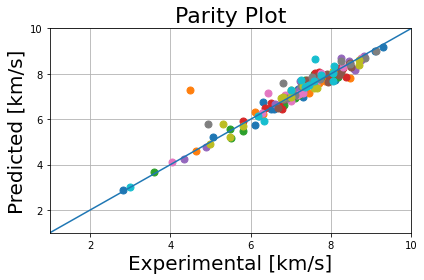

In [17]:
#test_preds = np.around(new_model.predict([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3]]),decimals=3)
#train_preds = np.around(new_model.predict([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3]]),decimals=3)

#preds = np.around(new_model.predict([inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3]]),decimals=3)

for i in range(len(test_outputs_list)):
   # plt.plot(train_outputs_list[i], train_preds_list[i], 'o')
    plt.plot(test_outputs_list[i], test_preds_list[i], 'o', markersize=7)

#plt.plot(df['D (exp) [km/s]'], df['D_KJ [km/s]'], 'o')

plt.xlabel('Experimental [km/s]', fontsize=20)
plt.ylabel('Predicted [km/s]', fontsize=20)
plt.title('Parity Plot', fontsize=22)

x = np.linspace(1, 10, 500)
plt.plot(x, x)
plt.ylim(1.0,10)
plt.xlim(1.0,10)

plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.grid()
plt.tight_layout()
plt.savefig("parity_plot.png")


In [ ]:
len(test_outputs_list)

In [ ]:
df['D_diff'] = abs(df['D (exp) [km/s]']-df['D_KJ'])
worst = df[['Explosive','D_diff','D (exp) [km/s]','D_KJ']].sort_values(by='D_diff')[-5:].reset_index(drop=True)

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

x = np.linspace(min(df['D (exp) [km/s]']), max(df['D (exp) [km/s]']), 500)
plt.plot(df['D (exp) [km/s]'], df['D_KJ'], 'o', markersize=12.0)
plt.plot(x, x)

for i in range(len(worst)):                                       # <--
    ax.annotate(str(worst['Explosive'][i]), xy=(worst['D (exp) [km/s]'][i], worst['D_KJ'][i]), fontsize=16) # <--

ax.set_xlabel('Experimental [km/s]', fontsize=24)
ax.set_ylabel('Predicted [km/s]', fontsize=24)
ax.set_title('Parity Plot', fontsize=24)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

plt.ylim(1,10)
plt.xlim(1,10)
plt.grid()

In [ ]:
df['D (exp) [km/s]'].mean()

In [ ]:
rms = np.sqrt(mean_squared_error(df['D (exp) [km/s]'], df['D_KJ']))

In [ ]:
rms

In [ ]:
worst

In [ ]:
#individual = [3, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 0, 0]  # complx = 24 
#individual = [3, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 0, 0]  # complx = 24*
individual = [0, 0, 1, 3, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0] # p.01
#individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0]


In [ ]:
#### Train Converged PNN with all 152 data points and evaluate with new 37 unseen data points ####

#### TRAIN ####
new_model, trainable = create_model(individual)
train(new_model, Train_inputs, Train_outputs, verbose=True)
train_full_mse = new_model.evaluate([Train_inputs[:,0],Train_inputs[:,1],Train_inputs[:,2],Train_inputs[:,3]], Train_outputs)
train_full_preds = np.around(new_model.predict([Train_inputs[:, 0], Train_inputs[:, 1], Train_inputs[:, 2], Train_inputs[:, 3]]),decimals=3)

#### TEST ####
TEST_mse = new_model.evaluate([Test_inputs[:,0],Test_inputs[:,1],Test_inputs[:,2],Test_inputs[:,3]], Test_outputs)
TEST_preds = np.around(new_model.predict([Test_inputs[:, 0], Test_inputs[:, 1], Test_inputs[:, 2], Test_inputs[:, 3]]),decimals=3)
  


In [ ]:
#### Parity Plot ####
plt.plot(Train_outputs, train_full_preds, 'o', label='Train')
plt.plot(Test_outputs, TEST_preds, 'o', label='Test')

plt.xlabel('Experimental [km/s]', fontsize=20)
plt.ylabel('Predicted [km/s]', fontsize=20)
plt.title('Parity Plot', fontsize=24)

x = np.linspace(1, 10, 500)
plt.plot(x, x)
plt.ylim(1.0,10)
plt.xlim(1.0,10)

plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

print('Train MSE:',train_full_mse,'Train RMSE:',np.sqrt(train_full_mse))
print('Test MSE:',TEST_mse,'Test RMSE:',np.sqrt(TEST_mse))

plt.legend()
plt.grid()